# Overview of the BindingDB dataset

The aim of this section is to inspect and analyze the BindingDB dataset on a general level. This overview of the dataset ensures the remainder of the analyses rely on solid, foundational knowledge of the availability and distribution of the given data. In addition, this highlights biases that may arise from the data itself. Thus, we propose to inspect the data by categories that will be analyzed in depth in subsequent section. In particular, this section offers an overview of Binding Kinetics, data related to targets and ligands (IDs, names, sequences, etc.), and metadata (publications, institutions, patents, etc.)

##### Loading Data and Defining Categories

In [2]:
# IMPORTS
# base
import pandas as pd
import numpy as np
import itertools
from itertools import combinations
import json
from bs4 import BeautifulSoup
import re
import datetime

# cleaning
from src.utils.utils import group_categories
from src.utils.utils import count_classified_rows

# importing from scripts
from src.scripts import targets

# stats
import statsmodels.formula.api as smf
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from scipy.stats import ttest_ind

# plots
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib.gridspec import GridSpec
import plotly.express as px
from src.scripts.data_description import (
    plot_availability,
    plot_distributions,
    plot_overlaps,
    categorical_countplot,
)

import warnings

warnings.filterwarnings("ignore")

In [2]:
usecols = [
    "BindingDB Reactant_set_id",
    "Ligand SMILES",
    "Ligand InChI",
    "Ligand InChI Key",
    "BindingDB MonomerID",
    "BindingDB Ligand Name",
    "Target Name",
    "Target Source Organism According to Curator or DataSource",
    "Ki (nM)",
    "IC50 (nM)",
    "Kd (nM)",
    "EC50 (nM)",
    "kon (M-1-s-1)",
    "koff (s-1)",
    "pH",
    "Temp (C)",
    "Curation/DataSource",
    "Article DOI",
    "BindingDB Entry DOI",
    "PMID",
    "PubChem AID",
    "Patent Number",
    "Authors",
    "Institution",
    "Ligand HET ID in PDB",
    "PDB ID(s) for Ligand-Target Complex",
    "PubChem CID",
    "PubChem SID",
    "ChEBI ID of Ligand",
    "ChEMBL ID of Ligand",
    "DrugBank ID of Ligand",
    "IUPHAR_GRAC ID of Ligand",
    "KEGG ID of Ligand",
    "ZINC ID of Ligand",
    "Number of Protein Chains in Target (>1 implies a multichain complex)",
    "BindingDB Target Chain Sequence",
    "PDB ID(s) of Target Chain",
    "UniProt (SwissProt) Recommended Name of Target Chain",
    "UniProt (SwissProt) Entry Name of Target Chain",
    "UniProt (SwissProt) Primary ID of Target Chain",
    "UniProt (TrEMBL) Primary ID of Target Chain",
]

In [3]:
df = pd.read_csv(
    r"data/BindingDB_All.tsv",
    sep="\t",
    usecols=usecols,
)

In [4]:
# Defining categories
binding_kinetics = [
    "Ki (nM)",
    "IC50 (nM)",
    "Kd (nM)",
    "EC50 (nM)",
    "kon (M-1-s-1)",
    "koff (s-1)",
    "pH",
    "Temp (C)",
]

target_related = [x for x in usecols if "Target" in x]
ligand_related = [x for x in usecols if "Ligand" in x]
id_columns = [x for x in usecols if ("ID" in x) or ("id" in x)]
id_columns.append("Ligand InChI Key")
names = [x for x in usecols if "Name" in x]
metadata = [
    x
    for x in usecols
    if (x not in target_related)
    and (x not in ligand_related)
    and (x not in id_columns)
    and (x not in names)
    and (x not in binding_kinetics)
]

### Binding Kinetics Data

A key area for understanding ligands and targets is knowledge on the binding kinetics of such interactions. BindingDB offers various metrics of these kinetics, such as Ki, IC50, Kd, kon and koff, with variable availability. Below, we show this availability in the dataset per metric (left; numerically and visually). Here, we directly observe that many values are missing. Most notably, $k_{on}$ and $k_{off}$ are only measured for 0.03% of the given entries. At most, 66.8% of entries are measured, for the IC50 metric. 

Interestingly, some metrics seem to be available when others are not. To better understand this, we also show the overlap between pairs of metrics (right; maximal color scale is reached at the 75th percentile of all values for better visualisation). From this plot, we observe that overlap between metrics is relatively low, with a highest overlap at 5.76% between IC50 and pH. However, conclusions may still be made from low overlap. We take the overlap between Ki and IC50 as an example. Ki and IC50 are linked by the Cheng-Prusoff equation: $IC50 = Ki(1+[S]/Km)$ (for competitive binding). Thus, when data is entered in the present dataset, knowing Ki or IC50 is sufficient to describe the binding kinetics. We see this near exclusiveness on the left plot, as well as from the 0.11% overlap. However, even though the overlap is very small, given the size of the dataset, we are still able to link both metrics and perform regressions. Thus, we conclude that the low levels of overlaps within binding kinetics data is still sufficient for further statistical analyses in subsequent sections.

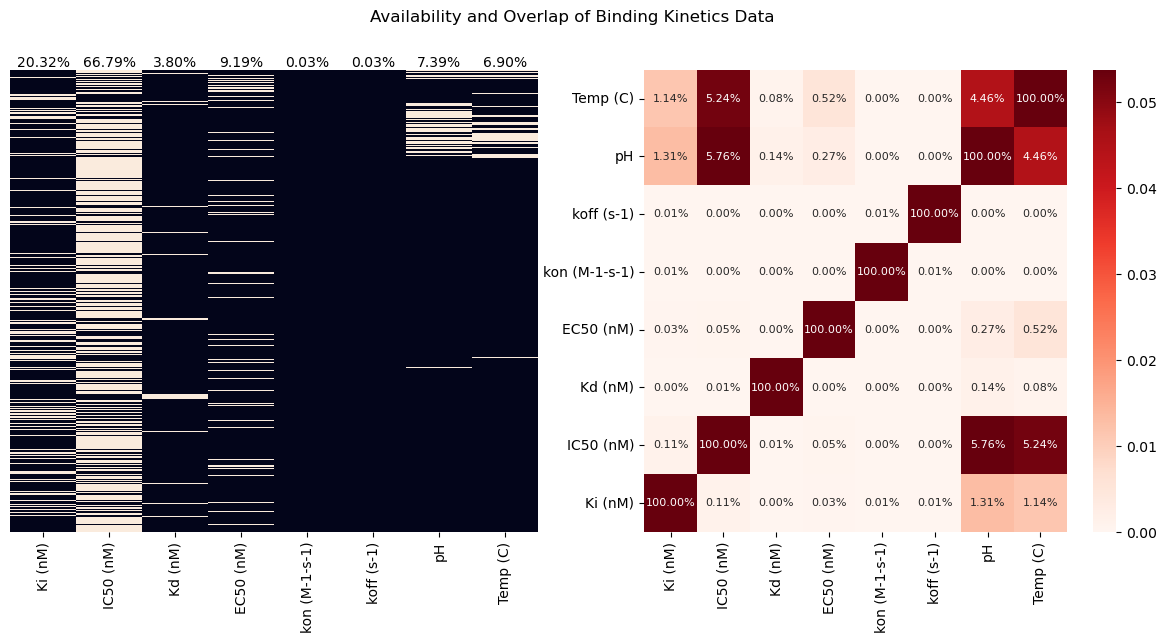

In [5]:
# availability and overlap
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))
plot_availability(df=df, group=binding_kinetics, ax=axs[0])
plot_overlaps(df=df, group=binding_kinetics, ax=axs[1])
plt.suptitle("Availability and Overlap of Binding Kinetics Data")
plt.show()

In [6]:
# clean binding kinetics data
df.replace(" NV,", np.nan, inplace=True)
for col in binding_kinetics:
    df[col] = df[col].astype(str).str.replace(" C", "")
    df[col] = (
        df[col].astype(str).str.replace(">", "").str.replace("<", "").astype(float)
    )

In [7]:
# modeling example
both = df[df["IC50 (nM)"].notna() & df["Ki (nM)"].notna()][["IC50 (nM)", "Ki (nM)"]]
both_log = both.apply(np.log)
both_log = both_log.rename(columns={"Ki (nM)": "log_Ki", "IC50 (nM)": "log_IC50"})
mod = smf.ols(formula="log_Ki ~ log_IC50", data=both_log)
np.random.seed(2)
res = mod.fit()
res.summary()

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 log_Ki   R-squared:                       0.656
Model:                            OLS   Adj. R-squared:                  0.656
Method:                 Least Squares   F-statistic:                     6051.
Date:                Fri, 15 Nov 2024   Prob (F-statistic):               0.00
Time:                        17:18:50   Log-Likelihood:                -7438.3
No. Observations:                3177   AIC:                         1.488e+04
Df Residuals:                    3175   BIC:                         1.489e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.4933      0.086    -17.399      0.000      -1.662      -1.325
log_IC50       0.9294      0.012     77.790      0.000       0.906       0.953
==============================================================================
Omnibus:                      640.943   Durbin-Watson:                   0.334
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1243.980
Skew:                          -1.215   Prob(JB):                    7.47e-271
Kurtosis:                       4.868   Cond. No.                         14.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

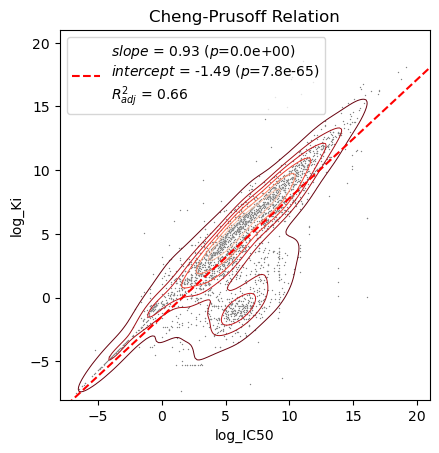

In [8]:
# plot
b, a = res.params
fig, axs = plt.subplots(1, 1)

sns.kdeplot(
    both_log[["log_Ki", "log_IC50"]].dropna(),
    y="log_Ki",
    x="log_IC50",
    levels=7,
    cmap="Reds_r",
    fill=False,
    linewidths=0.7,
    ax=axs,
)
sns.scatterplot(
    both_log[["log_Ki", "log_IC50"]].dropna(),
    y="log_Ki",
    x="log_IC50",
    s=1,
    color="grey",
    ax=axs,
)
x = np.linspace(-10, 25, num=50)
p_slope = res.pvalues["log_IC50"]
p_intercept = res.pvalues["Intercept"]
axs.plot(
    x,
    a * x + b,
    color="red",
    linestyle="--",
    label=f"$slope$ = {a:.2f} ($p$={p_slope:.1e})\n$intercept$ = {b:.2f} ($p$={p_intercept:.1e})\n$R^2_{{adj}}$ = {res.rsquared_adj:.2f}",
)
axs.set_xlim(-8, 21)
axs.set_ylim(axs.get_xlim())
axs.set_aspect("equal", adjustable="box")
axs.set_title("Cheng-Prusoff Relation")
axs.legend()
plt.show()

As discussed, the above scatter plot shows that a mere 0.11% of overlapping data is sufficient for statistical analyses. In particular, using a linear regression, we obtain the following relation: $log(Ki) = 0.93 * log(IC50) - 1.49$ ($R^2_{adj}=0.66$), or in other terms $Ki = 10^{-(-1.49)}y^{0.93}$. Thus, the slope of 0.93 (p~=0) indicates that the relation between Ki and IC50 is approximately linear, as expected from Cheng-Prusoff's relation. In addition, we observe that the $10^{-intercept}$ corresponds to $(1+[S]/Km)$. 

Interestingly, we observe two densities on the above plot, with seemingly different intercepts.This is investigated in detail in the "Cheng-Prusoff Classification" section under "Molecular and Chemical Features", but may be due to different populations of ligands, with different mechanisms of action, or differences in experimental paradigm.

On top of the availability of data presented above, we propose next show the distribution of each binding kinetics metric, overlaid with their medians, and lower and upper quartiles.

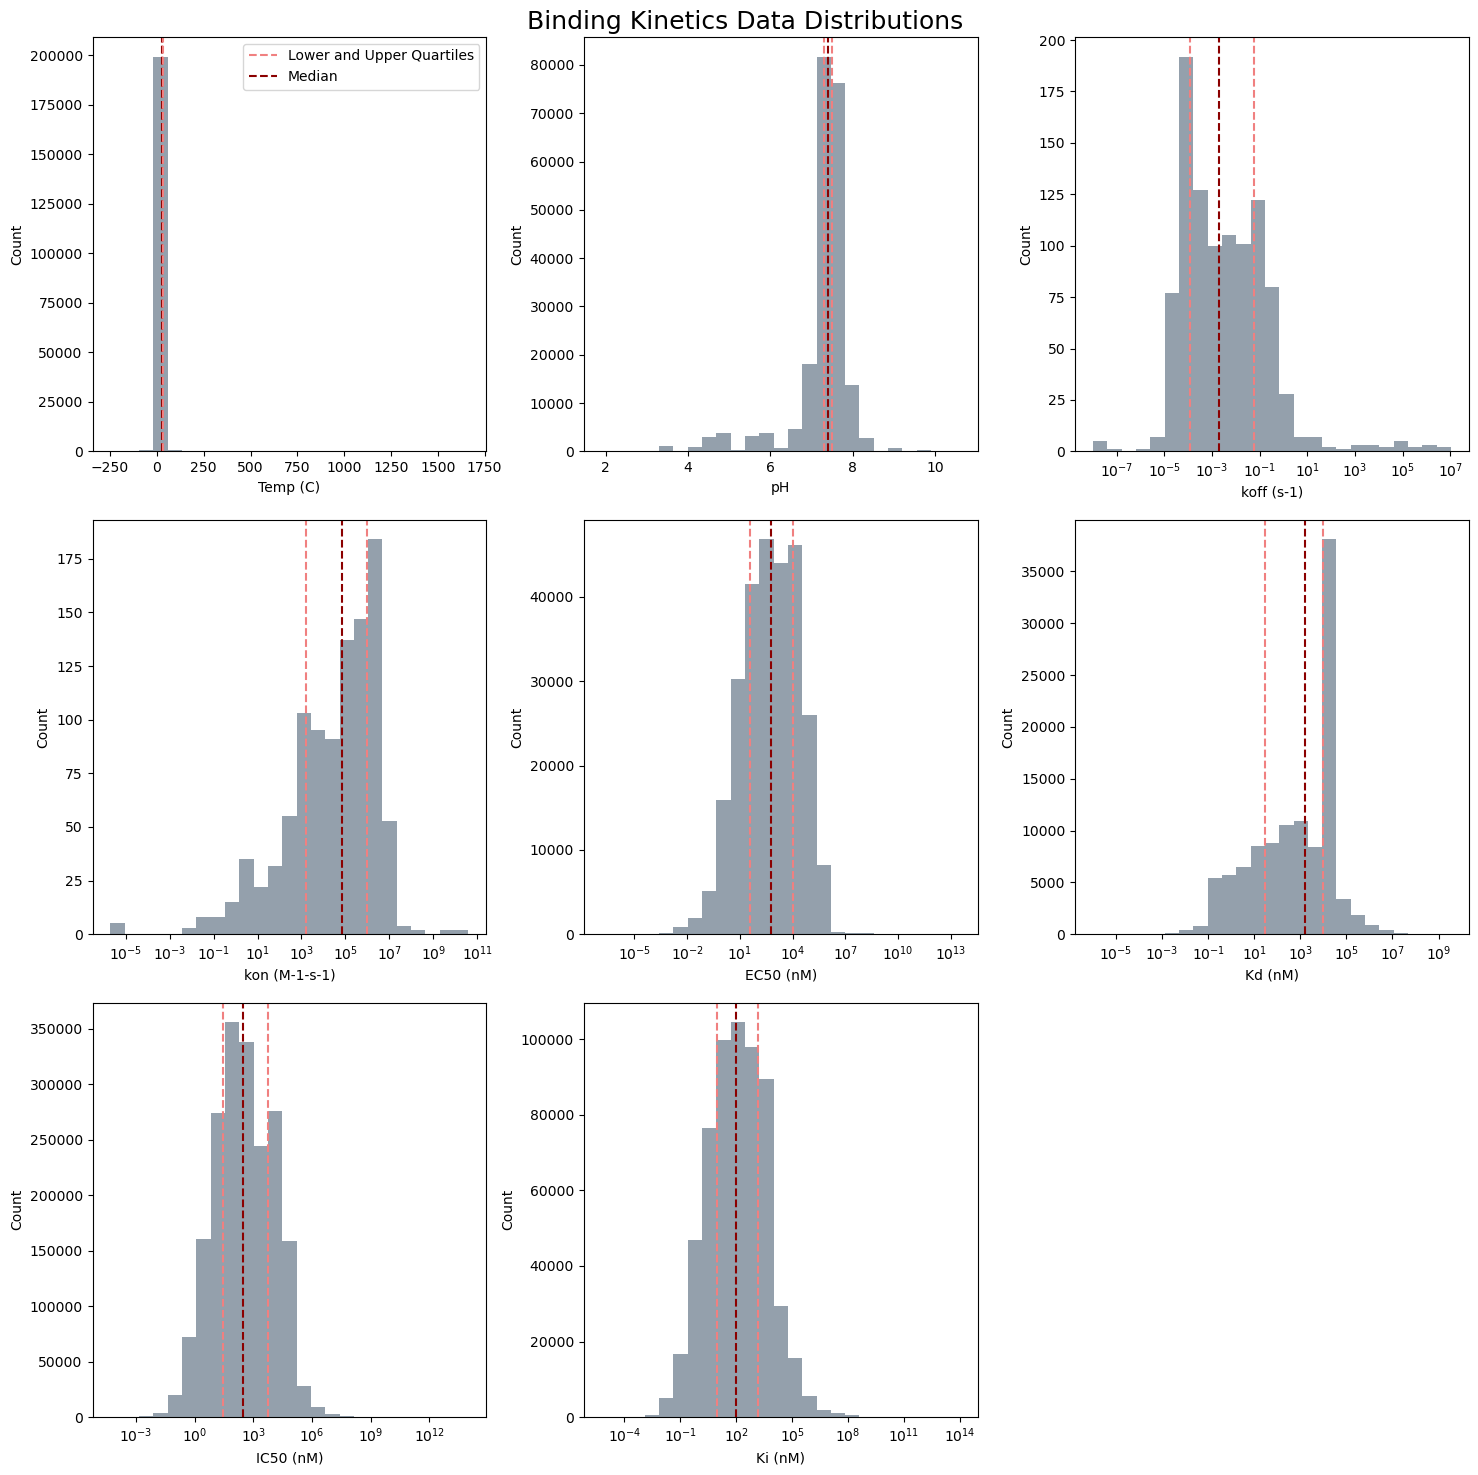

In [9]:
# data distributions
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(15, 15))
for idx, (col, ax) in enumerate(zip(binding_kinetics, axs.flatten())):
    if idx == 0:
        show_legend = True
    else:
        show_legend = False
    if col == "pH" or col == "Temp (C)":
        logsc = (False, False)
    else:
        logsc = (True, False)
    plot_distributions(df, col, log_scale=logsc, ax=ax, show_legend=show_legend)
plt.suptitle("Binding Kinetics Data Distributions", fontsize=18)
plt.tight_layout()
axs.flatten()[8].remove()
plt.show()

The above figure shows the distribution of each metric. In particular, we first appreciate that most measurements are made at physiological pH (around pH=7), and body temperature (around 37°C). Measures made outside these ranges are expected to be in extreme conditions or very different model organisms (see subsection on model organisms). In addition, we observe that all binding kinetics (aside pH and temperature) are "adequately" distributed on a log-scale. Importantly, on top of the numerical values found, this implies that any analyses involving binding kinetics shall preferentially be based on the logarithm of their values.

As a note, Kd sees a spike in counts between 10^4 and 10^5 nM. This is an artifact arising from the cleaning of the data, where many values are noted to pass a certain threshold (e.g. > 10^4). We note this artifact as it might introduce biases in results.

### Target and Ligand Related Data

In addition to binding kinetics, ligand and target information is crucial to this project, especially when describing molecular features that may lead to success in drug discovery. Thus, a similar data overview is proposed as above for such data (ligand structures, target sequences, IDs for external datasets, etc.). First, we show the availability of the data.

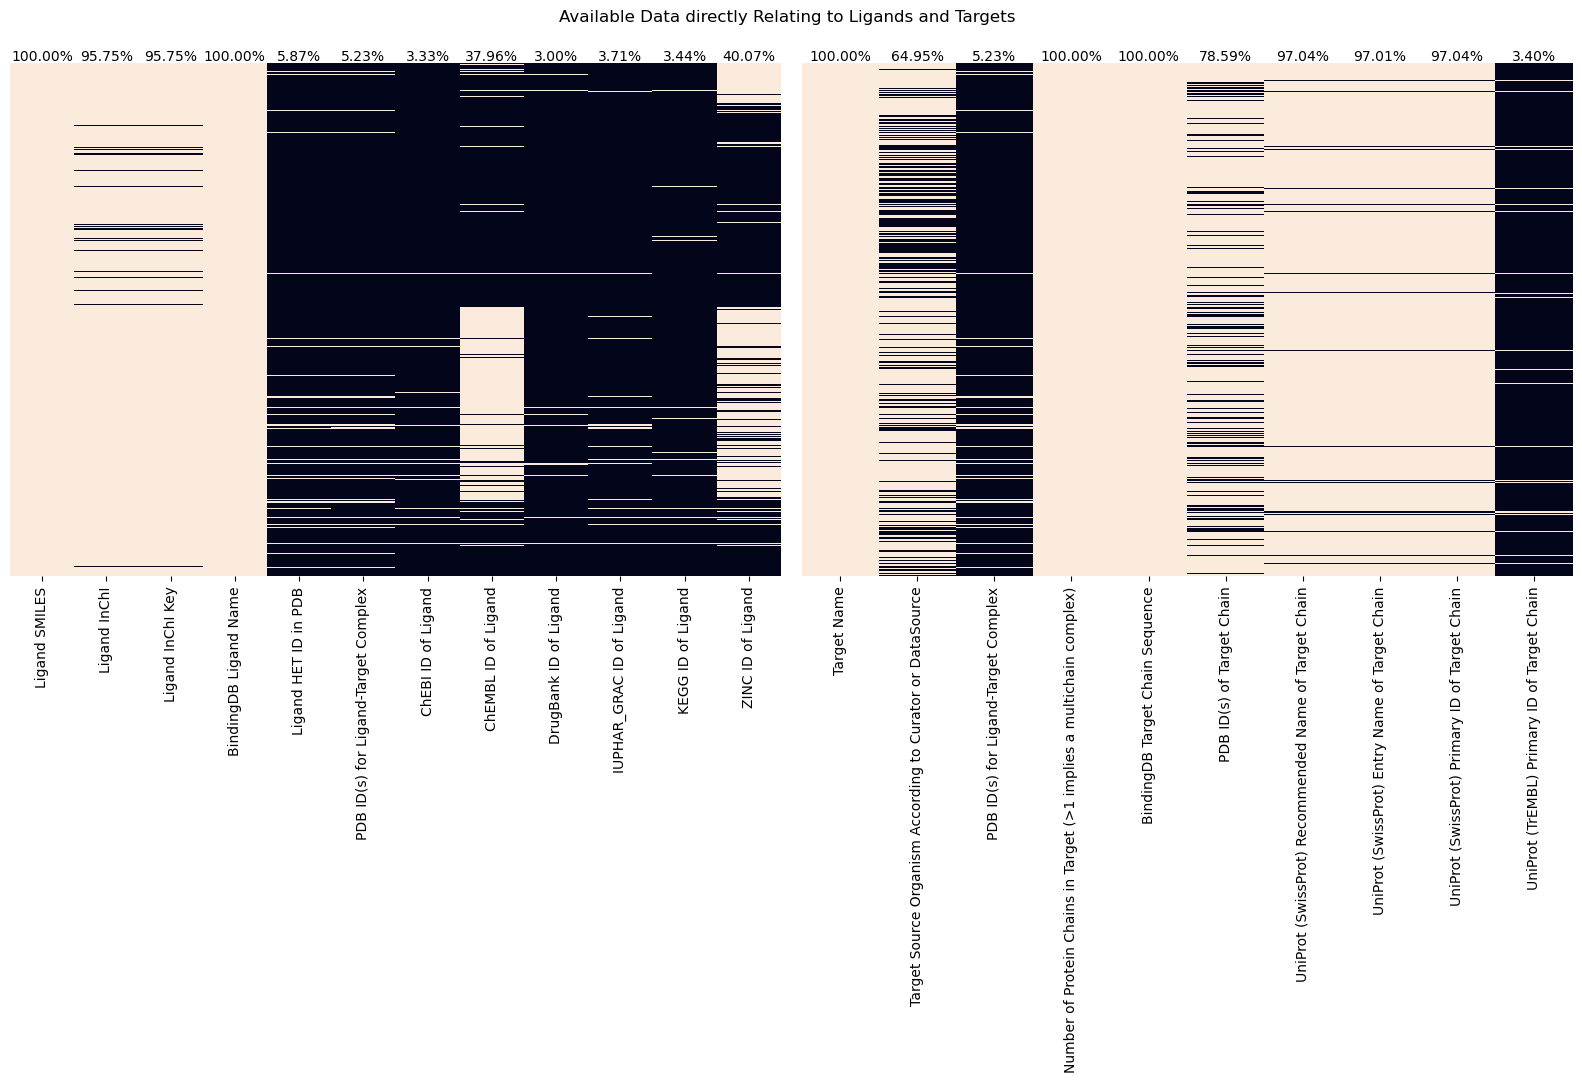

In [10]:
# availability
ligands_and_targets = list(set(ligand_related + target_related))
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(16, 11))
plot_availability(df=df, group=ligand_related, ax=axs[0])
plot_availability(df=df, group=target_related, ax=axs[1])
plt.suptitle("Available Data directly Relating to Ligands and Targets\n")
plt.tight_layout()
plt.show()

From the above plot, we appreciate that, generally, more data is available in this category than for binding kinetics. In particular, ligand structures (SMILES) is available for 100% of entries, as is the target chain sequence. This data will be of great use in subsequent analyses, especially pertaining to molecular features. 

On the contrary, the lowest availability is observed for DrugBank IDs of ligands. Rather than a faulty database, this is actually a good primary indicator of the first steps of drug discovery. Indeed, this low attribution of DrugBank IDs may simply reflect the low success rate in the initial steps of drug discovery. In general, we are satisfied with the proportion and distribution of available data shown above, in our aim of characterizing molecular features, enriched with external datasets.

For completeness, we show the overlap between data pairs below. In general, a low overlap is often simply caused by the low availability of one item of the data pair. However, as these data are mostly used to access external datasets, we give less importance to the overlap than for data relating to binding kinetics.

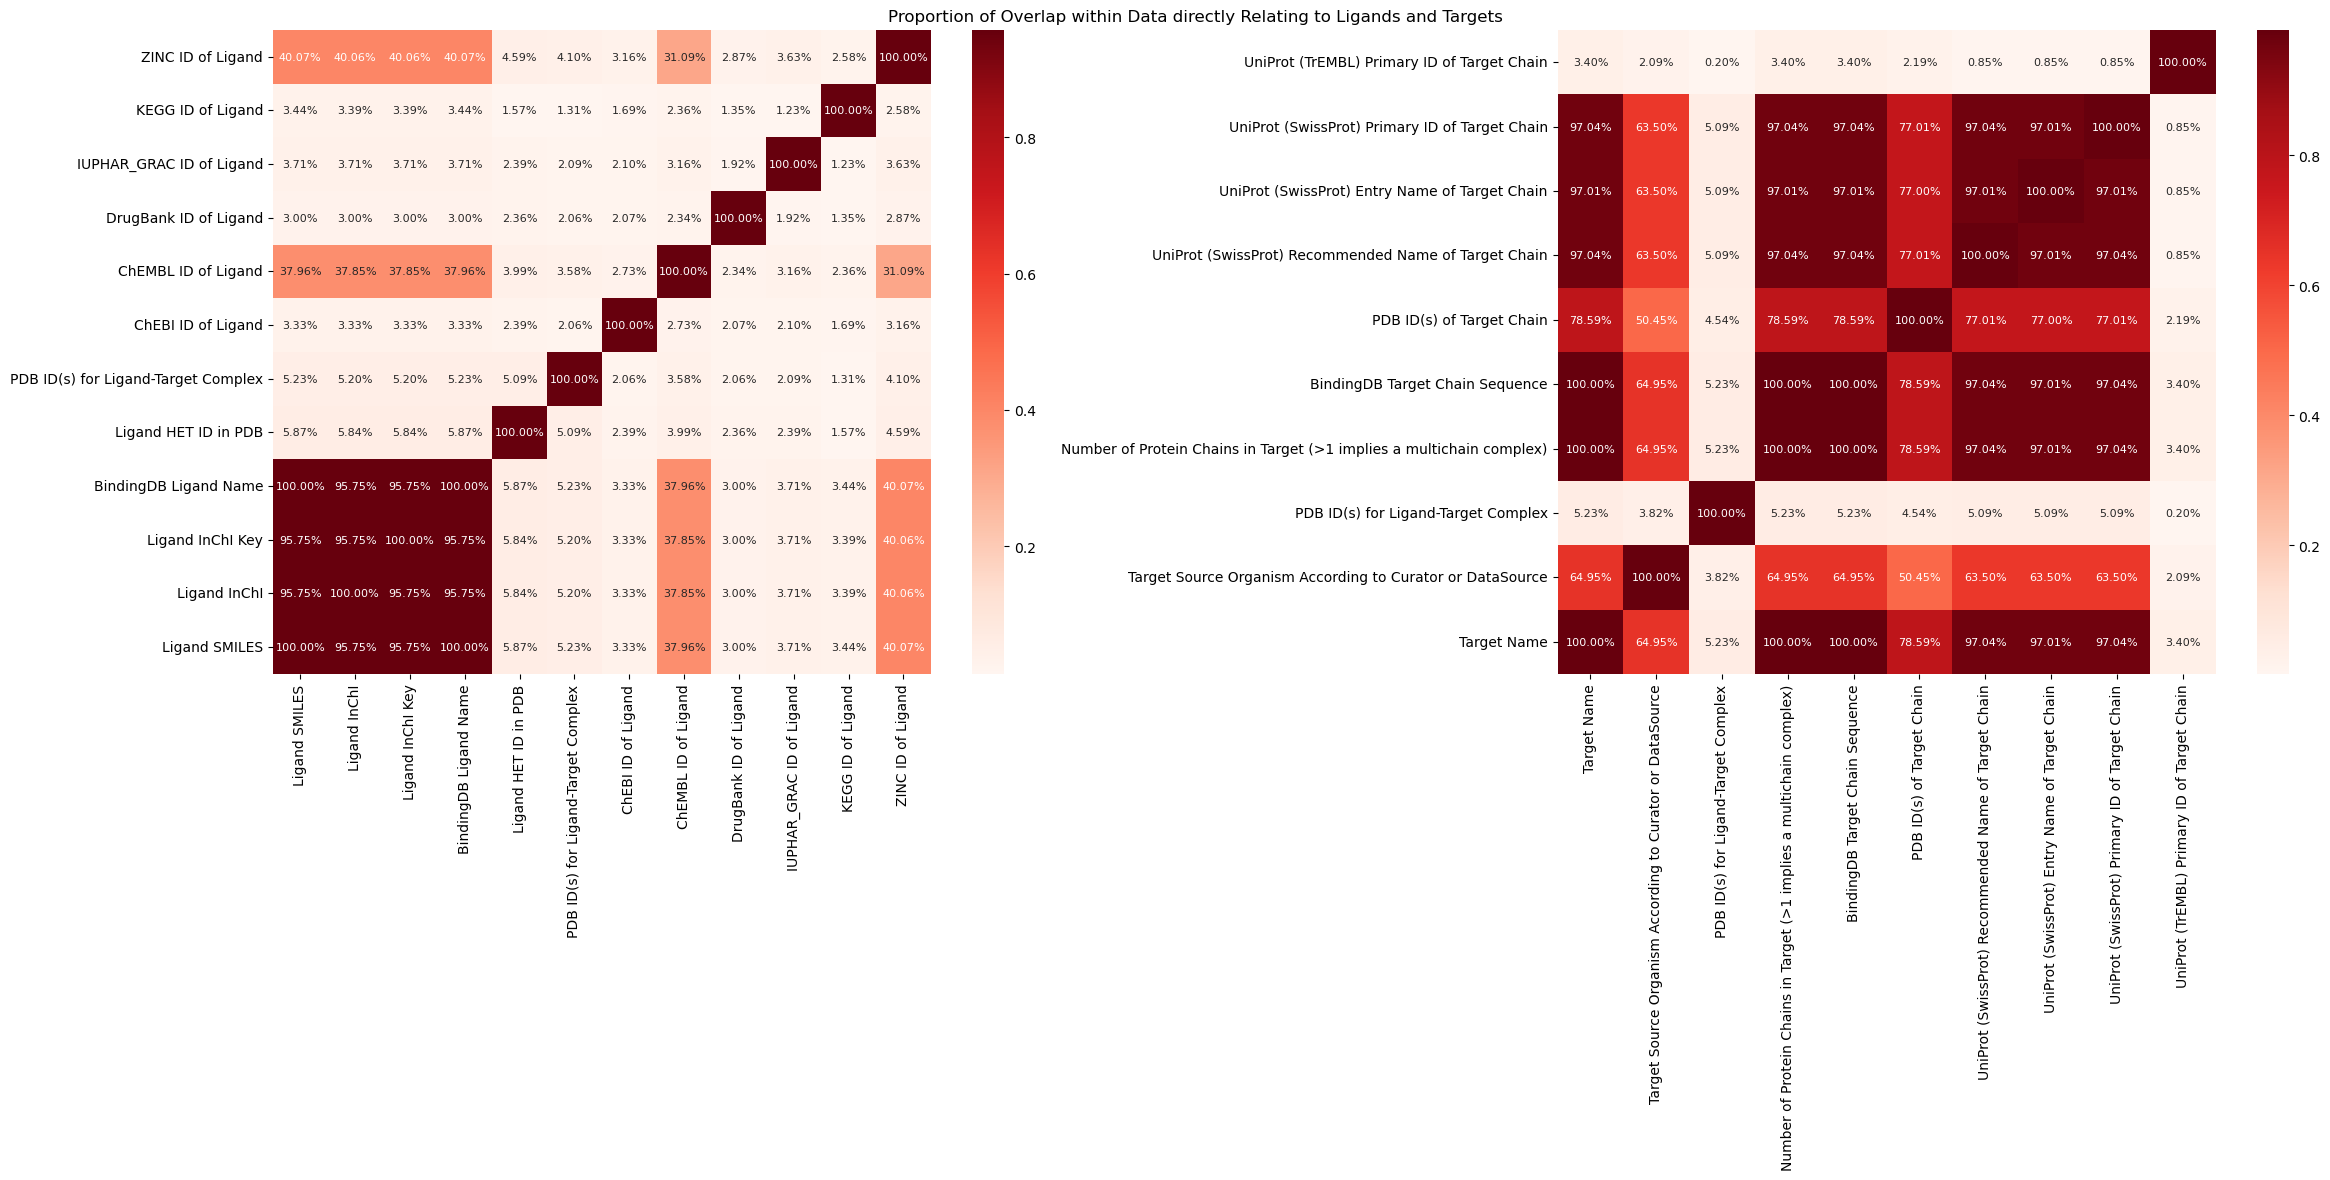

In [11]:
# overlap
fig, axs = plt.subplots(1, 2, figsize=(24, 12))
plot_overlaps(df, ligand_related, ax=axs[0])
plot_overlaps(df, target_related, ax=axs[1])
plt.suptitle(
    "Proportion of Overlap within Data directly Relating to Ligands and Targets"
)
plt.tight_layout()
plt.show()

#### Target Organisms

On top of the IDs, structures and sequences presented above, we pay particular attention to the target source organisms. Indeed, in our aim of identifying success factors in drug discovery, understanding which target organisms are used as models is a first crucial step. It is also worthy to note that many diseases in humans are actually treated by targeting other organisms' proteins, most notably in viral or bacterial infections. Thus, we show below the distribution of target organisms.

In [12]:
# cleaning target organism data
in_mapping = {
    "Human immunodeficiency virus": ["immunodeficiency virus", "hiv"],
    "Sars coronavirus": ["severe acute respiratory", "sars"],
    "Human herpes virus": ["herpes"],
    "Homo sapiens": ["h. sapiens"],
    "Mus musculus": ["mouse", "m. musculus"],
    "Rattus norvegicus": ["rattus", "r. norvegicus"],
    "Cavia porcellus": ["cavia"],
    "Hepatitis C": [],
    "Escherichia coli": ["coli"],
    "Caenorhabditis elegans": ["elegans"],
    "Influenza virus": ["influenza"],
    "Oryctolagus cuniculus": ["cuniculus"],
    "Streptococcus pyogenes": ["pyogenes"],
    "Plasmodium falciparum": [],
    "Saccharomyces cerevisiae": ["cervisiae"],
    "Streptococcus pneumoniae": [],
    "Mycobacterium tuberculosis": [],
}

f = lambda x: group_categories(
    str(x),
    in_mapping=in_mapping,
    check_key_for_in_mapping=True,
)

df["Target Source Organism According to Curator or DataSource"] = (
    df["Target Source Organism According to Curator or DataSource"]
    .apply(f)
    .apply(str.capitalize)
    .replace("Nan", np.nan)
)

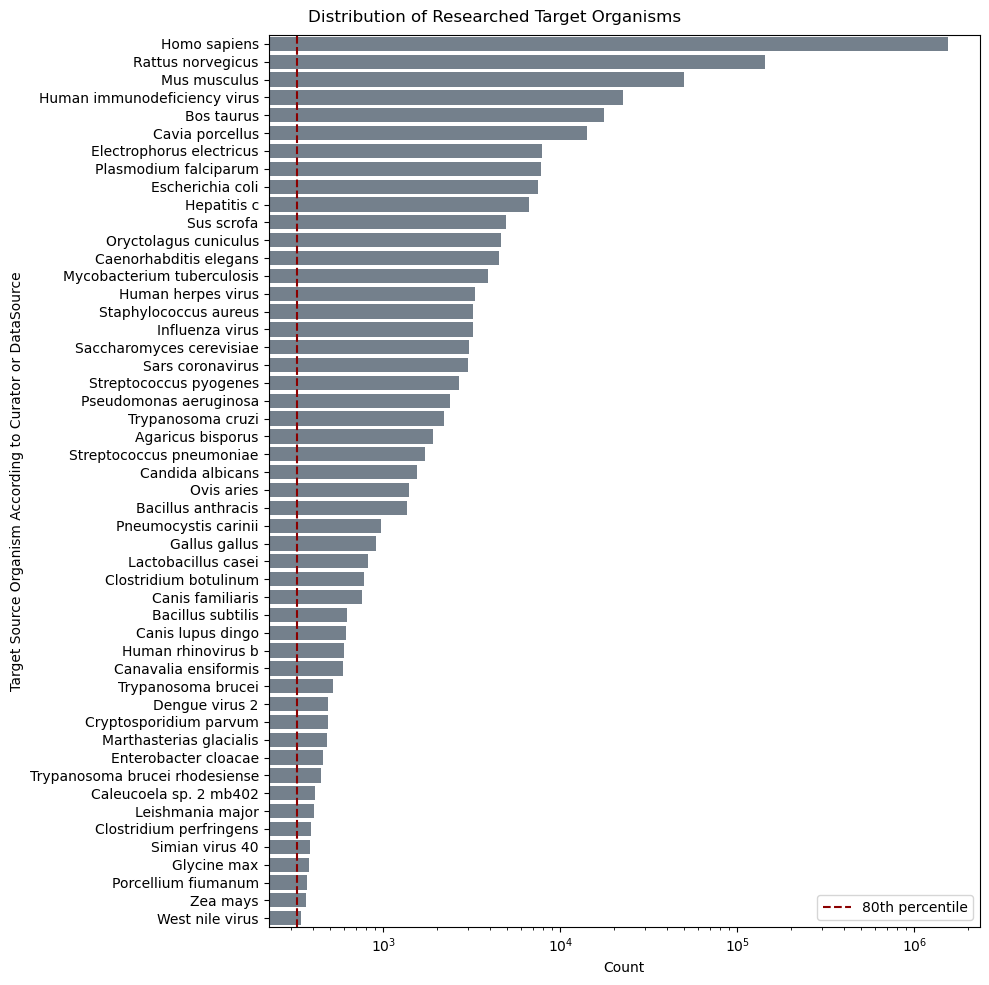

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
categorical_countplot(
    df,
    "Target Source Organism According to Curator or DataSource",
    ax=ax,
    percentile=0.8,
)
plt.suptitle("Distribution of Researched Target Organisms")
plt.tight_layout()
plt.show()

Without surprise, the above plot shows that H. sapiens is the most frequently targeted organism in research. Thereafter, are the common mice and rat models. Interestingly, these three models are used to target a large array of disease classes, as will be shown in a subsequent analysis. The fourth targeted organism however, relates to a single disease: HIV/AIDS. This highlights the importance of this disease class, for which research interest was immense, following the 1980s pandemic. This is shown below in a time series analysis. 

As mentioned above, we see many examples of such viral or bacterial infections being in the top 20% studied organisms (dashed red line represents the 80th percentile of counts in the BindingDB dataset). For example, SARS coronavirus, E.coli, Herpes virus, Hepatitis C and Influenza virus are all highly studied organisms.

As an intermediate conclusion, we therefore acknowledge that targeted organisms are either models for human diseases (such as M. musculus, R. norvegicus or C. elegans) or disease causing themselves (such as the bacteria and viruses mentioned above).

### Metadata

A final category of data of interest is metadata. Indeed, information such as article DOIs, patent numbers and institutions allows for a more complete overview of drug discovery. Indeed, key metrics of success are taken from the number of citations of a paper or patent. In addition, to understand the dynamics of drug discovery, the years of publications are highly useful for mapping drug discovery in time, while knowledge on institutions allows mapping drug discovery in space. 

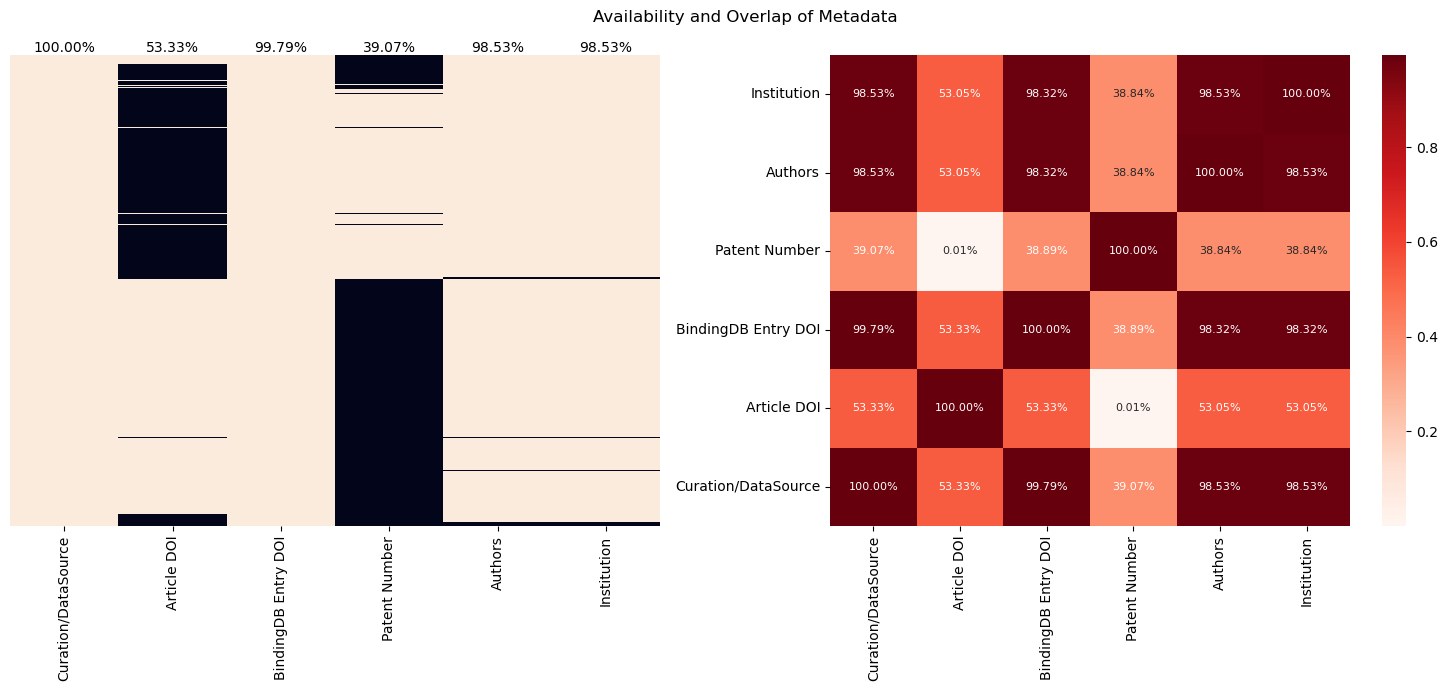

In [14]:
# availability and overlap
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 7))
plot_availability(df=df, group=metadata, ax=axs[0])
plot_overlaps(df, metadata, ax=axs[1])
plt.suptitle("Availability and Overlap of Metadata")
plt.tight_layout()
plt.show()

The above figure shows that roughly half the entries in bindingDB are linked to a publication. Also, around 40% of entries are under a patent. Interestingly, as seen on the right plot, the overlap between Article DOIs and Patent Numbers is only 0.01%. Thus, the two categories are nearly exclusive, showing that knowledge on citations of publications and patents are complementary success indicators. Secondly, as for the low amount of DrugBank IDs, the low overlap of Article DOIs and Patent Numbers show that only very few researched compounds lead to commercial benefit, demonstrating yet another hurdle in drug discovery.

To counter this very low turnover, researchers often initially resort to high-throughput screening, with the largest of the dataset covering around 12'000 compounds. This is taken into account when using number of citations as a success metric. More particularly, citations are only one of many indicators of success. The distributions of compounds studied per article and covered per patent are shown below.

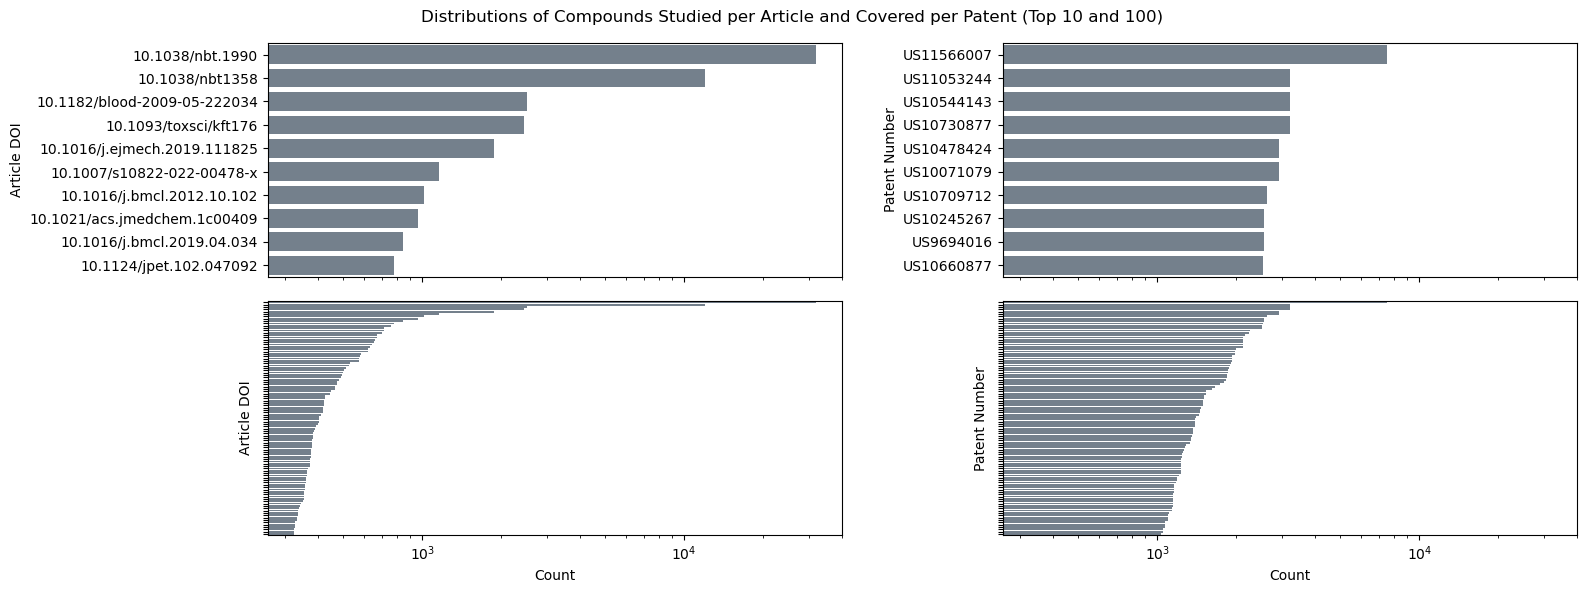

In [15]:
fig, axs = plt.subplots(2, 2, figsize=(16, 6), sharex=True)
N1 = 100
N2 = 10
categorical_countplot(df, "Article DOI", ax=axs[1, 0], N=N1)
categorical_countplot(df, "Article DOI", ax=axs[0, 0], N=N2)
categorical_countplot(df, "Patent Number", ax=axs[1, 1], N=N1)
categorical_countplot(df, "Patent Number", ax=axs[0, 1], N=N2)
plt.suptitle(
    f"Distributions of Compounds Studied per Article and Covered per Patent (Top {N2} and {N1})"
)
plt.tight_layout()
axs[1, 0].set_yticklabels("")
axs[1, 1].set_yticklabels("")
plt.show()

As mentioned above, in subsequent sections, we will also map drug discovery's success to institutions. We show here that such data is obtainable, showing the distribution of the top 20 institution in the BindingDB dataset.

In [16]:
in_mapping = {
    "Pfizer": [],
    "MSD": ["Dohme"],
    "Bristol-Myers Squibb": [],
    "Amgen": [],
    "Novartis": [],
    "Janssen": [],
    "Eli Lilly": ["lilly"],
    "Roche": [],
    "Incyte": [],
    "Gilead": [],
    "Bayer": [],
    "Abbott": [],
    "Scripps Research Institute": ["scripps"],
    "The Burnham Institute": ["burnham"],
    "Genentech": [],
    "GlaxoSmithKline": ["gsk"],
    "Astrazeneca": [],
    "Abbvie": [],
    "Merck": [],
    "Boehring": [],
}

f = lambda x: group_categories(
    str(x),
    in_mapping=in_mapping,
    check_key_for_in_mapping=True,
)

df["Institution"] = (
    df["Institution"].apply(f).replace("TBA", np.nan).replace("nan", np.nan)
)  # tba = to be attributed

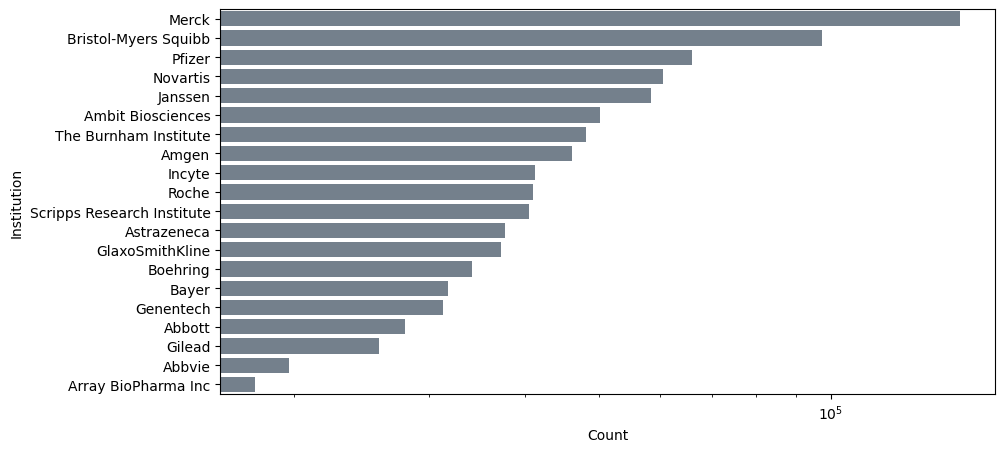

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
categorical_countplot(df, "Institution", N=20, ax=ax)
plt.show()

---

# Disease Classification

In [29]:
from src.scripts.disease_plotting import (
    load_uniprotid_diseases,
    quantify_missing_diseases,
    add_keywords_when_comments_missing,
    sort_diseases,
)
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pandas as pd
import plotly.express as px

import warnings

warnings.filterwarnings("ignore")

In [30]:
bindingdb_df = pd.read_csv(
    r"./data/BindingDB_All.tsv",
    sep="\t",
    usecols=["UniProt (SwissProt) Primary ID of Target Chain", "Article DOI"],
)

We now load the `src/data/UniprotID_disases.json` file which was generated using the following script in roughly 30 mins:

```py
from src.scripts.uniprot import get_uniprot_diseases
import os

get_uniprot_diseases(
    bindingdb_df["UniProt (SwissProt) Primary ID of Target Chain"].value_counts().index,
    savename=os.path.join(
        "src",
        "data",
        "UniprotID_disases.json",
    ),
)
```

The function `get_uniprot_diseases` uses an Uniprot API call to retrieve disease information. An Uniprot ID can be linked to more than one disease.

In [31]:
diseases = load_uniprotid_diseases()
ids_missing_diseases, percentage_missing = quantify_missing_diseases(diseases)
diseases_df = add_keywords_when_comments_missing(diseases)

print(
    f"Percentage of Uniprot IDs missing a disease description : {percentage_missing:.2f}%"
)
print(
    f"One random missing ID: https://www.uniprot.org/uniprotkb/{ids_missing_diseases[42]}"
)

Percentage of Uniprot IDs missing a disease description : 77.14%
One random missing ID: https://www.uniprot.org/uniprotkb/Q9Y5N1


As we observe, 77.14% of Uniprot IDs are missing a description of the related diseases. If we choose a random missing ID (`Q9Y5N1`), we see that on the Uniprot page, under the section `Disease & Variants`, there are no registered diseases.

One problem with using Uniprot's API is that sometimes the related diseases are either under the `keywords` section or the `comments` section. Since the `comments` section is more thorough, we decided to add the `keywords` to our data only if it is missing comments, using the `pandas.DataFrame.bfill` method and illustrated in the next cell.

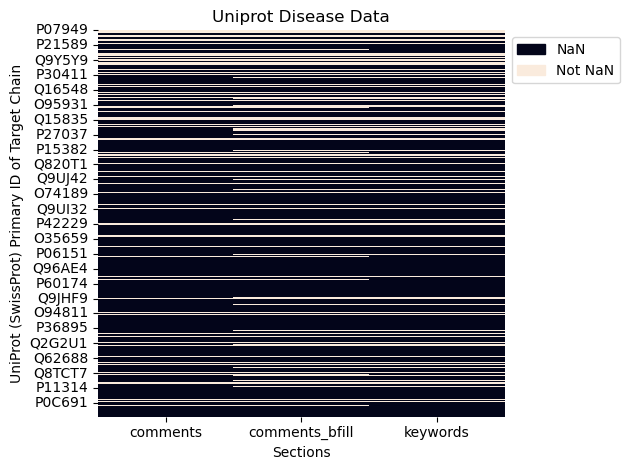

In [32]:
fig, ax = plt.subplots()

cmap = sns.color_palette("rocket", as_cmap=True)

sns.heatmap(
    diseases_df[
        [
            "UniProt (SwissProt) Primary ID of Target Chain",
            "comments",
            "comments_bfill",
            "keywords",
        ]
    ]
    .set_index("UniProt (SwissProt) Primary ID of Target Chain")
    .notna(),
    ax=ax,
    cbar=False,
    cmap=cmap,
)

isna_patch = mpatches.Patch(color=cmap.get_under(), label="NaN")
notna_patch = mpatches.Patch(color=cmap.get_over(), label="Not NaN")

ax.legend(title="", handles=[isna_patch, notna_patch])
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
ax.set_xlabel("Sections")

ax.set_title("Uniprot Disease Data")

plt.tight_layout()
plt.show()

With this data we can now plot the frequency of studied diseases. We group the diseases into different classes using the `sort_diseases` function, based on common names and terminologies. We then show the distribution of targeted diseases.

In [33]:
diseases_df = diseases_df.rename(columns={"comments_bfill": "diseases"})
diseases_df = diseases_df.dropna(subset="diseases").drop(
    columns=["comments", "keywords"]
)
diseases_df["Disease Classes"] = diseases_df["diseases"].apply(
    lambda l: [sort_diseases(l_i) for l_i in l]
)

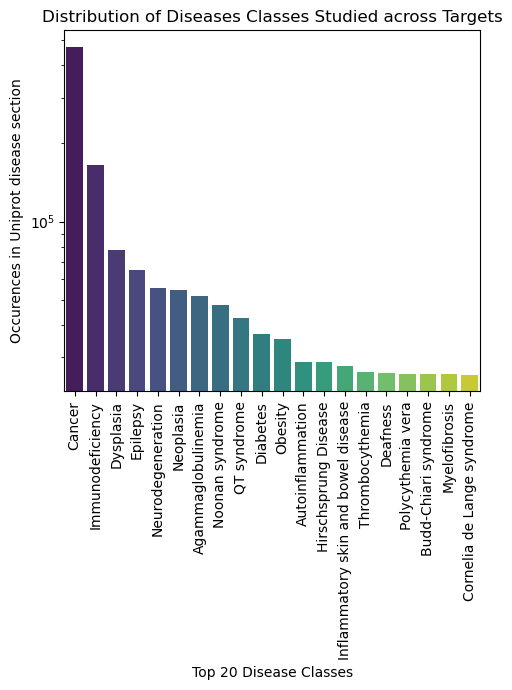

In [34]:
df_intersection_disease_class_counts = (
    bindingdb_df.merge(diseases_df, how="inner")
    .explode(["Disease Classes", "diseases"])
    .value_counts(subset=["Disease Classes"])
    .reset_index()
)

fig, ax = plt.subplots(figsize=(5, 7))

sns.barplot(
    data=df_intersection_disease_class_counts,
    x="Disease Classes",
    y="count",
    order=df_intersection_disease_class_counts["Disease Classes"][:20],
    # hue="count",
    legend=None,
    palette="viridis",
    ax=ax,
)

ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_xlabel("Top 20 " + ax.get_xlabel())
ax.set_yscale("log")
ax.set_ylabel("Occurences in Uniprot disease section")
ax.set_title("Distribution of Diseases Classes Studied across Targets")

plt.tight_layout()
plt.show()

In the above plot, we observe that `Cancer`, which regroups all kinds of different cancers, is the most studied disease class. Secondly is `Immuodeficiency`, recalling its importance in targeted organisms. `Neurodegeneration` which regroups diseases such as Parkinson and Alzheimer is 5th. Other neurological, cardiac and inflammatory diseases are also within the top 20 studies diseases.

We now load the `src/data/metadata.csv` file which was generated using the following script in roughly 5 hours:

```py
from src.scripts.metadata import add_extra_pub_data
import pandas as pd
df = pd.read_csv(
    r"./data/BindingDB_All.tsv",
    sep="\t",
    usecols=["Article DOI"],
)
add_extra_pub_data(df)
```

This function uses a `crossref` API call to collect additional metadata from publications, such as year, publisher and more.

In [7]:
doi_metadata = pd.read_csv(r"src/data/metadata.csv").dropna()
doi_metadata.describe(include="all").fillna("")

Article DOI                         journal         year  \
count               40719                           40719      40719.0   
unique              40719                             195                
top     10.1021/jm9602571  Journal of Medicinal Chemistry                
freq                    1                           13877                
mean                                                       2008.964709   
std                                                           8.519787   
min                                                             1965.0   
25%                                                             2004.0   
50%                                                             2010.0   
75%                                                             2016.0   
max                                                             2022.0   

          publisher  
count         40719  
unique           33  
top     Elsevier BV  
freq          21918  
mean                 
std                  
min                  
25%                  
50%                  
75%                  
max

From the `crossref` API, we collected the `journal`, the `year` and the `publisher` related to the `Article DOI`. We can see that there are 195 unique journals, and 33 different publishers. With the year, we can now correlate the frequency of diseases studied with time.

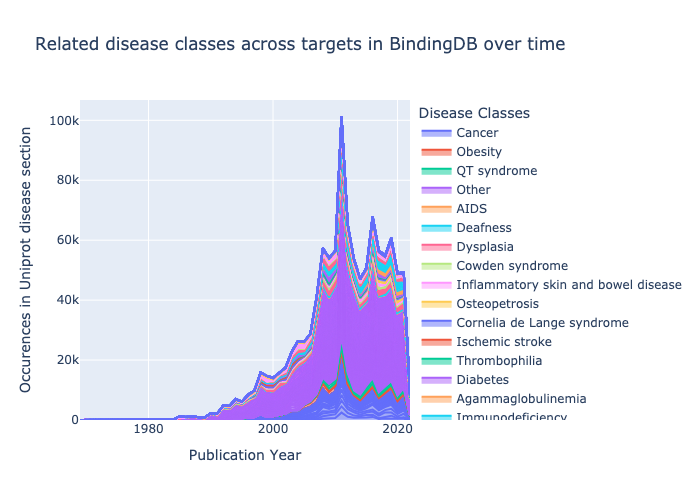

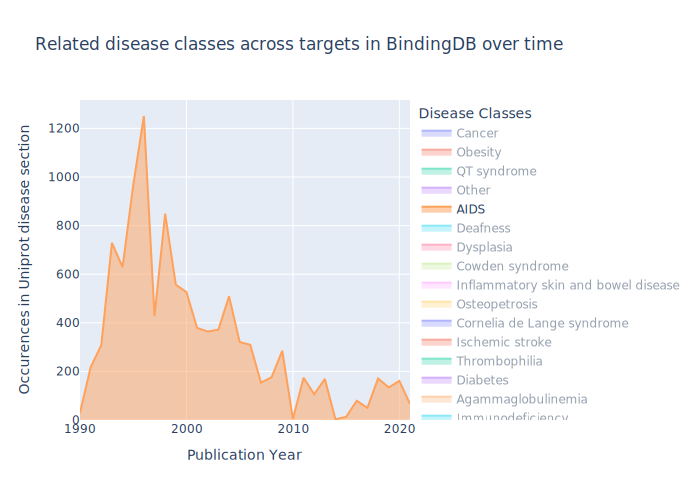

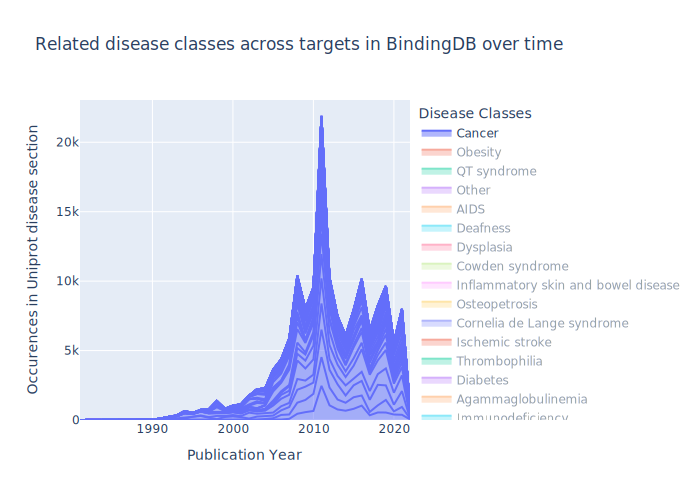

In [8]:
time_series_diseases_df = (
    bindingdb_df.dropna()
    .merge(diseases_df.dropna(), how="inner")
    .merge(doi_metadata.dropna(), how="inner")
)

time_series_diseases_df_count = (
    time_series_diseases_df.explode(["Disease Classes", "diseases"])
    .value_counts(subset=["year", "Disease Classes", "diseases"])
    .reset_index()
)
time_series_diseases_df_count["Disease Classes"] = time_series_diseases_df_count[
    "Disease Classes"
].replace(
    {
        k: "Other"
        for k in time_series_diseases_df.explode(["Disease Classes"])["Disease Classes"]
        .value_counts()
        .index[20:]
    }
)

fig = px.area(
    time_series_diseases_df_count,
    x="year",
    y="count",
    color="Disease Classes",
    line_group="diseases",
    labels={
        "count": "Occurences in Uniprot disease section",
        "year": "Publication Year",
    },
    title="Related disease classes across targets in BindingDB over time",
)
# fig.show() # Uncomment this line to view the figure interactively

fig.show(
    renderer="png"
)  # Low quality rendenring otherwise it slows the notebook too much

fig.for_each_trace(
    lambda t: t.update(visible=True)
    if t["legendgroup"] == "AIDS"
    else t.update(visible="legendonly")
)
fig.show(renderer="svg")

fig.for_each_trace(
    lambda t: t.update(visible=True)
    if t["legendgroup"] == "Cancer"
    else t.update(visible="legendonly")
)
fig.show(renderer="svg")

In the above plots, each line represents a single disease, while shades of colors represent the disease class. By interacting with this plot, we observe that `AIDS` was studied more during the 90's, peaked in 1996, and decreased ever since. This is highly likely due to the 1980s [AIDS pandemic](https://en.wikipedia.org/wiki/Epidemiology_of_HIV/AIDS). On the other hand, proteins related to cancer started to become more popular around 2004, peaked in 2011 where more specifically `Hepatocellular Carcinoma` was the most studied.

If we look at the data as a whole, we can see three peaks above 60k mentions, which are in 2011, in 2016 and in 2019, possibly reflecting the addition of new curations to BindingDB.

### Articles Citations

To gain a more comprehensive understanding of how research focus on various disease classes has evolved over time, we are now interested in analyzing citations trends. From the `crossref` API, we are able to retrieve the number of times each `Article DOI` was cited. This gives us an idea of its importance and influence in a specific research field.

We now load the `src/data/citations.json` file which was generated using the following script:

```py
from src.scripts.citations import get_citations

doi = df["Article DOI"].value_counts()
unique_doi_ordered = doi.index.tolist()
citations = []
for doi in unique_doi_ordered:
    citation = get_citations(doi)
    citations.append({"doi": doi, "citation": citation})
with open("citations.json", "w") as f:
    json.dump(citations, f)
```

The function `get_citations` uses the `crossref` API call to get the number of citations based on an Article DOI.

In [45]:
with open("src/data/citations.json", "r") as f:
    citations = json.load(f)

In the plot below, we visualize the citation count of the 100 most frequently cited articles in BindingDB.

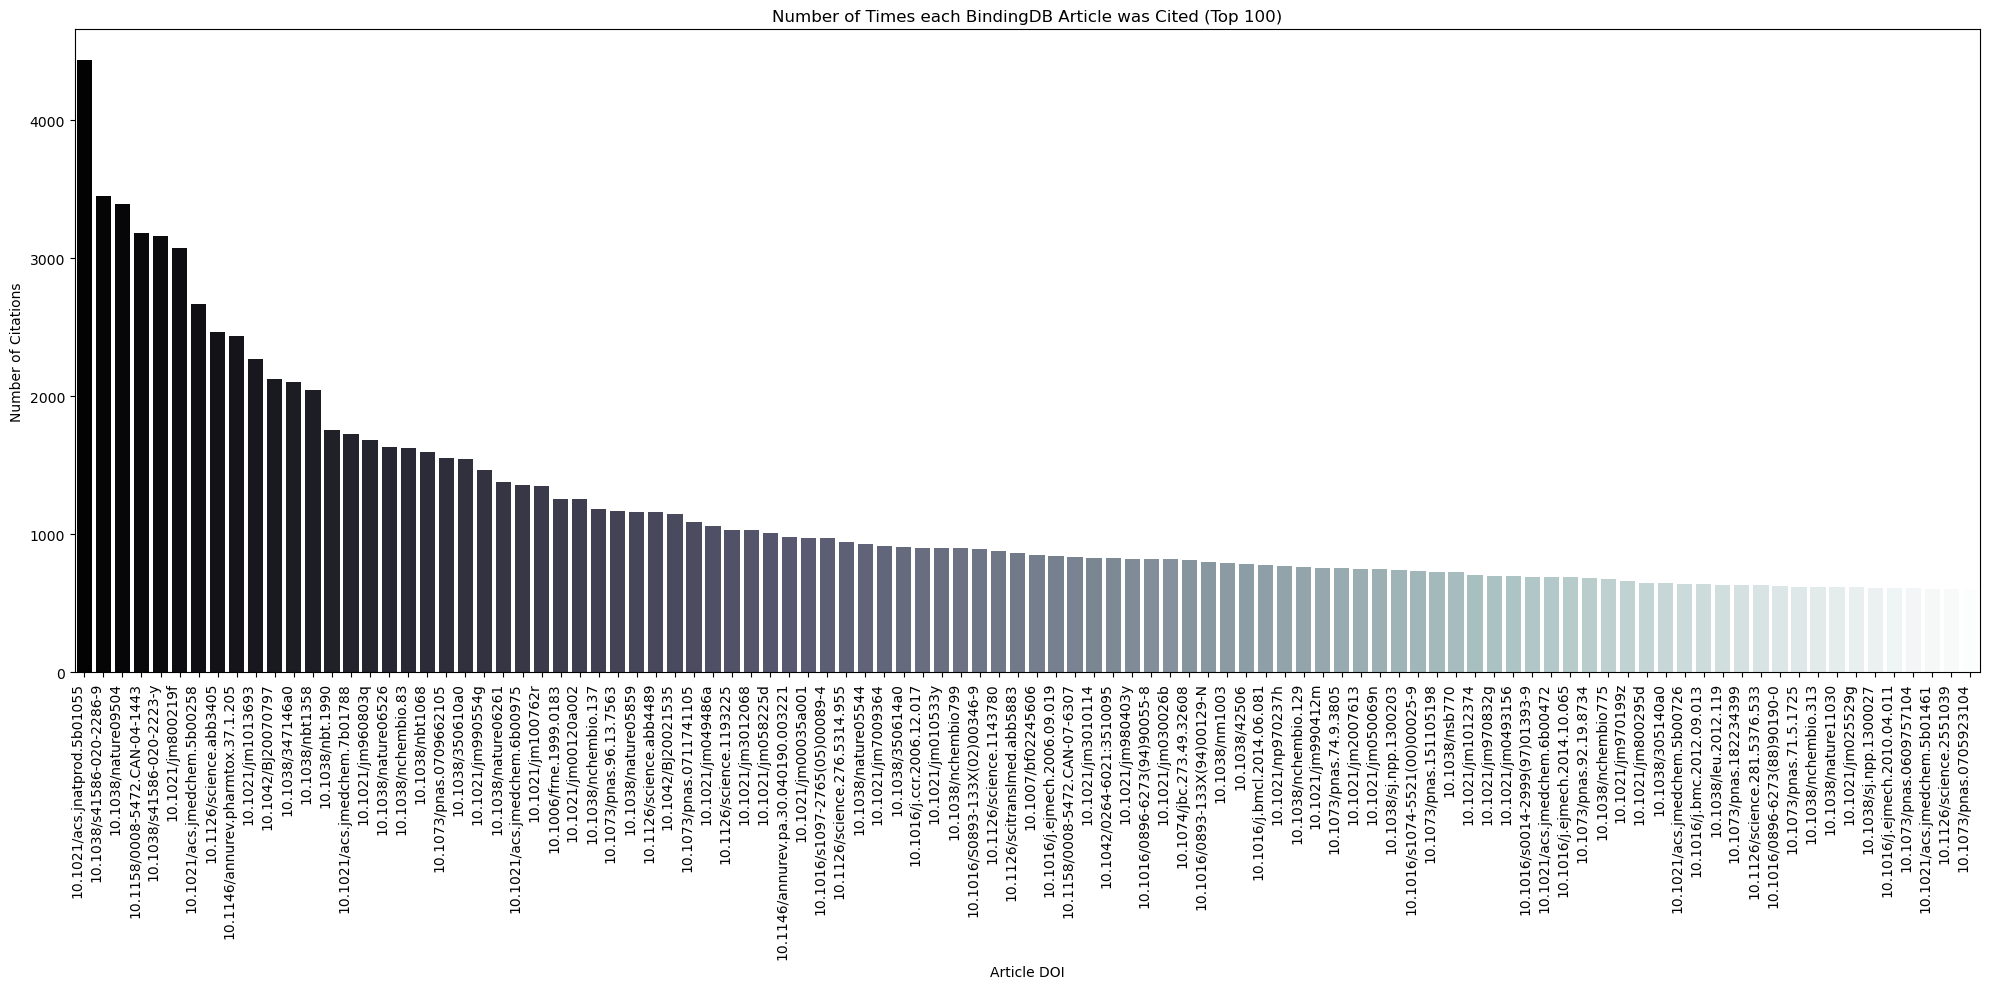

In [7]:
citations_df = (
    pd.DataFrame(citations).sort_values(by="citation", ascending=False).head(100)
)
plt.figure(figsize=(20, 10))
sns.barplot(x="doi", y="citation", data=citations_df, palette="bone")
plt.xticks(rotation=90, ha="right")
plt.xlabel("Article DOI")
plt.ylabel("Number of Citations")
plt.title("Number of Times each BindingDB Article was Cited (Top 100)")
plt.tight_layout()
plt.show()

To gain a deeper understanding of the influence of these articles, we are now interested in looking at citations trends for different disease classes. Indeed, we suspect this separation to be more informative than the overall distribution of citations.

In [46]:
from src.scripts.citations import get_citations_per_disease

citations_dict = {item["doi"]: item["citation"] for item in citations}
disease_citations_df = get_citations_per_disease(df, diseases_df, citations_dict)

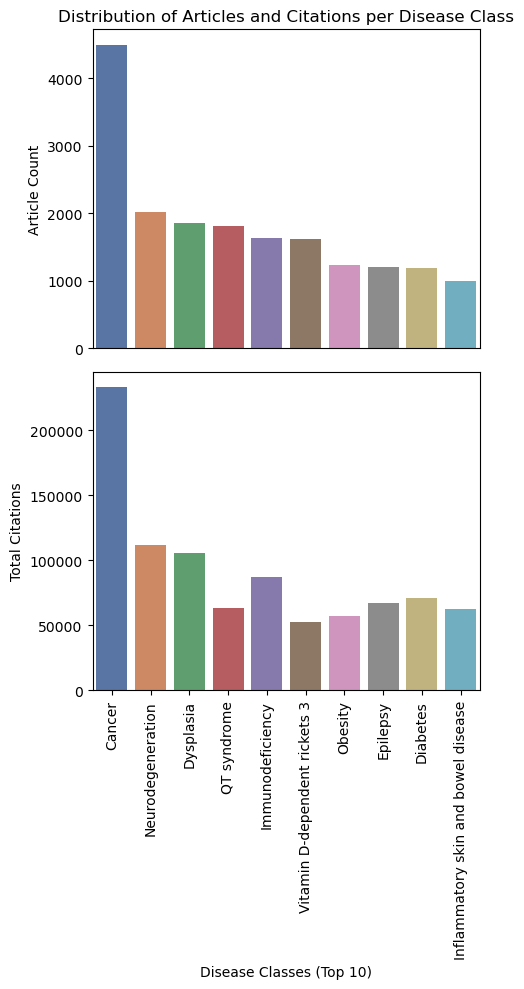

In [13]:
fig, axes = plt.subplots(2, 1, figsize=(5, 10), sharex=True)
sns.barplot(
    data=disease_citations_df[0:10],
    x="Disease Classes",
    y="Article Count",
    palette="deep",
    ax=axes[0],
)
axes[0].set_title("Distribution of Articles and Citations per Disease Class")
axes[0].tick_params(axis="x", which="both", bottom=False)

sns.barplot(
    data=disease_citations_df.head(10),
    x="Disease Classes",
    y="Total Citations",
    palette="deep",
    ax=axes[1],
)
axes[1].set_xlabel("Disease Classes (Top 10)")
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=90)


plt.tight_layout()
plt.show()

As expected, cancer has the highest article count as well as total citations count. Interestingly, we notice that having a higher article count does not necessarily mean a higher citation count. For instance, there are fewer articles investigating immunodeficiency compared to QT syndrome, however immunodeficiency is more cited.

This highlights the need for an additional metric to assess the importance and "success" of a disease class based on its citations.

One approach could be to look at the mean number of citations per article for each disease class. However, this only provides an average that may not reflect the true impact of a disease class on research focus, especially when there are a few highly-cited articles that skew the mean.

A second approach and more robust metric for assessing the impact and "success" could be to use the h-index. This metric is usually used as an indicator of a researcher's influence in his field. Precisely, a researcher has a h-index of h if h of their papers have at least h citations each, and the remaining papers have ≤h citations. Thus, this metric could be a better indicator of scholarly contribution and impact of a given field of research, by transfering the metric from authors to specific classes. By calculating the h-index for each disease class, we want to account for both the quantity and the citation strength of the work.

In [14]:
# Mean Citation per Article :
disease_citations_df["Mean Citation per Article"] = (
    disease_citations_df["Total Citations"] / disease_citations_df["Article Count"]
)

# H-index calculation :
from src.scripts.citations import calculate_H_index_diseases

disease_h_index_df = calculate_H_index_diseases(disease_citations_df, citations_dict)

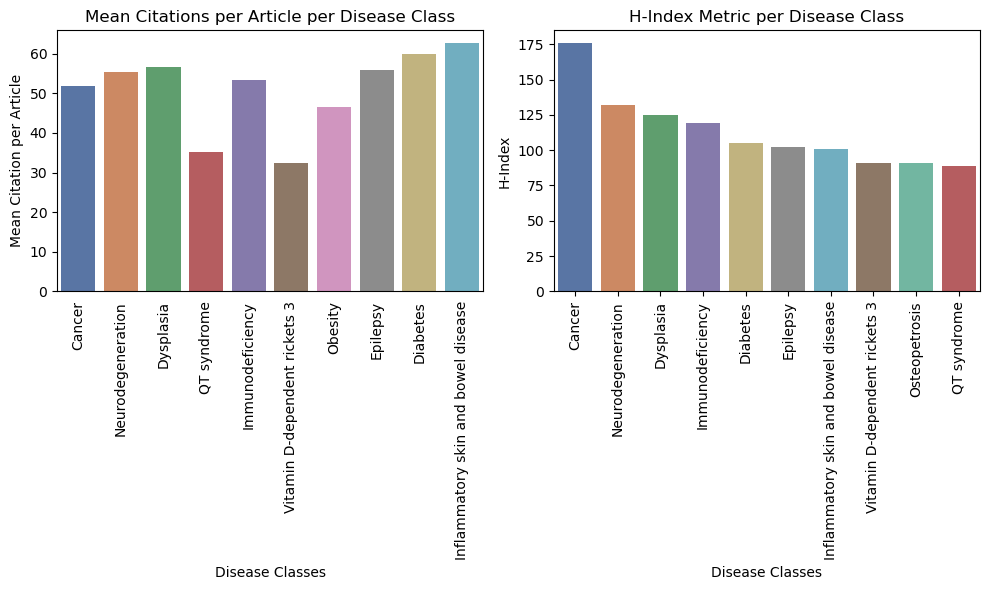

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(10, 6))
sns.barplot(
    data=disease_citations_df.head(10),
    x="Disease Classes",
    y="Mean Citation per Article",
    palette="deep",
    ax=axes[0],
)
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=90)
axes[0].set_title("Mean Citations per Article per Disease Class")
axes[0].tick_params(axis="x", which="both", bottom=False)

# Adapting color palette for second plot so it matches the first (same diseases have same color)
deep_palette = sns.color_palette("deep", len(disease_citations_df.head(10)))
color_mapping = dict(
    zip(disease_citations_df.head(10)["Disease Classes"], deep_palette)
)
adapted_palette = []
for disease_class in disease_h_index_df.head(10)["Disease Classes"]:
    if disease_class in color_mapping:
        adapted_palette.append(color_mapping[disease_class])
    else:
        adapted_palette.append(sns.color_palette("Set2", 1)[0])

sns.barplot(
    data=disease_h_index_df.head(10),
    x="Disease Classes",
    y="H-Index",
    palette=adapted_palette,
    ax=axes[1],
)
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=90)
axes[1].set_title("H-Index Metric per Disease Class")

plt.tight_layout()
plt.show()

As expected, the mean number of citations per article is less indicative to measure the importance of a particular disease class. Cancer, for instance, only has a mean number of citations per article of 52, even though this disease class has the highest number of both articles and citations. However, cancer shows the highest h-index. 

The high h-index of immunodeficiency research highlights the metric's ability to capture both the volume and impact of the work. Indeed, this disease class ranks third in article count but has the second-highest total citation count.

To get a deeper understanding of citations and research focus for each disease class, we are also interested in analyzing these trends over time. Below, we compute and plot the total number of citations each disease class has received over the years.

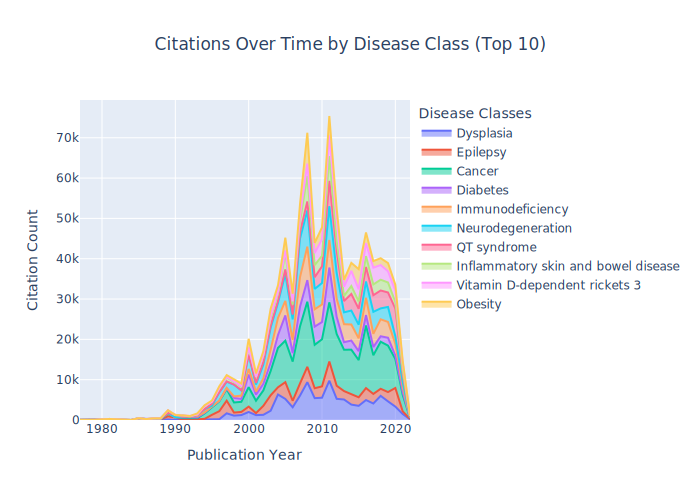

In [16]:
from src.scripts.citations import get_citations_per_year_diseases

citations_time_diseases = get_citations_per_year_diseases(
    disease_citations_df, citations_dict
)
fig = px.area(
    citations_time_diseases,
    x="Year",
    y="Citations",
    color="Disease Classes",
    line_group="Disease Classes",
    title="Citations Over Time by Disease Class (Top 10)",
    labels={"Year": "Publication Year", "Citations": "Citation Count"},
)
fig.update_layout(title_x=0.5)
# fig.show() # Uncomment this line to view the figure interactively

fig.show(renderer="svg")

### Patents Citations

As mentioned previously, key metrics of success are taken from the number of citations of an article or patent, and these metrics are complementary within BindingDB. We previously investigated article citations and how they are linked to disease classes. Here, we dive into patent information and citations.

We now load the `src/data/patents.json` file which was generated using the following script:

```py
from src.scripts.citations import get_patent_info

patents = df["Patent Number"].value_counts()
unique_patents_ordered = patents.index.tolist()
patent_info = []
for patent in unique_patents_ordered:
    patent_info.append(get_patent_info(patent))

with open("patents.json", "w") as f:
    json.dump(patent_info, f)
```

The `get_patent_info` function uses google patents to retrieve the information of interest.

In [26]:
from src.scripts.citations import load_patents

patents_df = load_patents()

In the plot below, we visualize the citation count of the 100 most frequently cited patents in BindingDB.

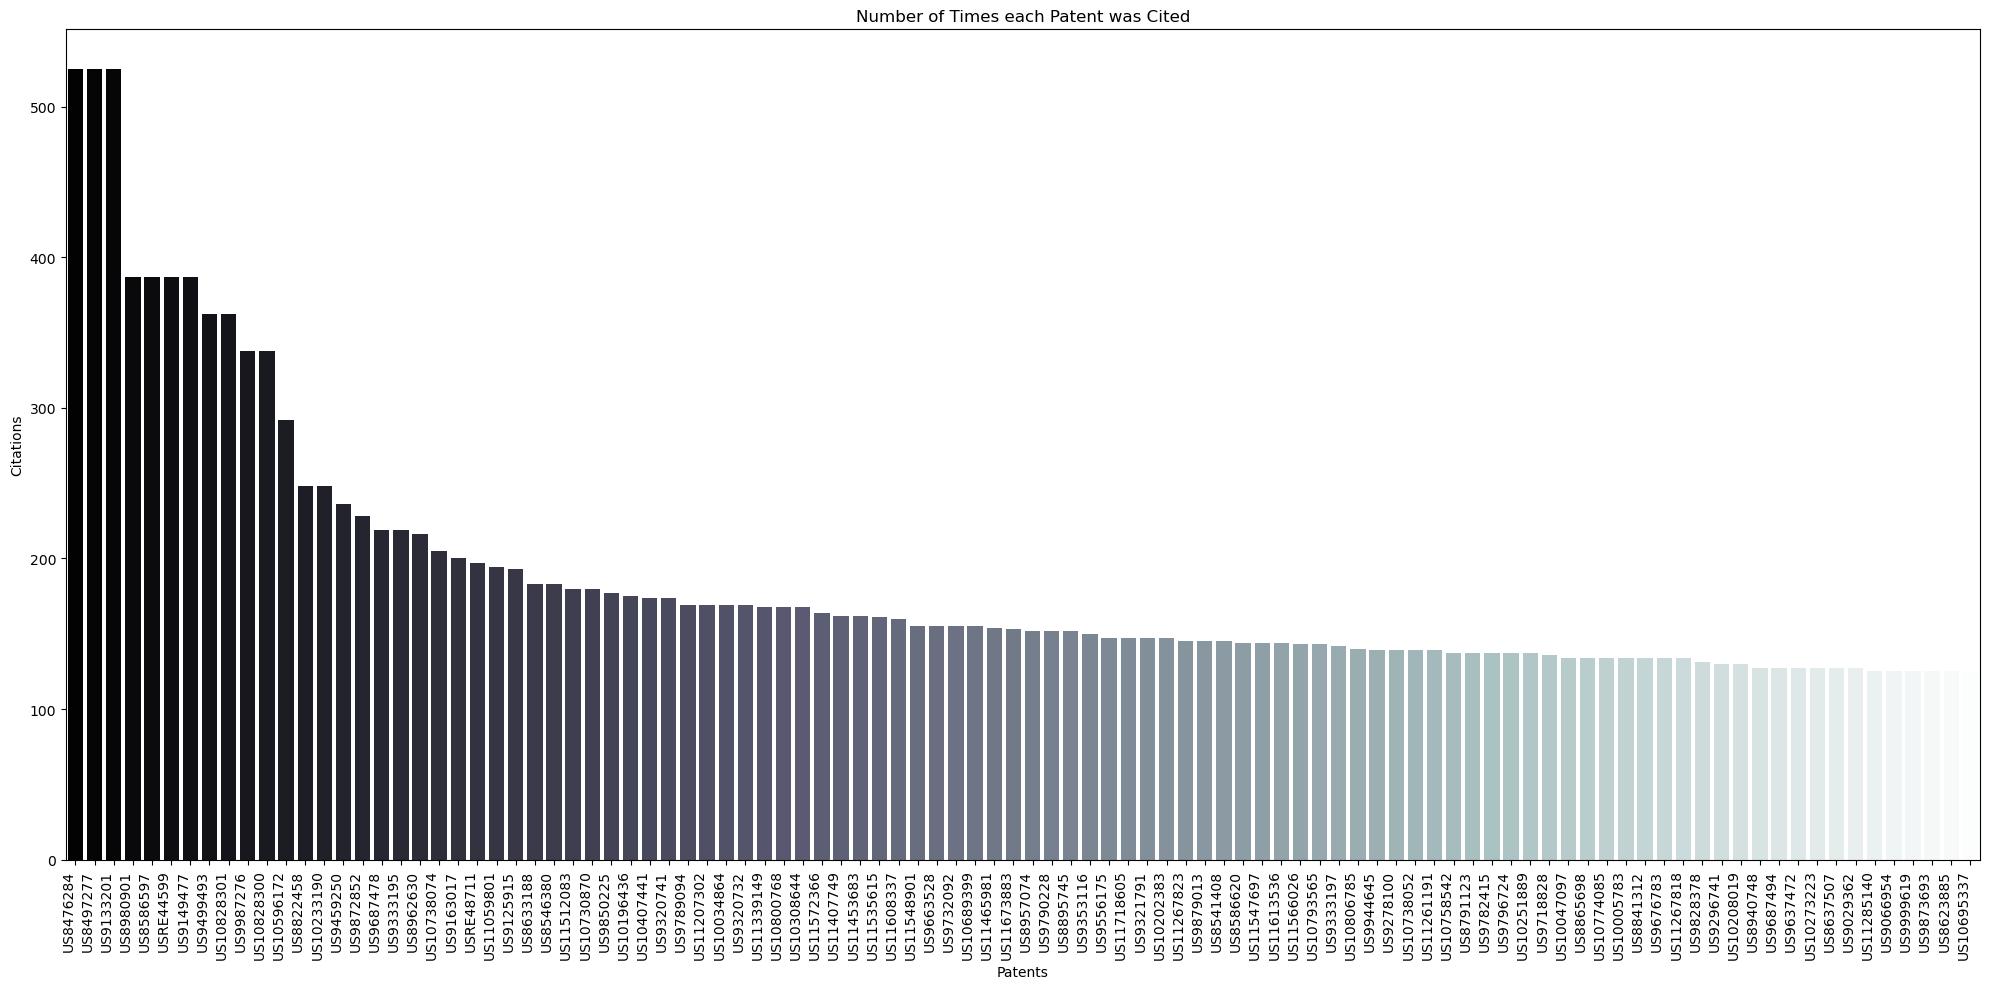

In [27]:
patents_df["total citations"] = patents_df["families citing"] + patents_df["cited by"]
sorted_top_100 = patents_df.sort_values(by="total citations", ascending=False).head(100)
plt.figure(figsize=(20, 10))
sns.barplot(x="patent", y="total citations", data=sorted_top_100, palette="bone")
plt.xticks(rotation=90, ha="right")
plt.xlabel("Patents")
plt.ylabel("Citations")
plt.title("Number of Times each Patent was Cited")
plt.tight_layout()
plt.show()

Similarly to the citations metric, we are now interested in looking at patent citations trends for different disease classes.

In [35]:
from src.scripts.citations import get_patent_citations_per_disease

disease_patents_df = get_patent_citations_per_disease(df, diseases_df, patents_df)

In [36]:
from src.scripts.citations import calculate_patent_H_index_diseases

patents_h_index = calculate_patent_H_index_diseases(disease_patents_df)

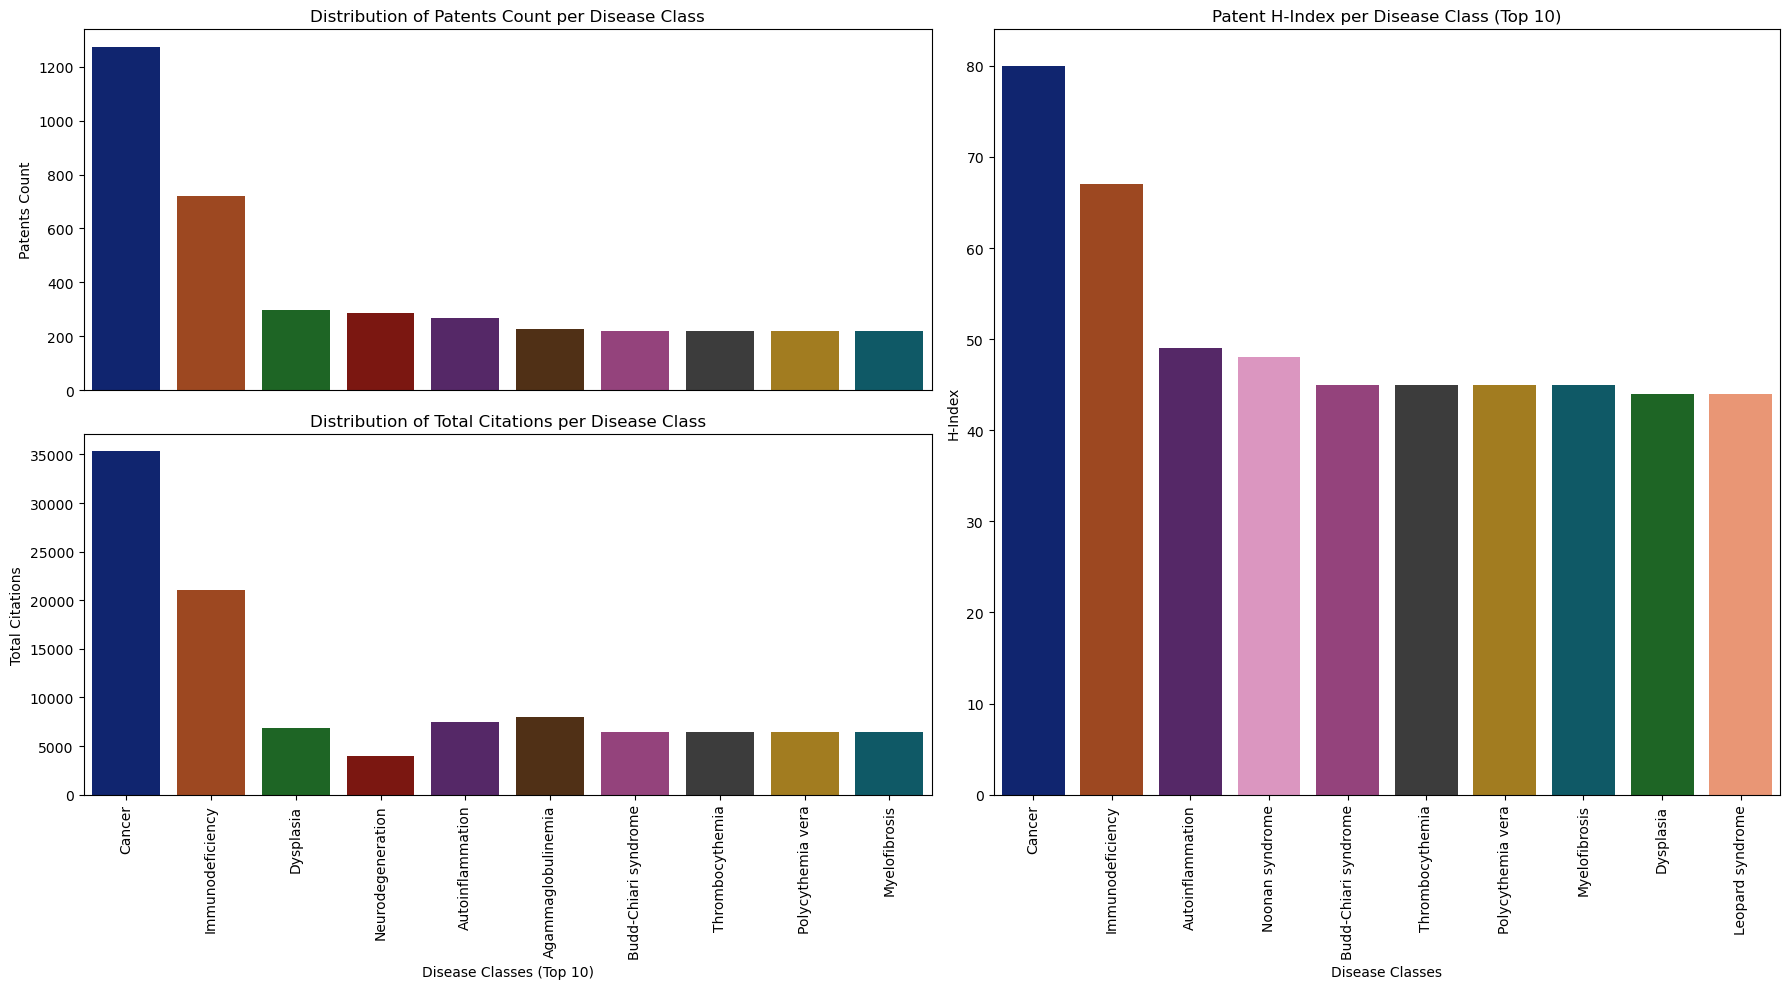

In [37]:
from src.scripts.citations import plot_patents_disease

disease_patents_df["Patents Count"] = disease_patents_df["Patent Number"].apply(len)
disease_patents_df = disease_patents_df.sort_values("Patents Count", ascending=False)
plot_patents_disease(disease_patents_df, patents_h_index)

Consistent with the article citations, cancer is associated with the highest patents citations and count, and has the best H-index value. Interestingly, immunodeficiency appears to be more important in the context of patent citations compared to article citations, while neurodegeneration, previously ranked second, has now been replaced.

However, it is also important to consider patent status. Although a disease may have a lot of associated patents, many of them could in fact be abandonned. Thus, we are now interested in the distribution of different patent statuses across these disease classes.

In [38]:
disease_patents_df["Patent status"] = disease_patents_df["Patent Number"].map(
    lambda patents: patents_df.loc[
        patents_df["patent"].isin(patents), "status"
    ].tolist()
)
status_counts = (
    disease_patents_df.head(100)
    .explode("Patent status")
    .groupby(["Disease Classes", "Patent status"])
    .size()
    .unstack(fill_value=0)
    .drop(columns=["N/A"])
)
top_10_diseases = disease_patents_df.nlargest(10, "Patents Count")["Disease Classes"]
long_data = (
    status_counts.loc[top_10_diseases]
    .reset_index()
    .melt(id_vars="Disease Classes", var_name="Patent Status", value_name="Count")
)

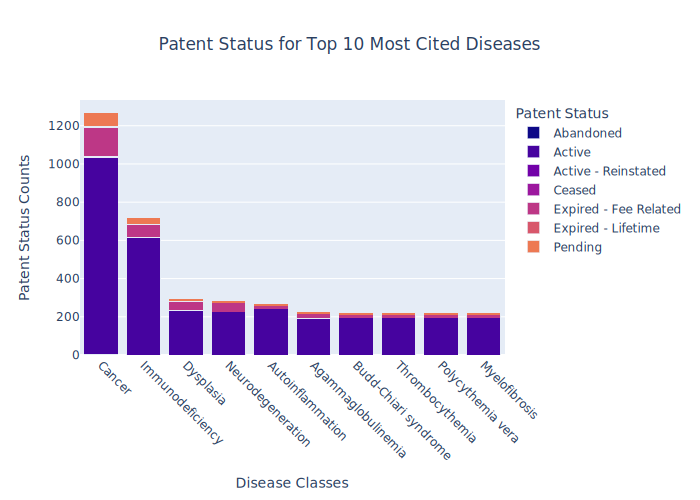

In [39]:
fig = px.bar(
    long_data,
    x="Disease Classes",
    y="Count",
    color="Patent Status",
    title="Patent Status for Top 10 Most Cited Diseases",
    color_discrete_sequence=px.colors.sequential.Plasma,
)
fig.update_layout(
    xaxis_title="Disease Classes",
    yaxis_title="Patent Status Counts",
    legend_title="Patent Status",
    barmode="stack",
    xaxis_tickangle=45,
    title_x=0.5,
)
# fig.show() # Uncomment this line to view the figure interactively

fig.show(renderer="svg")

The above plot confirms that cancer holds a majority of active patents in BindingDB, highlighting the interest and importance placed on this class of diseases.

For drug discovery, knowing how each of these disease classes perform in academia and industry is important. The main objective however, remains success in clinical trials and patients.

## Clinical Trials

The following data was created by running the `src.scripts.clinical_trials` script which contains the following code:

```py
if __name__ == "__main__":
    df = pd.read_csv(
        os.path.join(
            os.path.dirname(os.path.abspath(__file__)),
            "..",
            "..",
            "data",
            "BindingDB_All.tsv",
        ),
        sep="\t",
        usecols=["ZINC ID of Ligand"],
    )
    data_path = os.path.join(
        os.path.dirname(os.path.abspath(__file__)),
        "..",
        "data",
        "ZINC_references_trials.json",
    )
    ids = df["ZINC ID of Ligand"].value_counts().index
    
    get_zinc_clinical_trial_data_for_all_ids(ids, data_path)
```

The above script was indicated to run for 120 hours. The obtained json files can be found in `src/data`. Here, we load and combine all seperately gathered data:

In [3]:
from src.scripts.clinical_trials import combine_trials_json

paths = [
    "src/data/ZINC_references_trials_amel.json",
    "src/data/ZINC_references_trials_daphne.json",
    "src/data/ZINC_references_trials_wes.json",
    "src/data/ZINC_references_trials_greg.json",
    "src/data/ZINC_references_trials_guillaume.json",
]
df_all = combine_trials_json(paths)

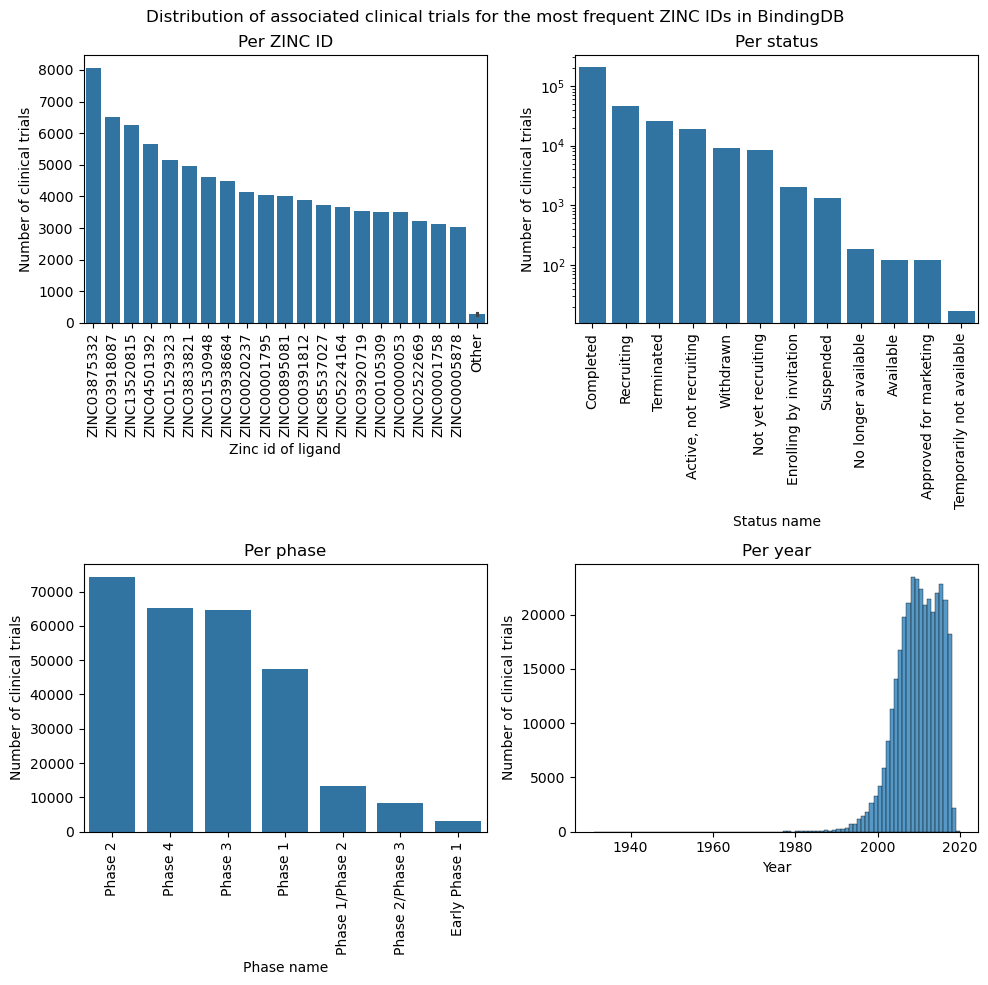

In [41]:
from src.scripts.clinical_trials import plot_clinical_counts

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))
((ax1, ax2), (ax3, ax4)) = axes

ylabel = "Number of clinical trials"
list_kwargs = [
    dict(
        title="Per ZINC ID",
        col="ZINC ID of Ligand",
        ylabel=ylabel,
        top_n=20,
    ),
    dict(
        col="status_name",
        ylabel=ylabel,
        title="Per status",
        top_n=None,
        yscale="log",
    ),
    dict(
        col="phase_name",
        ylabel=ylabel,
        title="Per phase",
        top_n=None,
        yscale=None,
    ),
]

for ax, kwargs in zip(axes.flatten(), list_kwargs):
    plot_clinical_counts(df_all, ax, **kwargs)

sns.histplot(
    df_all["start_date"]
    .dropna()
    .apply(lambda date_str: datetime.date.fromisoformat(date_str).year)
    .to_frame(),
    x="start_date",
    binwidth=1,
    ax=ax4,
)
ax4.set_title("Per year")
ax4.set_xlabel("Year")
ax4.set_ylabel(ylabel)

fig.suptitle(
    "Distribution of associated clinical trials for the most frequent ZINC IDs in BindingDB"
)

plt.tight_layout()
plt.show()

We are now interested in linking the clinical trials to our disease classes of interest. To do so, we will focus on the top 20 most studied and important disease classes discussed in the above sections.

In [42]:
from src.scripts.clinical_trials import classify_disease

df_all["disease_class"] = df_all["description"].apply(classify_disease)
df_diseases = df_all[df_all["disease_class"] != "Unclassified"]
df_diseases = df_diseases.groupby("disease_class").agg(list).reset_index()
df_diseases["number_trials"] = df_diseases["code"].apply(len)
df_diseases = df_diseases.sort_values(by="number_trials", ascending=False)

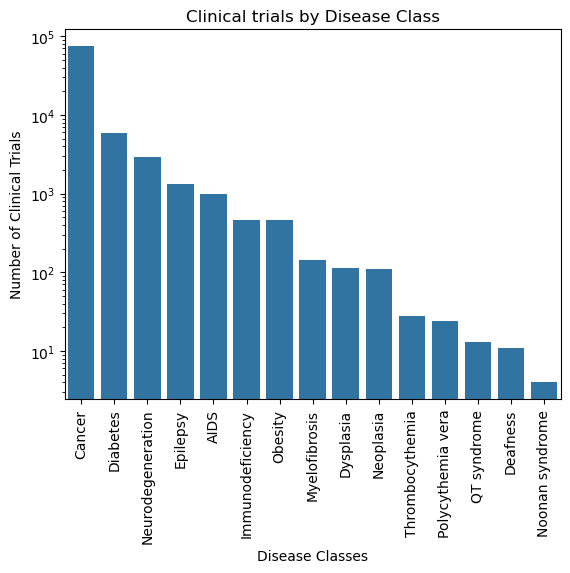

In [43]:
fig, ax = plt.subplots(1, 1)
sns.barplot(
    df_diseases,
    y="number_trials",
    x="disease_class",
    ax=ax,
)
ax.set_yscale("log")
ax.set_xlabel("Disease Classes")
ax.set_ylabel("Number of Clinical Trials")
ax.set_title("Clinical trials by Disease Class")
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.show()

Cancer has the highest number of clinical trials, which highlights, yet again, the importance that is given to the study of this disease class. Interestingly, a lot of trials are also focusing on diabetes. To further investigate all of this, we now dive into the different phases of these trials and how they relate to the diseases.

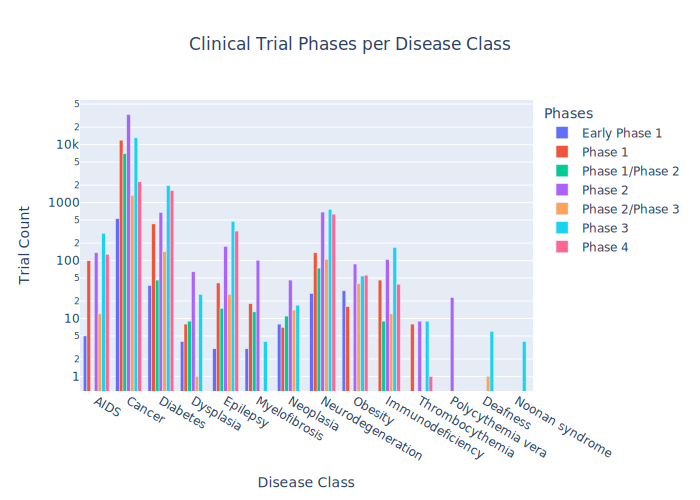

In [44]:
phase_exploded = df_diseases.explode("phase_name")
phase_exploded = (
    phase_exploded.groupby(["phase_name", "disease_class"])
    .size()
    .reset_index(name="count")
)
fig = px.bar(
    phase_exploded,
    x="disease_class",
    y="count",
    color="phase_name",
    barmode="group",
    labels={
        "count": "Trial Count",
        "disease_class": "Disease Class",
        "phase_name": "Phases",
    },
    title="Clinical Trial Phases per Disease Class",
    log_y=True,
)
fig.update_layout(title_x=0.5)
# fig.show() # Uncomment this line to view the figure interactively

fig.show(renderer="svg")

Phase 1 - Assessing initial safety and dosage

Phase 2 - Evaluating effectiveness and side effects

Phase 3 - Confirming efficacy compared to standard treatments

Phase 4 - Ongoing study of long-term effects after approval

While phase 2 trials dominate in cancer, phase 4 trials are especially important to evaluate the real-world success and clinical significance of a study within a disease class. Thus, focusing on phase 4 trials count offers interesting insights into the broader impact of interventions in a specific disease class.

The percentage of clinical trials per phase within each disease class is shown below. 

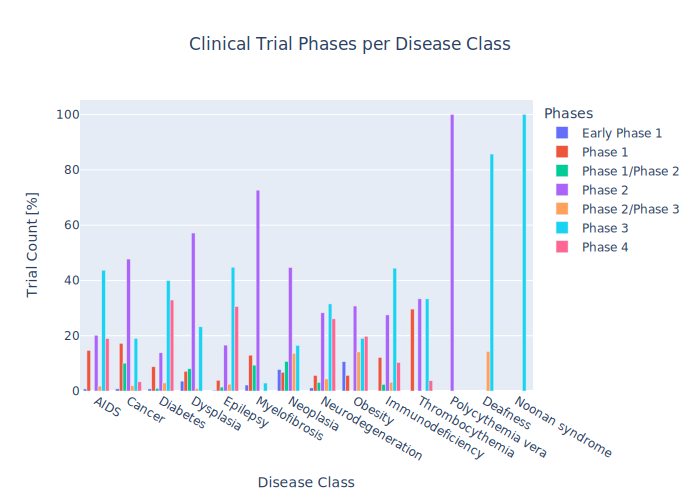

In [45]:
total_counts = phase_exploded.groupby("disease_class")["count"].transform("sum")
phase_exploded["count_percentage"] = (phase_exploded["count"] / total_counts) * 100
fig = px.bar(
    phase_exploded,
    x="disease_class",
    y="count_percentage",
    color="phase_name",
    barmode="group",
    labels={
        "count_percentage": "Trial Count [%]",
        "disease_class": "Disease Class",
        "phase_name": "Phases",
    },
    title="Clinical Trial Phases per Disease Class",
)
fig.update_layout(title_x=0.5)
# fig.show() # Uncomment this line to view the figure interactively

fig.show(renderer="svg")

To get a deeper understanding of clinical trials focus, we are also interested in analyzing these trends over time. Below, we plot the total number of trials and their phases for disease class over the years.

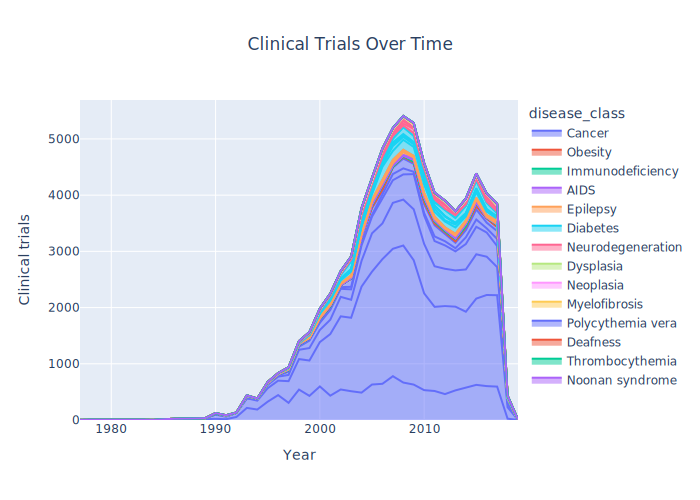

In [46]:
date_exploded = df_diseases.explode(["start_date", "phase_name"])
date_exploded["start_date"] = pd.to_datetime(
    date_exploded["start_date"], errors="coerce"
)
date_exploded["Year"] = date_exploded["start_date"].dt.year
to_plot = (
    date_exploded.groupby(["Year", "phase_name", "disease_class"], as_index=False)
    .size()
    .rename(columns={"size": "count"})
)
fig = px.area(
    to_plot,
    x="Year",
    y="count",
    color="disease_class",
    line_group="phase_name",
    title="Clinical Trials Over Time",
    labels={"Year": "Year", "count": "Clinical trials"},
)
fig.update_layout(title_x=0.5)
# fig.show() # Uncomment this line to view the figure interactively

fig.show(renderer="svg")

However, these clinical trials have different statuses, and some of them are terminated. Thus, to get a complete and accurate overview, analyse how many trials are active, and how many were completed.

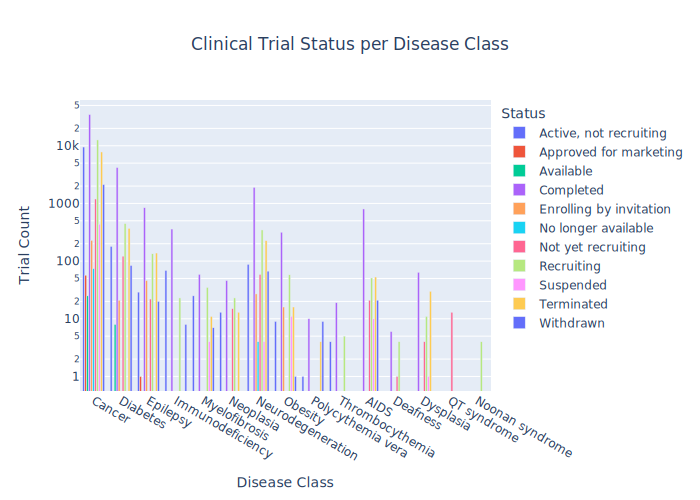

In [47]:
status_exploded = df_diseases.explode("status_name")
status_exploded = (
    status_exploded.groupby(["status_name", "disease_class"])
    .size()
    .reset_index(name="count")
)

fig = px.bar(
    status_exploded,
    x="disease_class",
    y="count",
    color="status_name",
    barmode="group",
    labels={
        "count": "Trial Count",
        "disease_class": "Disease Class",
        "status_name": "Status",
    },
    title="Clinical Trial Status per Disease Class",
    log_y=True,
)
fig.update_layout(title_x=0.5)
# fig.show() # Uncomment this line to view the figure interactively

fig.show(renderer="svg")

Below, we visualize again the trials trends over time, taking only the completed ones into account.

In [48]:
from src.scripts.clinical_trials import filter_completed_trials

filtered = df_diseases.apply(filter_completed_trials, axis=1)
completed_df = pd.DataFrame(filtered.tolist())

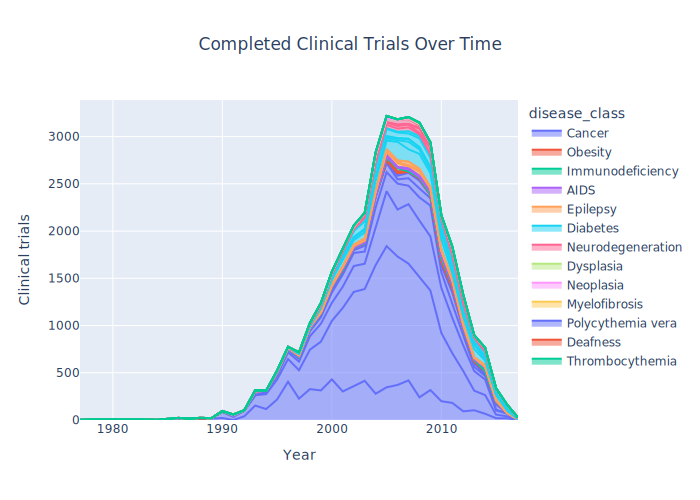

In [49]:
date_exploded = completed_df.explode(["start_date", "phase_name"])
date_exploded["start_date"] = pd.to_datetime(
    date_exploded["start_date"], errors="coerce"
)
date_exploded["Year"] = date_exploded["start_date"].dt.year
to_plot = (
    date_exploded.groupby(["Year", "phase_name", "disease_class"], as_index=False)
    .size()
    .rename(columns={"size": "count"})
)
fig = px.area(
    to_plot,
    x="Year",
    y="count",
    color="disease_class",
    line_group="phase_name",
    title="Completed Clinical Trials Over Time",
    labels={"Year": "Year", "count": "Clinical trials"},
)
fig.update_layout(title_x=0.5)
# fig.show() # Uncomment this line to view the figure interactively

fig.show(renderer="svg")

Most notably, completed compared to all clinical trials show a rapid decrease in numbers as of 2008-2009. A direct conclusion, irrespective of diseases, is that clinical trials take much time to complete, around 5 years, if not more. The clinical phase of drug discovery therefore represents a major hurdle in the process of drug discovery.

---

# Target Protein Classification

On top of classifying diseases, it is also necessary to classify ligands. Indeed, a key question in drug discovery is choosing an adequat target for the disease studied.

To do so, we first standardize the characters to lower case in the 'Target Name' field to improve browsing and searchability. Thereafter, we classify target proteins based on biological knowledge.

In [42]:
names_df = pd.read_csv(
    "data/BindingDB_All.tsv",
    sep="\t",
    usecols=[
        "UniProt (SwissProt) Recommended Name of Target Chain",
        "UniProt (TrEMBL) Submitted Name of Target Chain",
        "Article DOI",
        "Patent Number",
    ],
)

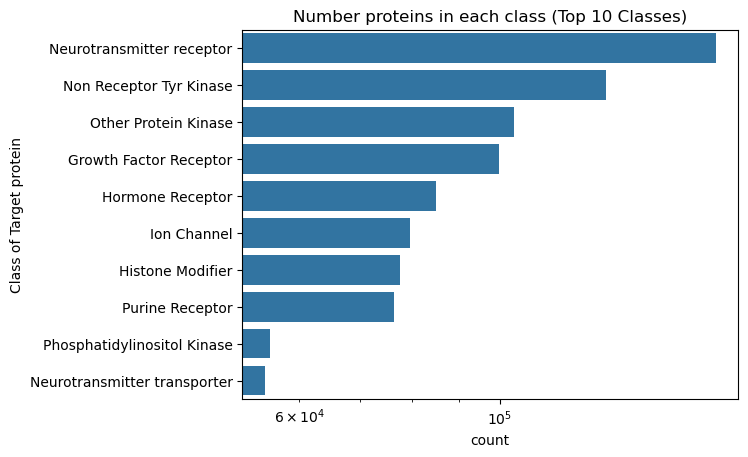

In [43]:
mapped_names = targets.get_target_class(names_df=names_df)
fig, ax = plt.subplots(1, 1)
plot_df = mapped_names.value_counts().reset_index()
sns.barplot(
    plot_df,
    y="UniProt (SwissProt) Recommended Name of Target Chain",
    x="count",
    order=plot_df.loc[:9, "UniProt (SwissProt) Recommended Name of Target Chain"],
    ax=ax,
)
ax.set_xscale("log")
ax.set_ylabel("Class of Target protein")
ax.set_title("Number proteins in each class (Top 10 Classes)")
plt.show()

As shown in the above figure, we observe main classes of target proteins with high counts within BindingDB.

**1. Neurotransmitter Receptor**
   - These are membrane proteins that mediate the action of neurotransmitters, which are chemicals that transmit signals in the nervous system.

**2. Non-Receptor Tyrosine Kinase**
   - These enzymes transfer phosphate groups to tyrosine residues on target proteins, playing crucial roles in cellular signaling. Unlike receptor tyrosine kinases, they are not embedded in the cell membrane.

**3. Other Protein Kinase**
   - This group includes various protein kinases other than tyrosine kinases, such as serine/threonine kinases, which are involved in a wide range of cellular processes.

**4. Growth Factor Receptor**
   - These receptors bind growth factors and activate signaling pathways that regulate cell growth, survival, and differentiation.

**5. Hormone Receptor**
   - These receptors respond to hormone molecules and regulate gene expression. They are usually located in the cell nucleus or on the cell surface.

**6. Ion Channel**
   - Ion channels are membrane proteins that allow the flow of ions (e.g., sodium, potassium, calcium) across the cell membrane, critical for neuronal signaling and muscle contraction.

**7. Histone Modifier**
   - These enzymes modify histones (proteins around which DNA is wound) and influence gene expression by altering chromatin structure. Common modifications include acetylation, methylation, and phosphorylation.

**8. Purine Receptor**
   - These are cell surface receptors that respond to purines like ATP, ADP, and adenosine, which are signaling molecules involved in energy transfer and metabolism.

**9. Phosphatidylinositol Kinase**
   - These kinases are involved in phosphoinositide metabolism and signaling, impacting various cellular processes including growth and survival.

**10. Neurotransmitter Transporter**
   - These are proteins responsible for the reuptake or transport of neurotransmitters across cell membranes, helping regulate neurotransmitter levels in synaptic clefts.

### Article Citations

As with disease classes, to gain a more comprehensive understanding of research focus on various target classes, we now analyse citations trends.

In [47]:
from src.scripts.citations import get_citations_per_target

target_citations_df = get_citations_per_target(names_df, citations_dict, mapped_names)

In [48]:
from src.scripts.citations import calculate_H_index_targets

target_h_index_df = calculate_H_index_targets(target_citations_df)

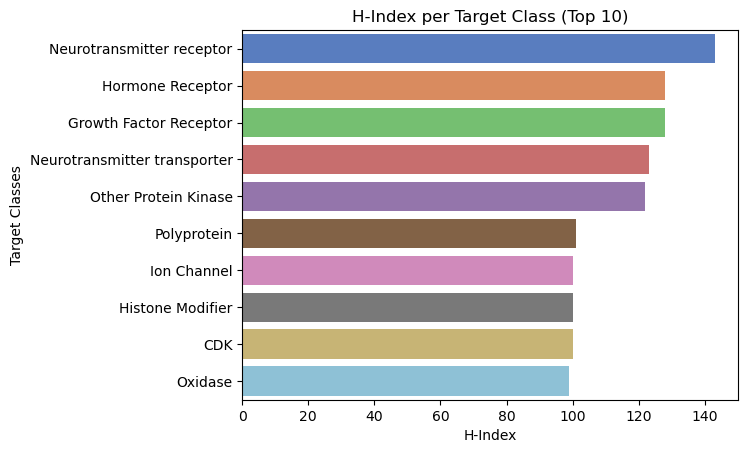

In [49]:
fig, ax = plt.subplots(1, 1)
sns.barplot(
    target_h_index_df.head(10), y="Target Classes", x="H-Index", ax=ax, palette="muted"
)
ax.set_title("H-Index per Target Class (Top 10)")
plt.show()

Neurotransmitter receptors show the highest H-index. Overall, the top ten most important target classes seen in the previous plot are majoritarily the same ones we see here, with the highest H-index.

To get a deeper understanding of citations and research focus for each target class, we are also interested in analyzing these trends over time. Below, we compute and plot the total number of citations each target class has received over the years.

In [50]:
from src.scripts.citations import get_citations_per_year_targets

doi_metadata = pd.read_csv("src/data/metadata.csv").dropna()
doi_year_dict = dict(zip(doi_metadata["Article DOI"], doi_metadata["year"]))
target_citations_df["Publication Years"] = target_citations_df["Citations"].apply(
    lambda x: get_citations_per_year_targets(x, doi_year_dict)
)
target_citations_10 = target_citations_df[
    target_citations_df["Target Classes"].isin(
        target_h_index_df.head(10)["Target Classes"].to_list()
    )
]

In [51]:
from src.scripts.citations import aggregate_citations_by_year_target

df_to_plot = aggregate_citations_by_year_target(target_citations_10)

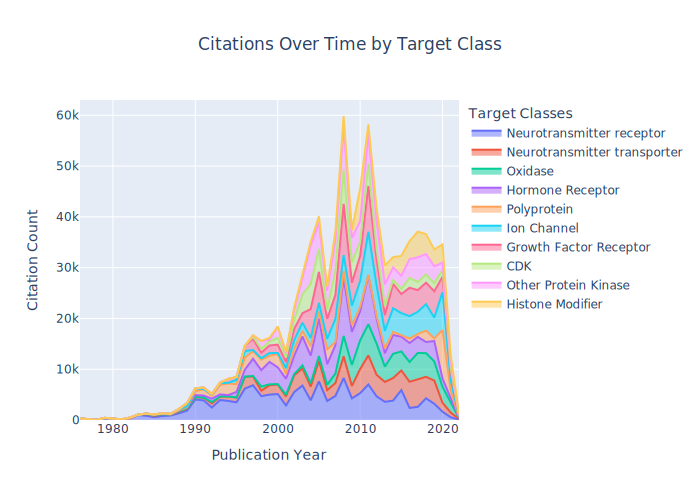

In [52]:
fig = px.area(
    df_to_plot,
    x="Year",
    y="Citations",
    color="Target Classes",
    line_group="Target Classes",
    title="Citations Over Time by Target Class",
    labels={"Year": "Publication Year", "Citations": "Citation Count"},
)
fig.update_layout(title_x=0.5)

# fig.show() # Uncomment this line to view the figure interactively

fig.show(renderer="svg")

### Patents Citations

Now that we have investigated article citations and how they are linked to target classes, we are interested in exploring how patent citations and target classes are linked.

Similarly to disease classes, we investigate which target classes show a higher patent H-index.

In [19]:
from src.scripts.citations import get_patent_citations_per_targets

target_patent_citations = get_patent_citations_per_targets(
    names_df, mapped_names, patents_df
)

In [27]:
from src.scripts.citations import calculate_patent_H_index_targets

target_patent_h_index = calculate_patent_H_index_targets(target_patent_citations)

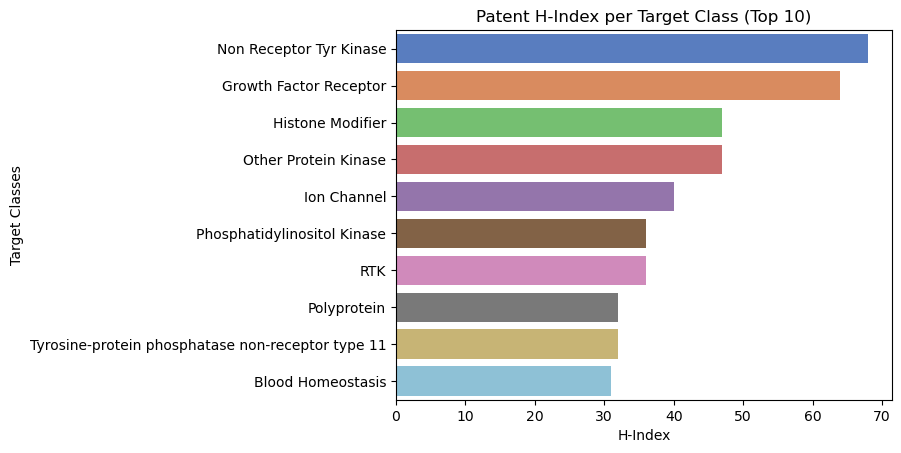

In [28]:
fig, ax = plt.subplots(1, 1)
sns.barplot(
    target_patent_h_index.head(10),
    y="Target Classes",
    x="H-Index",
    ax=ax,
    palette="muted",
)
ax.set_title("Patent H-Index per Target Class (Top 10)")
plt.show()

---

# Molecular and Chemical Features

In [57]:
import pandas as pd
import numpy as np

from src.scripts import smiles
from src.scripts import targets
from src.utils import utils

%load_ext autoreload

# plotting tools
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import plotly.graph_objects as go
from matplotlib.patches import Patch

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import numpy as np
from sklearn.mixture import GaussianMixture
from scipy.cluster.hierarchy import linkage, dendrogram

# rdkit tools
from rdkit import Chem
from rdkit.Chem import AllChem, DataStructs, Descriptors, Draw

# Taxonomy
from ete3 import NCBITaxa

import pandas as pd
import json
from tqdm import tqdm
import seaborn as sns


from sklearn.cluster import DBSCAN

In [58]:
mol_df = (
    pd.read_csv(
        "data/BindingDB_All.tsv",
        sep="\t",
        usecols=[
            "BindingDB Reactant_set_id",
            "Ligand SMILES",
            "BindingDB Ligand Name",
        ],
    )
    .dropna()
    .sample(10000, random_state=0)
)
mol_df.head()

BindingDB Reactant_set_id  \
710434                      726690   
1663970                   50281492   
544012                      555691   
280988                      281011   
300927                      300950   

                                             Ligand SMILES  \
710434   NS(=O)(=O)c1c(ccc(-c2ccc(O)nc2)c1-c1nnn[nH]1)S...   
1663970  CO[C@@H]1C[C@H](N(C1)C(=O)NCc1ccc(cc1Cl)C(=O)N...   
544012   Nc1ncnc2n(nc(C(=O)Nc3nc4cc(F)ccc4o3)c12)[C@@H]...   
280988               Cc1ncncc1-c1ccnc2c(csc12)-c1ccc(F)cc1   
300927          NC(=O)c1ccc(cc1)C1CC1C(=O)N1CCN(CC1)C1CCC1   

                                     BindingDB Ligand Name  
710434   3-((4-(6-hydroxypyridin- 3-yl)-2-sulfamoyl-3-(...  
1663970  (2S,4R)-4-Methoxy-2-(4-methyl-[1,4]diazepane-1...  
544012                               US9580432, Example 12  
280988                        US8969586, 98::US9598436, 98  
300927         US9029381, 42::US9029381, 43::US9029381, 44

## Chemical Properties

[17:31:27] Can't kekulize mol.  Unkekulized atoms: 1 2 6
[17:31:27] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 12 13 14 15 16
[17:31:28] Explicit valence for atom # 30 N, 4, is greater than permitted
[17:31:28] Explicit valence for atom # 15 N, 4, is greater than permitted
[17:31:28] Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 13
[17:31:29] Explicit valence for atom # 17 O, 3, is greater than permitted
[17:31:29] Can't kekulize mol.  Unkekulized atoms: 18 19 21 22 24
[17:31:29] Explicit valence for atom # 32 N, 4, is greater than permitted
[17:31:29] Can't kekulize mol.  Unkekulized atoms: 25 26 27 28 29 30 32 33 34
[17:31:29] Explicit valence for atom # 29 N, 4, is greater than permitted
[17:31:30] Can't kekulize mol.  Unkekulized atoms: 1 2 6
[17:31:30] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 12 13 14 15 16
[17:31:30] Explicit valence for atom # 30 N, 4, is greater than permitted
[17:31:31] Explicit valence for atom # 15 N, 4, is greater than permitted
[17:31:

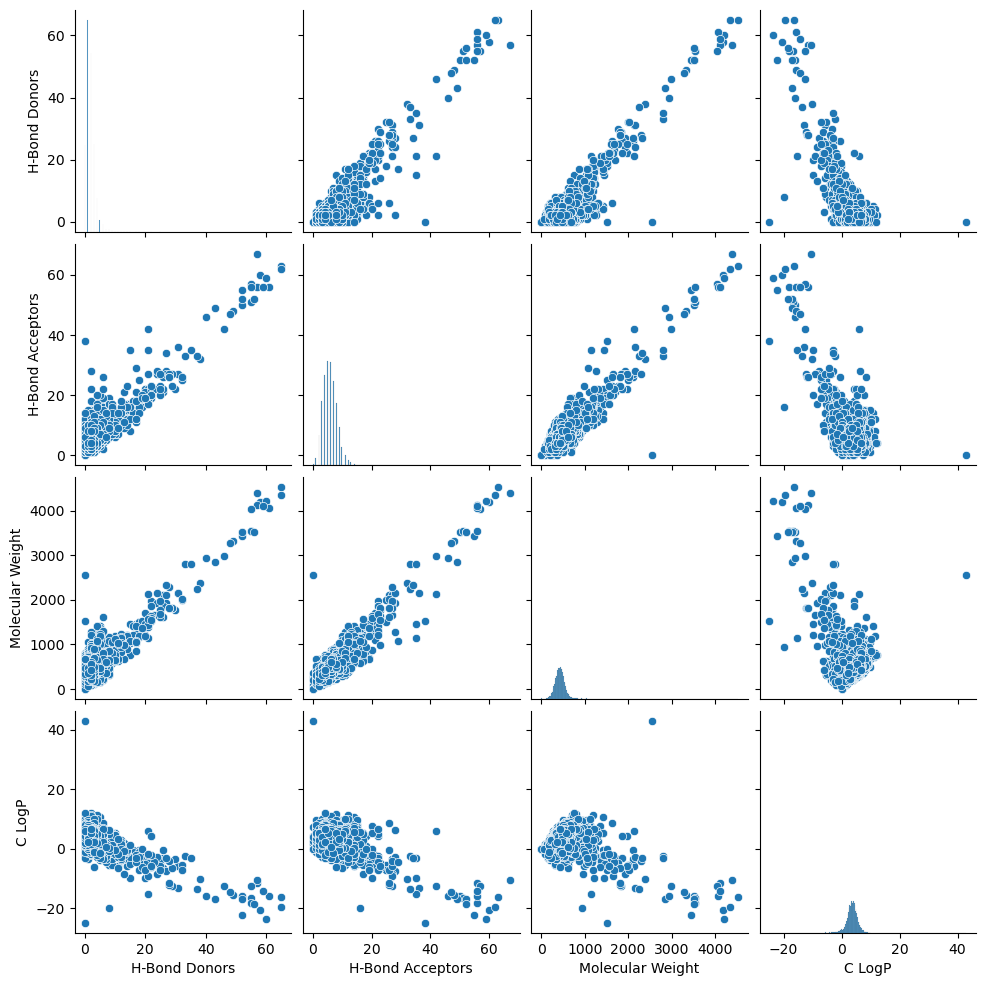

In [41]:
mol_df["H-Bond Donors"] = mol_df["Ligand SMILES"].apply(smiles.get_Hdonors)
mol_df["H-Bond Acceptors"] = mol_df["Ligand SMILES"].apply(smiles.get_Hacceptors)
mol_df["Molecular Weight"] = mol_df["Ligand SMILES"].apply(smiles.get_MW)
mol_df["C LogP"] = mol_df["Ligand SMILES"].apply(smiles.get_LogP)
sns.pairplot(
    mol_df, vars=["H-Bond Donors", "H-Bond Acceptors", "Molecular Weight", "C LogP"]
)

The scatter plot matrix (or pair plot) in this analysis visualizes the relationships between four molecular properties: H-Bond Donors, H-Bond Acceptors, Molecular Weight, and C LogP for a set of ligands.

We explain here these variables:
- H-Bond Donors: Number of hydrogen bond donor sites on the molecule.
- H-Bond Acceptors: Number of hydrogen bond acceptor sites.
- Molecular Weight: The molecular weight of each molecule.
- C LogP: The calculated partition coefficient (logarithm of the ratio of a compound's concentration in octanol vs. water), which is an indicator of hydrophobicity.
Interpretation and Observations:

**H-Bond Donors/Acceptors vs. Molecular Weight**: Both H-Bond Donors and H-Bond Acceptors show a strong positive correlation with Molecular Weight. This suggests that as the molecular weight increases, the molecule tends to have more sites for hydrogen bonding, likely due to increased molecular complexity.

**H-Bond Donors vs. H-Bond Acceptors**: The plot shows a positive correlation between H-Bond Donors and H-Bond Acceptors. Molecules with a high number of donor sites tend to also have a high number of acceptor sites. This is logical, as larger or more complex molecules often have both types of functional groups.

**H-Bond Donors/Acceptors vs. C LogP**: There appears to be a weak to moderate inverse relationship between both hydrogen bond donors/acceptors and C LogP. Molecules with higher hydrogen bonding capabilities (more H-Bond Donors/Acceptors) tend to be more hydrophilic, which is reflected in lower C LogP values (indicating lower lipophilicity).

**Molecular Weight vs. C LogP**: This relationship is more dispersed. Higher molecular weight molecules do not necessarily have a consistent C LogP trend, but there appears to be a wider range of lipophilicity in larger molecules. This variability could be due to the diversity in functional groups or molecular structures within the sample.

This analysis highlights some expected relationships between molecular properties. Indeed, molecules with more complex structures (higher molecular weight) are likely to have more hydrogen bond donors and acceptors, suggesting a greater potential for interactions through hydrogen bonding.
The inverse relationship between hydrogen bonding capabilities and C LogP is in line with the typical properties of hydrophilic and lipophilic compounds, where molecules with more hydrogen bonding sites are generally less lipophilic.

Overall, this exploratory visualization can help identify potential clustering or trends within the dataset, which can be useful in understanding molecular behavior, predicting solubility, permeability, or guiding structure-activity relationship (SAR) analysis in drug discovery.

## Lipinski's Rule
Lipinski's rule of five is a rule of thumb to evaluate drug likeness or determine if a chemical compound with a certain pharmacological or biological activity has chemical properties and physical properties that would likely make it an orally active drug in humans. The 
- No more than 5 H bonds donors
- No more than 10 H bond acceptors
- A molecular mass less than 500 Daltons
- A calculated octanol-water partition coefficient (Clog P) that does not exceed 5

[17:31:46] Can't kekulize mol.  Unkekulized atoms: 1 2 6


Invalid SMILES string.


[17:31:47] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 12 13 14 15 16


Invalid SMILES string.


[17:31:47] Explicit valence for atom # 30 N, 4, is greater than permitted


Invalid SMILES string.


[17:31:50] Explicit valence for atom # 15 N, 4, is greater than permitted


Invalid SMILES string.


[17:31:51] Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 13


Invalid SMILES string.


[17:31:51] Explicit valence for atom # 17 O, 3, is greater than permitted


Invalid SMILES string.


[17:31:52] Can't kekulize mol.  Unkekulized atoms: 18 19 21 22 24


Invalid SMILES string.


[17:31:52] Explicit valence for atom # 32 N, 4, is greater than permitted


Invalid SMILES string.


[17:31:53] Can't kekulize mol.  Unkekulized atoms: 25 26 27 28 29 30 32 33 34
[17:31:54] Explicit valence for atom # 29 N, 4, is greater than permitted


Invalid SMILES string.
Invalid SMILES string.


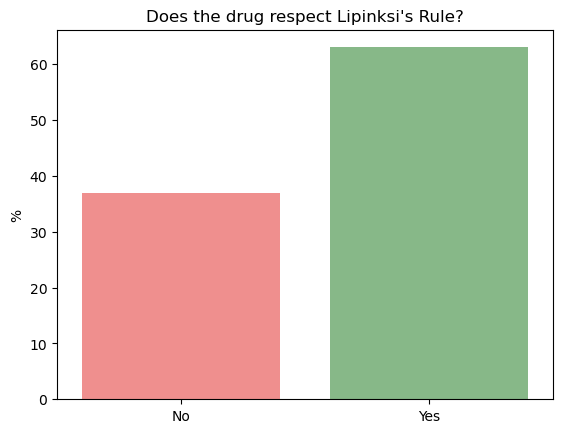

In [42]:
mol_df["Lipinski"] = mol_df["Ligand SMILES"].apply(smiles.lipinski)
ax = sns.countplot(
    mol_df,
    x="Lipinski",
    stat="percent",
    hue="Lipinski",
    palette=["#ff7f7e", "#7fc080"],
    legend=False,
)
ax.set_title("Does the drug respect Lipinksi's Rule?")
ax.set_xticklabels(["No", "Yes"])
ax.set_xlabel("")
ax.set_ylabel("%")
plt.show()

We observe a majority of drugs that respect Lipinski's rule. There are many other similar rules for drug likeness, such as Ghose filter, Veber's Rule... Other chemical properties such as number of rotatable bonds and polar surface area have been shown to influence oral bioavailability. Further analysis of the chemical features revolve around these features and rules to determine their relationship to the success metrics. Such analysis is conducted in the present section.

## Cheng-Prusoff Clustering

In the presentation of the Binding Kinetics, we briefly introduced the relation between between Ki and IC50 through the Cheng-Prusoff equation: $$IC50 = Ki(1+[S]/Km)$$ Here, we dive deeper into this biochemical relation, to investigate whether success in drug discovery is affected by these kinetics.

Remembering the introduction of this relation above, we observed a linear relation between both metrics on a log-log scale, with a slope of 0.93, an intercept of -1.49 and an explained variance of $R_{adj}^2=0.66$. However, we noticed that the fit of the regression would probably be increased by seperating the two visible clusters, which we hypothesised could be due to different binding mechanisms, or experimental paradigm. Thus, we investigate how to seperate these clusters here.

A first idea, based on the non-spherical shapes of the clusters, is to seperate the data using gaussian mixture models (GMM).

In [5]:
from src.scripts import cheng_prusoff_classification as cp

In [6]:
# select for cheng prusoff
usecols = [
    "Ki (nM)",
    "IC50 (nM)",
]

# load data
df_cp = pd.read_csv(
    r"data/BindingDB_All.tsv",
    sep="\t",
    usecols=usecols,
)

# clean data
df_cp.replace(" NV,", np.nan, inplace=True)
for col in df_cp.columns:
    df_cp[col] = df_cp[col].astype(str).str.replace(" C", "")
    df_cp[col] = (
        df_cp[col].astype(str).str.replace(">", "").str.replace("<", "").astype(float)
    )

# prepare data for cheng-prusoff
both_log = cp.cheng_prusoff_data(df_cp)

### GMM clustering

Here, we perform GMM clustering followed by regression on the identified clusters.

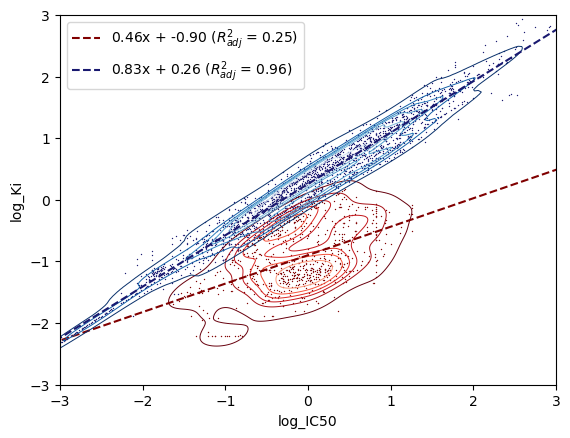

In [7]:
ssc = StandardScaler().set_output(transform="pandas")
both_log_norm = ssc.fit_transform(both_log)
gmf = GaussianMixture(n_components=2, random_state=11)
both_log_norm["GMM"] = gmf.fit_predict(both_log_norm)

## seperate outliers from cluster
cluster_two = both_log_norm.query("GMM == 0")

gm2 = GaussianMixture(n_components=2, random_state=11)
cluster_two["GMM2"] = gm2.fit_predict(cluster_two)
cluster_two["GMM2"] -= 1

final = pd.concat([both_log_norm, cluster_two], axis=0).fillna(0)
final["cluster"] = final["GMM"] + final["GMM2"] + 1
final.drop(columns=["GMM", "GMM2"], inplace=True)

fam1 = final.query("cluster == 0")
fam2 = final.query("cluster == 2")
fam_out = final.query("cluster == 1")
fams = [fam1, fam2]

reg1 = cp.cheng_prusoff_model(fam1)
reg2 = cp.cheng_prusoff_model(fam2)
regs = [reg1, reg2]

fig, ax = plt.subplots(1, 1)
cp.cheng_prusoff_plot(fams, regs, ax=ax)
ax.set_xlim(-3, 3)
ax.set_ylim(ax.get_xlim())
plt.legend()
plt.show()

As we observe, the GMM clustering yields clusters for which one cluster shows a large explained variance (in blue; $R_{adj}^2=0.96$). However, the clustering is clearly not biochemically relevant, has the second cluster has a very poor fit (in red; $R_{adj}^2=0.25$).

We therefore return to the Cheng-Prusoff Relation, to search for a biochemically-informed method to seperating the clusters.

### Biochemically-Informed Classification

This classification relies on the Cheng-Prusoff relation. Derived on a log-log scale, we obtain:
$$log(IC_{50} = log(K_i) + log(1 + [S]/K_M))$$
Thus, we expect the slope and intercept of the cluster to be: $a=1$ and $b=log(1 + [S]/K_M)$
However, as mentioned both the experimental paradigm and the mechanism of action can change the intercept. The experimental paradigm generally changes the concentration of substrate [S], modifying the intercept. A change in mechanism of action generally modifies the Cheng-Prusoff equation to: $$log(IC_{50} = log(K_i) + log(1 + K_M/[S]))$$
In both cases, the slope remains at $a=1$, with the only change occuring in the interecpt.

The main foundation of the classifier we build here is therefore based on this change. In particular, we create a seperator with fixed slope $a=1$, and vary its intercept to:
- Maximise the difference in intercept between both populations
- Minimise the difference in their slopes

This is implemented in `cheng_prusoff_classification.py`, where the main algorithm functions as follows:
- For each intercept
    - Assign labels
    - Perform OLS linear regression on both clusters
    - Calculate the difference in intercept and slope
- Choose classifier with interecpt which satisfies the points above.



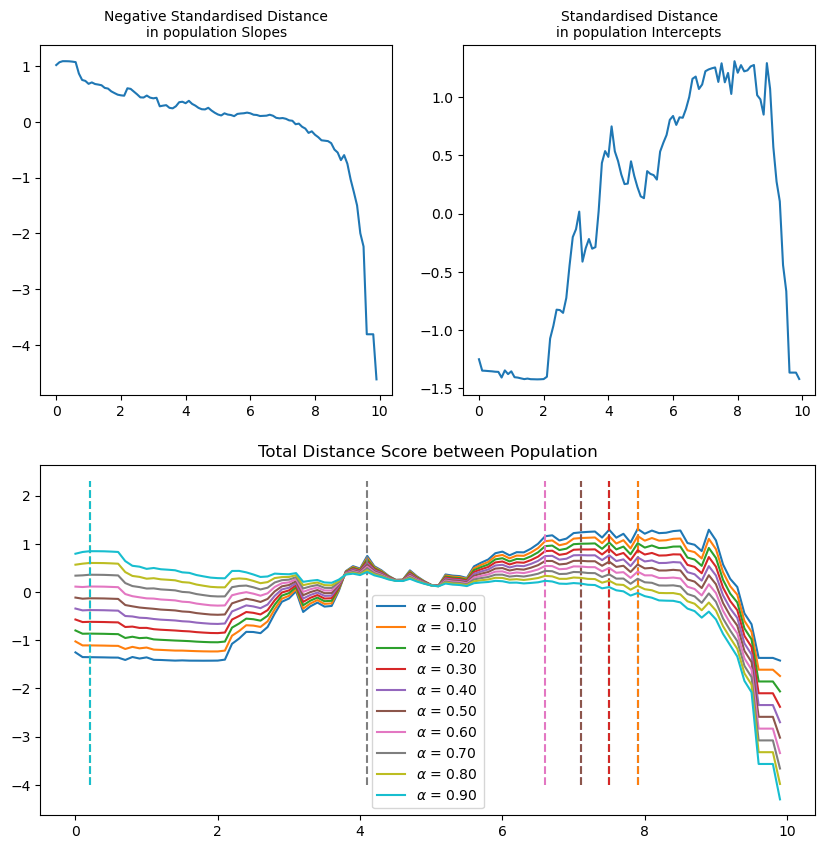

In [8]:
b_max = cp.cheng_prusoff_classifier(
    df=both_log, min_seperator_interecpt=0, show_evaluation=True
)

The choice of the best slope therefore relies on two scores. These are shown, standardised, as a function of the classifiers intercept in the two first plots above. The metric we optimise on is a weighted sum of both: $$metric = \alpha*\delta_{slope}+(1-\alpha)*\delta_{intercept}$$
Thus, $\alpha$ represents the importance of having similar slopes, and giving less importance of different intercepts. 
We rely on the bottom plot above, to choose the optimal $\alpha$ balancing both metrics. This is observed at around $\alpha$ = 0.71, where the optimal classifier intercept is slightly above $b=4$. To verify this is indeed the optimal classifier, we plot representative plots for difference values of $\alpha$.

Regression results per cluster for alpha=0.71


'Red cluster:'

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 log_Ki   R-squared:                       0.564
Model:                            OLS   Adj. R-squared:                  0.564
Method:                 Least Squares   F-statistic:                     694.4
Date:                Thu, 19 Dec 2024   Prob (F-statistic):           8.85e-99
Time:                        13:56:17   Log-Likelihood:                -961.40
No. Observations:                 538   AIC:                             1927.
Df Residuals:                     536   BIC:                             1935.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -5.0166      0.188    -26.701      0.000      -5.386      -4.647
log_IC50       0.7282      0.028     26.351      0.000       0.674       0.783
==============================================================================
Omnibus:                       77.351   Durbin-Watson:                   0.950
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              242.270
Skew:                          -0.665   Prob(JB):                     2.46e-53
Kurtosis:                       6.006   Cond. No.                         20.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

'Blue cluster:'

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 log_Ki   R-squared:                       0.910
Model:                            OLS   Adj. R-squared:                  0.910
Method:                 Least Squares   F-statistic:                 2.666e+04
Date:                Thu, 19 Dec 2024   Prob (F-statistic):               0.00
Time:                        13:56:17   Log-Likelihood:                -4230.7
No. Observations:                2639   AIC:                             8465.
Df Residuals:                    2637   BIC:                             8477.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.7189      0.043    -16.782      0.000      -0.803      -0.635
log_IC50       0.9634      0.006    163.285      0.000       0.952       0.975
==============================================================================
Omnibus:                      674.587   Durbin-Watson:                   0.630
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5238.534
Skew:                           0.992   Prob(JB):                         0.00
Kurtosis:                       9.611   Cond. No.                         13.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

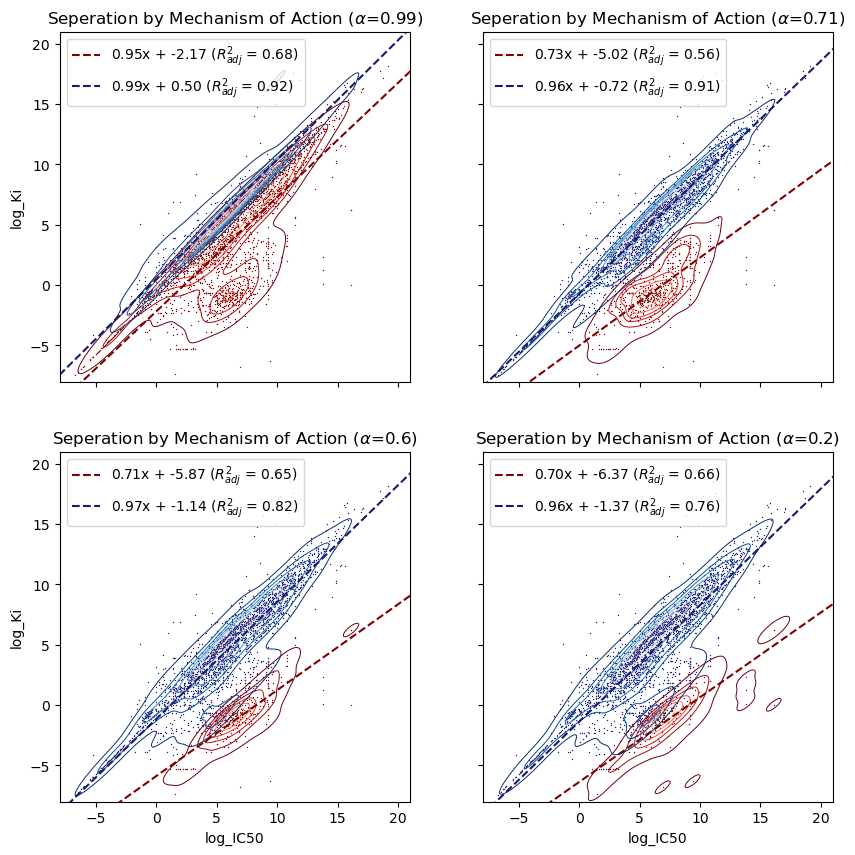

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10), sharex=True, sharey=True)
for alpha, ax in zip([0.99, 0.71, 0.6, 0.2], axs.flat):
    # results with optimal seperator
    m = 1
    b = b_max[alpha]

    # assign labels with optimal seperator intercept; cluster 1 = below line
    both_log["label"] = (both_log["log_IC50"] < m * both_log["log_Ki"] + b).astype(int)
    fam0 = both_log.query("label == 0")
    fam1 = both_log.query("label == 1")

    # model per cluster
    res0 = cp.cheng_prusoff_model(fam0)
    res1 = cp.cheng_prusoff_model(fam1)

    # regression results for best classifier
    if alpha == 0.71:
        print(f"Regression results per cluster for alpha={alpha}")
        display("Red cluster:", res0.summary())
        display("Blue cluster:", res1.summary())

    # plot
    cp.cheng_prusoff_plot([fam0, fam1], [res0, res1], ax=ax)
    ax.set_xlim(-8, 21)
    ax.set_ylim(ax.get_xlim())
    ax.set_aspect("equal", adjustable="box")
    ax.set_title(rf"Seperation by Binding Kinetics ($\alpha$={alpha})")
    ax.legend()
plt.show()

Compared to the GMM, this biochemically-informed classification firstly produces visually better clusters, notably identified by the satisfactory KDE density lines. Mathematically, the seperation, as a whole explains the data better. Indeed, for the blue cluster, the $R_{adj}^2$ only diminishes from 0.96 to 0.91, while it more than doubles for the red cluster, from 0.25 to 0.56. This classification is therefore satisfactory, notably showing highly significant intercepts and slope, as seen in the regression results above.

### Analysis on clusters

With satisfactory classification based on binding kinetics, we subsequently investigate the differences in the clusters, notably in the scope of success metrics. Firstly, we observe that the red cluster contains the large majority of ligands.

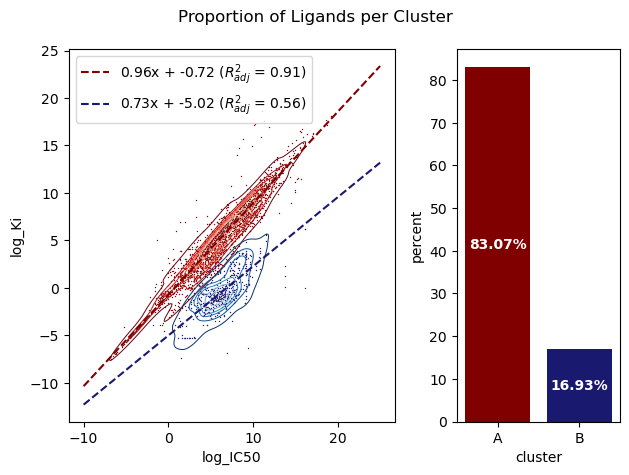

In [10]:
# assign labels with optimal seperator intercept; cluster 1 = below line
alpha = 0.71  # as found above
b = b_max[alpha]
classified_action = both_log.copy().drop(columns=["label"])
classified_action["cluster"] = (both_log["log_IC50"] < both_log["log_Ki"] + b).astype(
    int
)
classified_action["cluster"] = classified_action["cluster"].replace({1: "A", 0: "B"})
fam0 = classified_action.query("cluster == 'A'")
fam1 = classified_action.query("cluster == 'B'")

res0 = cp.cheng_prusoff_model(fam0)
res1 = cp.cheng_prusoff_model(fam1)

fig, axs = plt.subplots(1, 2, gridspec_kw={"width_ratios": [2, 1]})

cp.cheng_prusoff_plot([fam0, fam1], [res0, res1], ax=axs[0])
axs[0].legend()

sns.countplot(classified_action, x="cluster", ax=axs[1], stat="percent")

colors = ["maroon", "midnightblue"]
for bar, color in zip(axs[1].patches, colors):
    bar.set_facecolor(color)
    count = bar.get_height()
    x = bar.get_x() + bar.get_width() / 2
    y = count / 2
    axs[1].text(
        x,
        y,
        f"{count:.2f}%",
        ha="center",
        va="center",
        fontweight="bold",
        color="white",
    )
fig.suptitle("Proportion of Ligands per Cluster")
plt.tight_layout()
plt.show()

Knowing this distribution, we also analyse how citations in academia change depending on the cluster.

In [11]:
# prepare data
dois_cit_cp = pd.read_csv(
    r"data/BindingDB_All.tsv",
    sep="\t",
    usecols=["Article DOI"],
)

with open("src/data/citations.json", "r") as f:
    citations_cp = json.load(f)
citations_cp = pd.DataFrame(citations_cp)
classified_dois = pd.merge(
    left=classified_action, right=dois_cit_cp, left_index=True, right_index=True
)
classified_citations = pd.merge(
    left=classified_dois,
    right=citations_cp,
    left_on="Article DOI",
    right_on="doi",
    how="inner",
)  # note: around half the ligands are lost because don't have publication
# classified_citations["cluster"].value_counts()/classified_citations["cluster"].shape[0] #but proportion remains similar (89%-11%) --> ok for further analysis
classified_citations.drop(
    columns=["log_IC50", "log_Ki", "Article DOI", "doi"], inplace=True
)

In [12]:
# calculate h-index and avg citations
h_per_mech = cp.classified_h_index(classified_citations)
avg_cit_per_mech = (
    classified_citations.groupby("cluster").sum()
    / classified_citations.groupby("cluster").count()
).to_dict()["citation"]

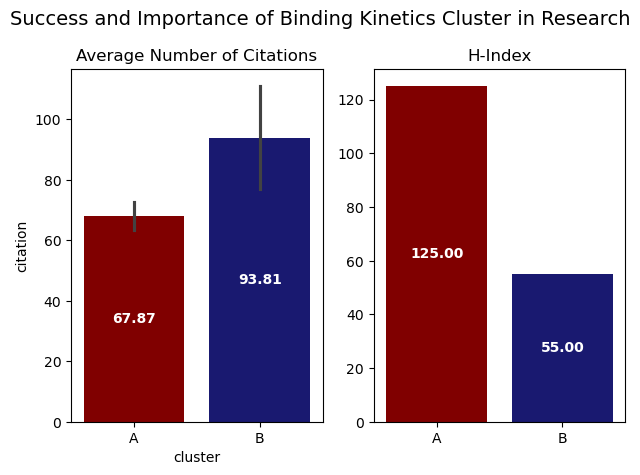

T-test Results for Difference in Mean Number of Citations:
	- Statistic: t=-2.8277751520288312
	- P-value: p=5.214e-03


In [20]:
# plot results
fig, axs = plt.subplots(1, 2)

sns.barplot(classified_citations, x="cluster", y="citation", ax=axs[0])
axs[0].set_title("Average Number of Citations")
sns.barplot(h_per_mech, ax=axs[1])
axs[1].set_title("H-Index")


colors = ["maroon", "midnightblue"]
for ax in axs:
    for bar, color in zip(ax.patches, colors):
        bar.set_facecolor(color)
        count = bar.get_height()
        x = bar.get_x() + bar.get_width() / 2
        y = count / 2
        ax.text(
            x,
            y,
            f"{count:.2f}",
            ha="center",
            va="center",
            fontweight="bold",
            color="white",
        )
fig.suptitle(
    "Success and Importance of Binding Kinetics Cluster in Research", fontsize=14
)
plt.tight_layout()
plt.show()

t_test = ttest_ind(
    a=classified_citations.query("cluster=='A'")["citation"].dropna(),
    b=classified_citations.query("cluster=='B'")["citation"].dropna(),
    equal_var=False,
)
print(
    f"T-test Results for Difference in Mean Number of Citations:\n\t- Statistic: t={t_test.statistic}\n\t- P-value: p={t_test.pvalue:.3e}"
)

We observe here that there is indeed a statistically significant difference in the mean number of citations per cluster, with cluster B generally showing higher number of citations. However, the cluster A is generally more impactful in research, notably shown by the H-index. This is in line with the large majority of researched ligands being in cluster A (as mentioned when introducing the metric, the H-index is a measure of total publication numbers and citations combined).

The clusters themselves are difficult to define specifically. Indeed, as mentioned, the seperation can be due both to experimental paradigms, as well as mechanisms of binding. We therefore decide that the most meaningful results will arise from deeper chemical features. We introduce these features by looking at how ligands follow Lipinski's rule mentioned above, and how this changes between the clusters.

In [22]:
from src.scripts.smiles import lipinski

In [24]:
lipinski_cp = pd.read_csv(
    r"data/BindingDB_All.tsv",
    sep="\t",
    usecols=["Ligand SMILES"],
)

classified_lipinski = pd.merge(
    left=classified_action, right=lipinski_cp, left_index=True, right_index=True
)
classified_lipinski["Lipinski"] = classified_lipinski["Ligand SMILES"].apply(lipinski)

[14:17:16] Explicit valence for atom # 1 N, 4, is greater than permitted


Invalid SMILES string.


[14:17:17] Explicit valence for atom # 24 N, 4, is greater than permitted


Invalid SMILES string.


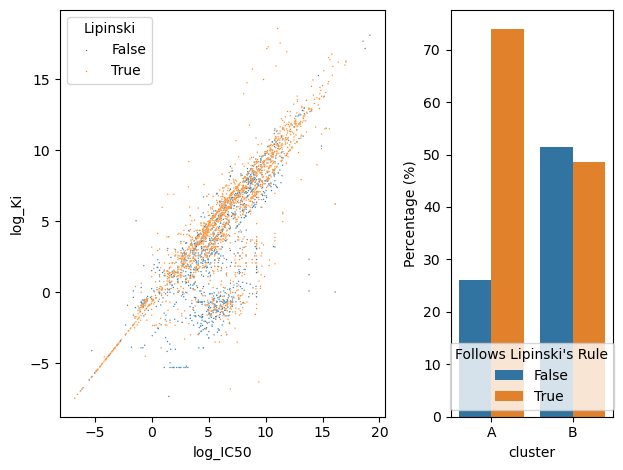

In [ ]:
fig, (ax0, ax1) = plt.subplots(1, 2, gridspec_kw={"width_ratios": [2, 1]})
sns.scatterplot(
    classified_lipinski, x="log_IC50", y="log_Ki", hue="Lipinski", s=1, ax=ax0
)
x, y = "cluster", "Lipinski"
df1_cp = classified_lipinski.groupby(x)[y].value_counts(normalize=True)
df1_cp = df1_cp.mul(100)
df1_cp = df1_cp.rename("percent").reset_index()
sns.barplot(data=df1_cp, x="cluster", y="percent", hue="Lipinski", ax=ax1)
ax1.set_ylabel("Percentage (%)")
ax1.legend(title="Follows Lipinski's Rule", loc="lower center")

plt.tight_layout()
plt.show()

Interesetingly, we observe that the main cluster A has a much larger proportion of ligands which follow Lipinski's biochemical rule of thumb, compared to the smaller cluster B. Thus, an additional hypothesis relying the seperation could indicate that cluster B is comprised of "outlying" or "failed" ligands, which may have been highly cited as they indicate "what not to do".

To help answer these questions, and gain a more precise understanding of these ligands, we finally undertake a deeper, molecular-level analysis of the data.

## Molecular Fingerprints

In [59]:
mol_df["Ligand Fingerprint"] = mol_df["Ligand SMILES"].apply(smiles.get_fingerprint)

[16:22:08] Can't kekulize mol.  Unkekulized atoms: 1 2 6
[16:22:09] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 12 13 14 15 16
[16:22:09] Explicit valence for atom # 30 N, 4, is greater than permitted
[16:22:10] Explicit valence for atom # 15 N, 4, is greater than permitted
[16:22:11] Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 13
[16:22:11] Explicit valence for atom # 17 O, 3, is greater than permitted
[16:22:11] Can't kekulize mol.  Unkekulized atoms: 18 19 21 22 24
[16:22:11] Explicit valence for atom # 32 N, 4, is greater than permitted
[16:22:12] Can't kekulize mol.  Unkekulized atoms: 25 26 27 28 29 30 32 33 34
[16:22:12] Explicit valence for atom # 29 N, 4, is greater than permitted


A molecular fingerprint is a representation of a molecule in a digital form that allows for easy comparison with other molecules. Fingerprints capture structural information about a molecule, such as the presence of particular atoms, bonds, and functional groups, and transform this information into a series of binary values (bits). We are using a Morgan fingerprint, a sparse 2048 bit encoding, generated using rdkit. Using the fingerprints we can perform clustering, measure distance, and train ML models.

### Clustering

In [60]:
smiles_df = pd.read_csv(
    "data/BindingDB_All.tsv",
    sep="\t",
    usecols=[
        "UniProt (SwissProt) Primary ID of Target Chain",
        "DrugBank ID of Ligand",
        "Ligand SMILES",
        "IC50 (nM)",
        "Article DOI",
        "ZINC ID of Ligand",
    ],
)
target = smiles_df[
    smiles_df["UniProt (SwissProt) Primary ID of Target Chain"] == "P07949"
].dropna(subset=["Ligand SMILES", "IC50 (nM)"])
target["IC50 (nM)"] = (
    target["IC50 (nM)"]
    .astype(str)
    .str.replace(">", "")
    .str.replace("<", "")
    .astype(float)
)
smiles_df = (
    smiles_df["UniProt (SwissProt) Primary ID of Target Chain"]
    .dropna()
    .value_counts()
    .head()
)

Given the large influence in drug discovery of cancer and neurodegeneration previously analysed, and the highly influential target classes of tyrosine kinases and neurotransmitter receptors, we specifically analyse the molecular features of RET, a proto-oncogene tyrosine kinase, and the dopamine receptor D2 (D2R), and their implications in research success.

First, we focus on the RET, which is coincidently highest occurring target in BindingDB.

In [61]:
target["Ligand Fingerprint"] = target["Ligand SMILES"].apply(smiles.get_fingerprint)
target = target.dropna(subset="Ligand Fingerprint")
pca = PCA(n_components=3, random_state=0).fit(
    np.stack(target["Ligand Fingerprint"].dropna())
)
pca_coords = pca.transform(np.stack(target["Ligand Fingerprint"].dropna()))
target[["PC1", "PC2", "PC3"]] = pca_coords

[16:22:44] Explicit valence for atom # 1 N, 4, is greater than permitted
[16:22:45] Explicit valence for atom # 35 N, 4, is greater than permitted
[16:22:45] Explicit valence for atom # 35 N, 4, is greater than permitted
[16:22:47] Explicit valence for atom # 11 N, 4, is greater than permitted
[16:22:47] Explicit valence for atom # 11 N, 4, is greater than permitted
[16:22:49] Explicit valence for atom # 1 N, 4, is greater than permitted
[16:22:50] Can't kekulize mol.  Unkekulized atoms: 3 4 7 8 9
[16:22:50] Can't kekulize mol.  Unkekulized atoms: 3 4 7 8 9
[16:22:52] Explicit valence for atom # 17 N, 4, is greater than permitted
[16:22:52] Explicit valence for atom # 17 N, 4, is greater than permitted
[16:22:52] Explicit valence for atom # 17 N, 4, is greater than permitted


In [46]:
kmeans = KMeans(n_clusters=5, random_state=0, n_init="auto").fit(
    np.stack(target["Ligand Fingerprint"].dropna())
)
target["Cluster"] = kmeans.predict(np.stack(target["Ligand Fingerprint"].dropna()))

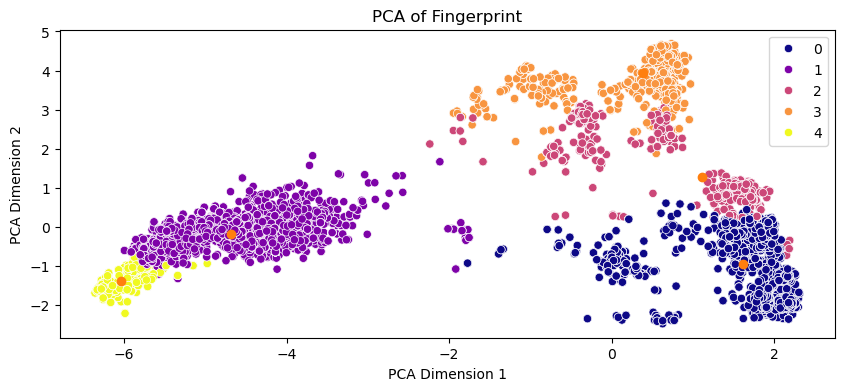

In [47]:
plt.figure(figsize=(10, 4))
sns.scatterplot(data=target, x="PC1", y="PC2", hue="Cluster", palette="plasma")
centroids = pca.transform(kmeans.cluster_centers_)
plt.scatter(x=centroids[:, 0], y=centroids[:, 1])
plt.title("PCA of Fingerprint")
plt.xlabel("PCA Dimension 1")
plt.ylabel("PCA Dimension 2")
plt.legend()
plt.show()

To visually confirm the significance of clustering, we show below randomly sampled molecules from each cluster.

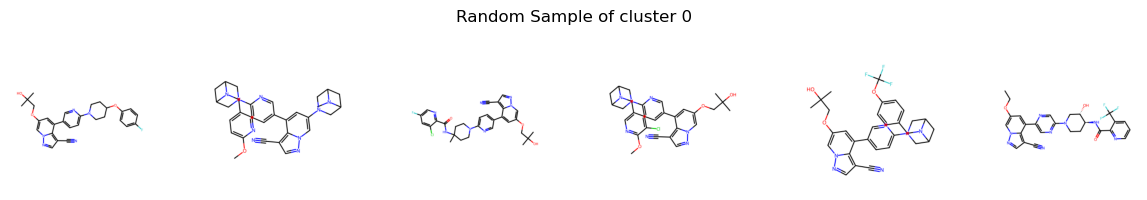

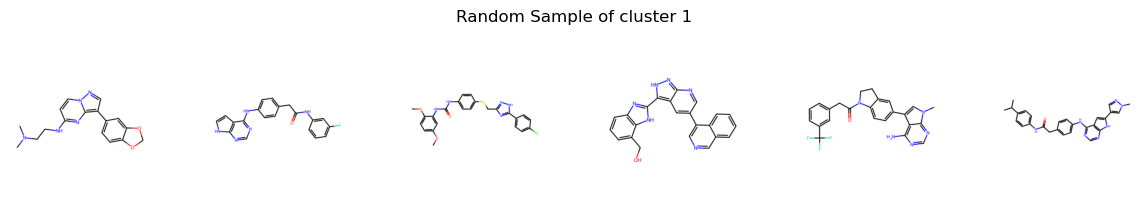

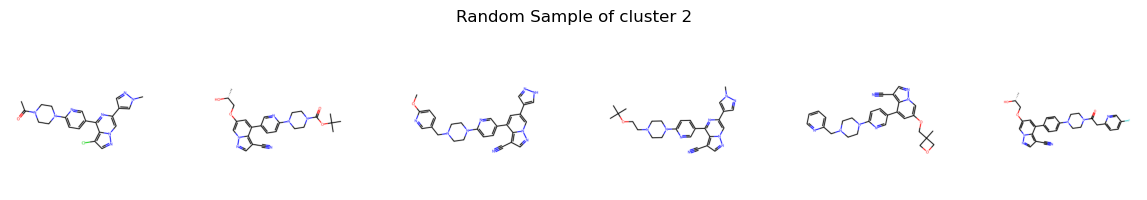

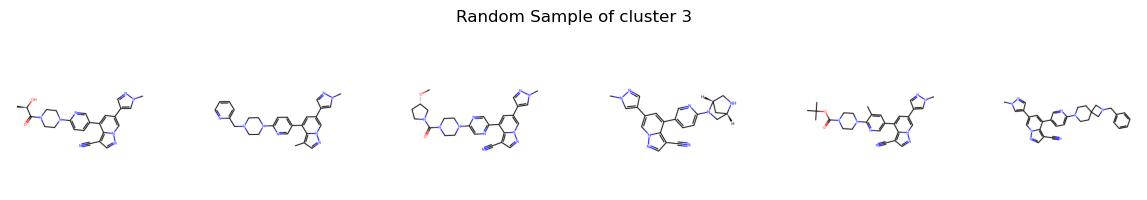

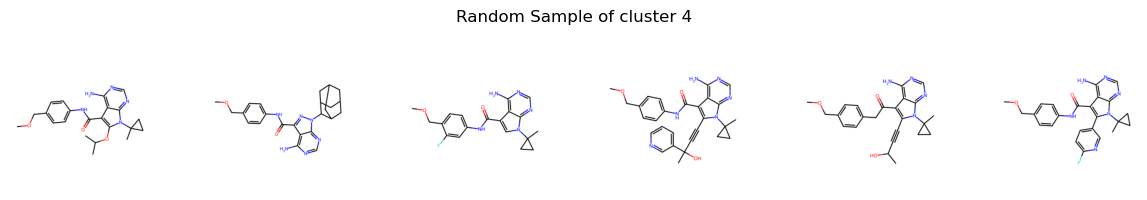

In [48]:
for i in range(5):
    smiles.show_smiles(
        target[target["Cluster"] == i],
        f"Random Sample of cluster {i}",
        n_rows=1,
        n_cols=6,
        random_sample=True,
    )

To further analyze the implications of the molecular features of RET as well as D2R in research success, we look at how these structures develop over time.


In [21]:
from src.scripts import timeseries_anim
from src.scripts.save_plotly import save_plotly

In [5]:
smiles_df = pd.read_csv(
    "data/BindingDB_All.tsv",
    sep="\t",
    usecols=[
        "UniProt (SwissProt) Primary ID of Target Chain",
        "DrugBank ID of Ligand",
        "Ligand SMILES",
        "IC50 (nM)",
        "Article DOI",
        "Institution",
        "Patent Number",
        "ZINC ID of Ligand",
    ],
)

In [22]:
uniprotIDs = [["P07949"], ["P14416"]]
targets = {}
for uniprotID in uniprotIDs:
    key = uniprotID[0]
    targets[key] = timeseries_anim.filter_uniprotID(smiles_df, uniprot_ids=uniprotID)
target_ret = targets["P07949"]
target_d2r = targets["P14416"]

In [23]:
for i, target in enumerate([target_ret, target_d2r]):
    target = timeseries_anim.get_ligands_fingerprint(target)
    target = timeseries_anim.merge_DOI_data(target)
    target = timeseries_anim.filter_institutions(target)
    target, _, _ = timeseries_anim.PCA_fingerprints(target)
    target = timeseries_anim.group_institutions(target)
    target = timeseries_anim.get_cumulative_years_df(target)
    target = timeseries_anim.include_dummy_row_for_anim(
        target, color_column="Institution"
    )
    target["current_year"] = target["current_year"].astype(int)
    target = timeseries_anim.clean_IC50(target)
    target["log(IC50) (nM)"] = np.log(target["IC50 (nM)"])
    target["max(log(IC50), 0)"] = np.clip(target["log(IC50) (nM)"], 0, np.inf)
    target["|log(IC50) (nM)|"] = np.abs(target["log(IC50) (nM)"])
    target = timeseries_anim.include_dummy_row_for_anim(target, "log(IC50) (nM)")
    if i == 0:
        target_ret = target
    else:
        target_d2r = target

[18:52:49] Explicit valence for atom # 1 N, 4, is greater than permitted
[18:52:51] Explicit valence for atom # 35 N, 4, is greater than permitted
[18:52:51] Explicit valence for atom # 35 N, 4, is greater than permitted
[18:52:52] Explicit valence for atom # 11 N, 4, is greater than permitted
[18:52:52] Explicit valence for atom # 11 N, 4, is greater than permitted
[18:52:54] Explicit valence for atom # 1 N, 4, is greater than permitted
[18:52:55] Can't kekulize mol.  Unkekulized atoms: 3 4 7 8 9
[18:52:55] Can't kekulize mol.  Unkekulized atoms: 3 4 7 8 9
[18:52:57] Explicit valence for atom # 17 N, 4, is greater than permitted
[18:52:57] Explicit valence for atom # 17 N, 4, is greater than permitted
[18:52:57] Explicit valence for atom # 17 N, 4, is greater than permitted
[18:53:06] Explicit valence for atom # 1 N, 4, is greater than permitted
[18:53:07] Can't kekulize mol.  Unkekulized atoms: 19 20 21 22 23 24 25 26 27
[18:53:07] Can't kekulize mol.  Unkekulized atoms: 20 21 22 23 

In [ ]:
targets_and_titles = [(target_ret, "RET"), (target_d2r, "D2R")]
for target_cumulative_with_IC50, title in targets_and_titles:
    fig = px.scatter_3d(
        target_cumulative_with_IC50,
        x="PC1",
        y="PC2",
        z="PC3",
        animation_frame="current_year",
        animation_group="Ligand SMILES",
        color="log(IC50) (nM)",
        hover_data=[
            "Institution",
            "Article DOI",
            "year",
            "IC50 (nM)",
        ],
        range_x=[
            1.1 * target_cumulative_with_IC50["PC1"].min(),
            1.1 * target_cumulative_with_IC50["PC1"].max(),
        ],
        range_y=[
            1.1 * target_cumulative_with_IC50["PC2"].min(),
            1.1 * target_cumulative_with_IC50["PC2"].max(),
        ],
        range_z=[
            1.1 * target_cumulative_with_IC50["PC3"].min(),
            1.1 * target_cumulative_with_IC50["PC3"].max(),
        ],
        template="plotly_dark",
        color_continuous_scale=px.colors.sequential.Viridis_r,
    )
    fig.update_traces(marker=dict(size=2))
    fig.update_layout(
        title={
            "text": f"Temporal fingerprints PCA of {title} ligands",
            "x": 0.5,
            "xanchor": "center",
            "yanchor": "top",
        },
        scene=dict(
            aspectmode="cube",
        ),
    )
    # fig.show() # Uncomment this line to view the figure interactively
    fig.show(renderer="svg")

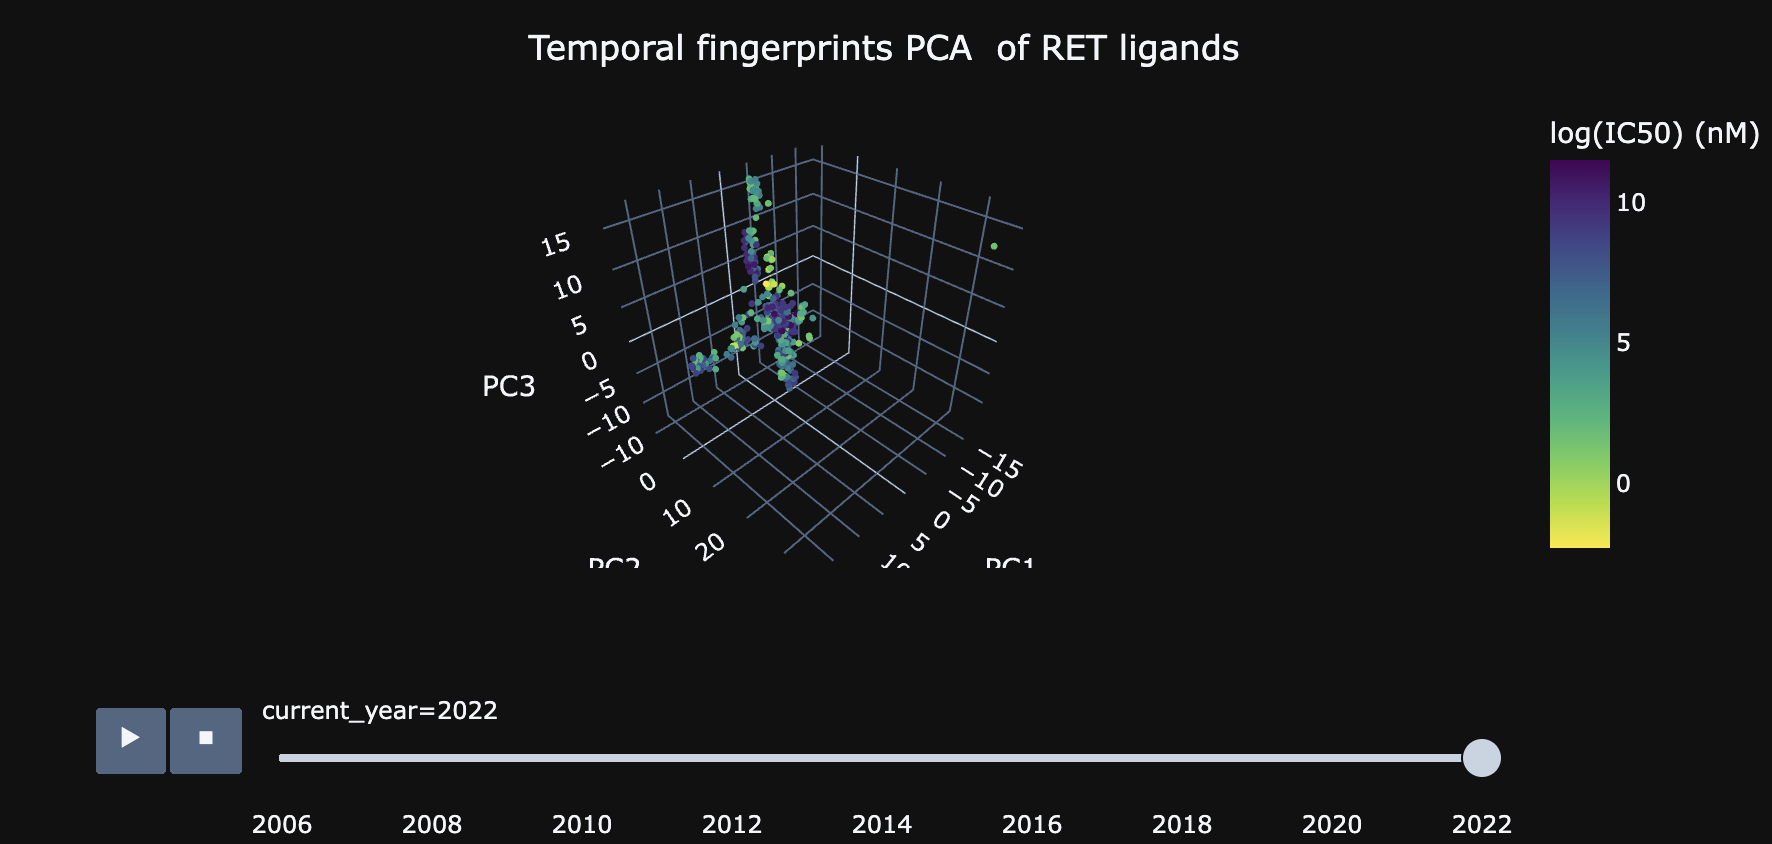

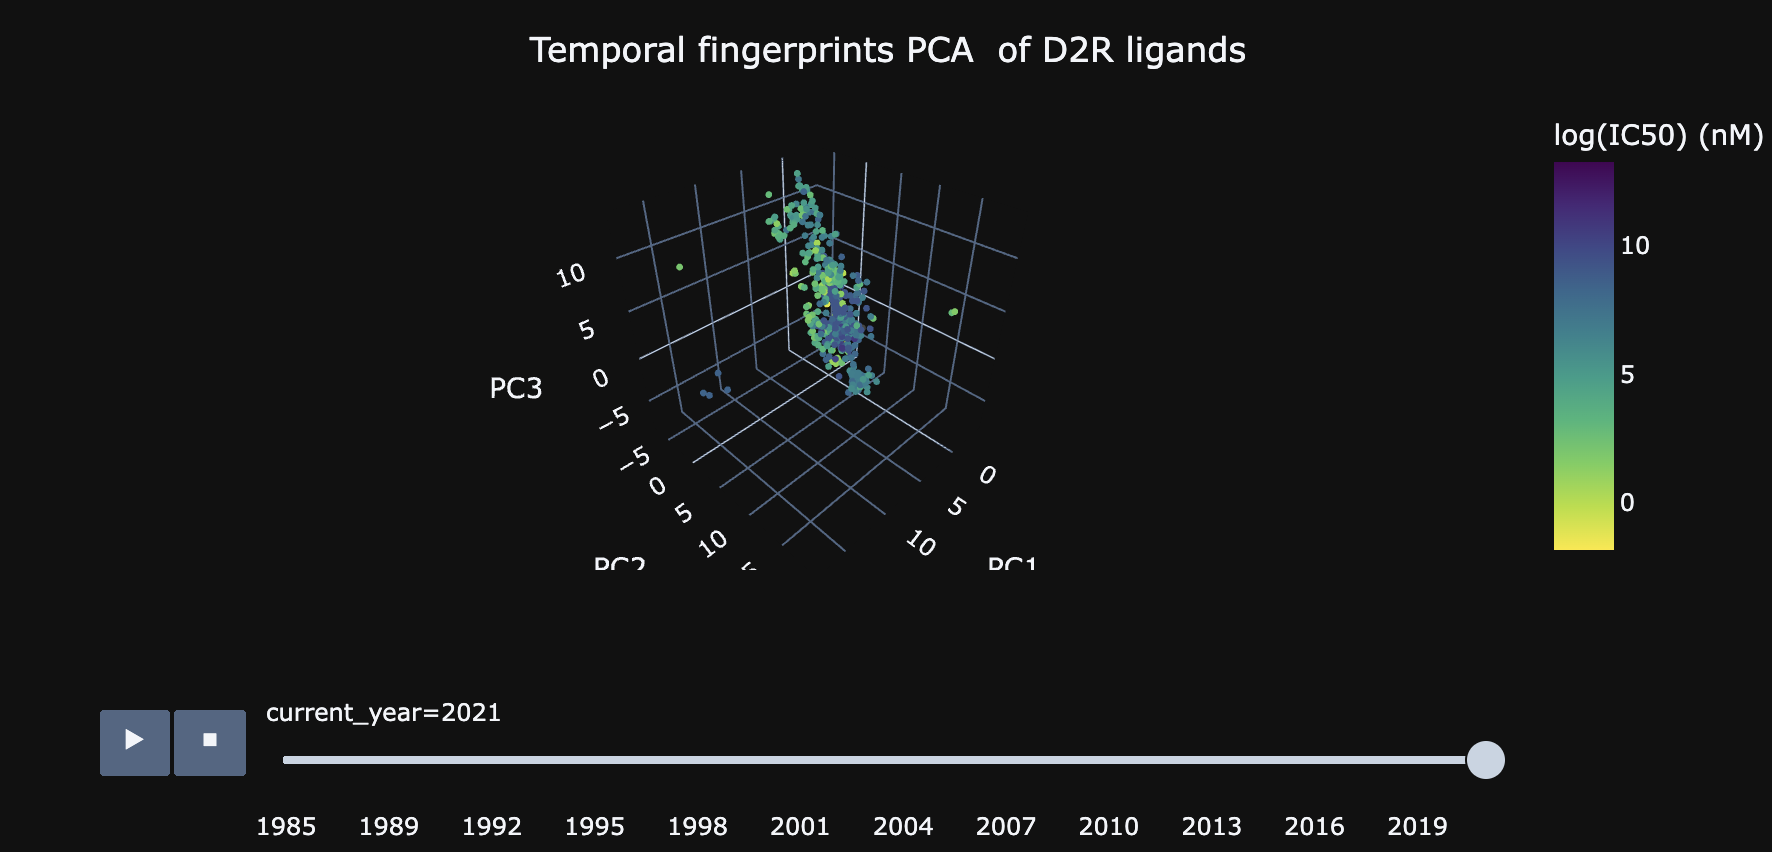

To visualize these figures interactively in 3D and in time, please go to [our website](https://epfl-ada.github.io/ada-2024-project-standarddeviants/).

These figures offer great insight into the research strategy itself. Indeed, from an initial central cluster, we see that subsequent drugs are developed by branching out in distinct directions. This stresses the iterative nature of drug discovery, in which, from an initial drug, researchers and institutions modify small components (adding side chains, aromatic rings, bonds, etc.) in the hopes of finding an improved version of the drug. This improvement is shown by the decreasing IC50 in branches over time (increasing efficacy).

In [26]:
target_ret = timeseries_anim.include_dummy_row_for_anim(target_ret, "Institution")
target_d2r = timeseries_anim.include_dummy_row_for_anim(target_d2r, "Institution")

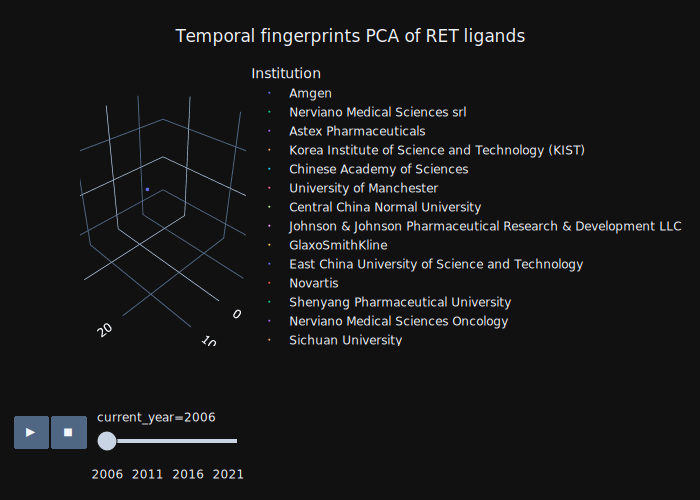

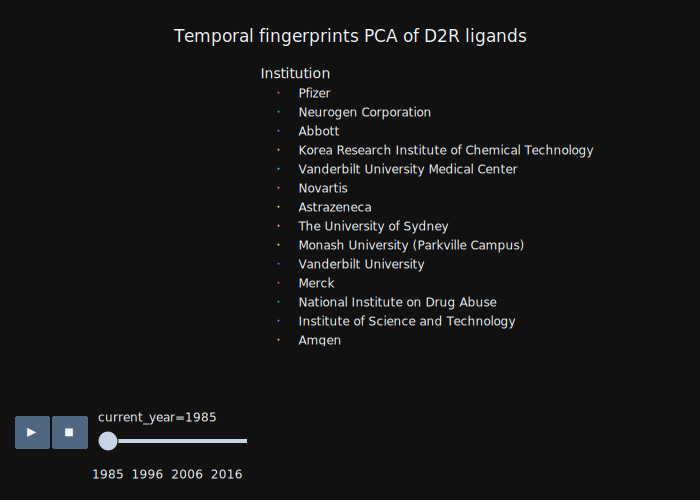

In [28]:
targets_and_titles = [(target_ret, "RET"), (target_d2r, "D2R")]
for target_cumulative_with_IC50, title in targets_and_titles:
    fig = px.scatter_3d(
        target_cumulative_with_IC50,
        x="PC1",
        y="PC2",
        z="PC3",
        animation_frame="current_year",
        animation_group="Ligand SMILES",
        color="Institution",
        hover_data=[
            "Institution",
            "Article DOI",
            "year",
            "IC50 (nM)",
        ],
        range_x=[
            1.1 * target_cumulative_with_IC50["PC1"].min(),
            1.1 * target_cumulative_with_IC50["PC1"].max(),
        ],
        range_y=[
            1.1 * target_cumulative_with_IC50["PC2"].min(),
            1.1 * target_cumulative_with_IC50["PC2"].max(),
        ],
        range_z=[
            1.1 * target_cumulative_with_IC50["PC3"].min(),
            1.1 * target_cumulative_with_IC50["PC3"].max(),
        ],
        template="plotly_dark",
    )
    fig.update_traces(marker=dict(size=2))
    fig.update_layout(
        title={
            "text": f"Temporal fingerprints PCA of {title} ligands",
            "x": 0.5,
            "xanchor": "center",
            "yanchor": "top",
        },
        scene=dict(
            aspectmode="cube",
        ),
    )
    # fig.show() # Uncomment this line to view the figure interactively
    fig.show(renderer="svg")

To visualize these figures interactively in 3D and in time, please go to [our website](https://epfl-ada.github.io/ada-2024-project-standarddeviants/).

When focusing on specific institutions, we observe that each focuses on their own specific modifications, all published as clusters, with differences within the clusters most probably being tiny structural changes. Thus, each branch from the initial central cluster is a biochemical direction taken by an institution. But which institution found success, and most importantly, how?

To answer this question, we look at the same clusters, for D2R and RET, overlaid with the success metrics previously presented. 

In [1]:
from sklearn.metrics import silhouette_score
from src.scripts.clinical_trials import (
    combine_trials_json,
    plot_clinical_counts,
    classify_disease,
    load_clinical_trials_data,
)

from src.scripts.pc import (
    merge_citations_with_targets,
    process_and_merge_patents,
    clean_and_transform_IC50,
    kmeans_selection,
)
from sklearn.cluster import KMeans
import plotly.express as px
import plotly.graph_objects as go

In [4]:
phase_4_count_df = (
    df_all.query("status_name == 'Completed'")
    .value_counts(["ZINC ID of Ligand", "phase_name"])
    .reset_index()
    .query("phase_name == 'Phase 4'")
    .rename(columns={"count": "phase_4_count"})
    .drop(columns="phase_name")
)

In [6]:
from src.scripts.pc import prepare_pca

uniprot_ids_names_mapping = {"P07949": "RET", "P14416": "D(2) dopamine receptor"}
result, targets = prepare_pca(
    smiles_df,
    phase_4_count_df,
    citations_path="src/data/citations.json",
    patents_path="src/data/patents.json",
    uniprot_ids=["P07949", "P14416"],
)

[19:05:35] Explicit valence for atom # 1 N, 4, is greater than permitted
[19:05:35] Explicit valence for atom # 35 N, 4, is greater than permitted
[19:05:36] Explicit valence for atom # 11 N, 4, is greater than permitted
[19:05:36] Explicit valence for atom # 1 N, 4, is greater than permitted
[19:05:36] Explicit valence for atom # 17 N, 4, is greater than permitted
[19:05:36] Can't kekulize mol.  Unkekulized atoms: 19 20 21 22 23 24 25 26 27
[19:05:36] Can't kekulize mol.  Unkekulized atoms: 20 21 22 23 24 25 26 27 28
[19:05:36] Can't kekulize mol.  Unkekulized atoms: 23 24 25 26 27 28 29 30 31
[19:05:36] Can't kekulize mol.  Unkekulized atoms: 24 25 26 27 28 29 30 31 32
[19:05:36] Can't kekulize mol.  Unkekulized atoms: 23 24 25 26 27 28 29 30 31
[19:05:37] Explicit valence for atom # 32 O, 3, is greater than permitted
[19:05:37] Can't kekulize mol.  Unkekulized atoms: 17 18 19 20 21 22 23 24 25
[19:05:37] Explicit valence for atom # 1 N, 4, is greater than permitted
[19:05:37] Can't 

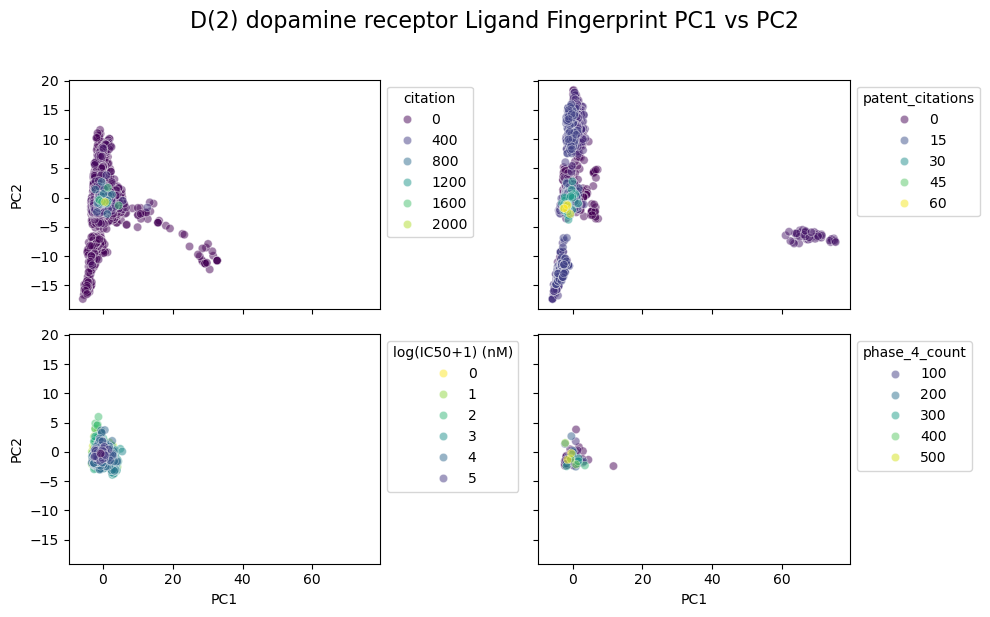

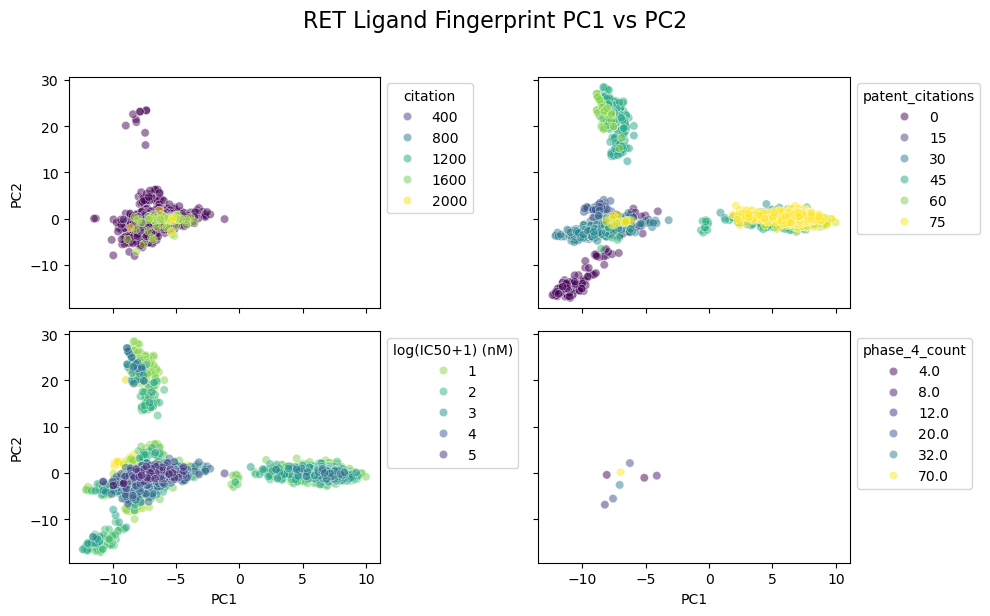

In [7]:
for target in targets["UniProt (SwissProt) Primary ID of Target Chain"].unique():
    fig, axs = plt.subplots(2, 2, sharey=True, sharex=True, figsize=(10, 6))
    title = f"{uniprot_ids_names_mapping[target]} Ligand Fingerprint PC1 vs PC2"
    fig.suptitle(title, fontsize=16, y=1.02)
    for ax, hue in zip(
        axs.flatten(),
        ["citation", "patent_citations", "log(IC50+1) (nM)", "phase_4_count"],
    ):
        palette = "viridis_r" if hue == "log(IC50+1) (nM)" else "viridis"
        sns.scatterplot(
            result[
                result["UniProt (SwissProt) Primary ID of Target Chain"] == target
            ].sort_values(hue),
            x="PC1",
            y="PC2",
            hue=hue,
            ax=ax,
            palette=palette,
            alpha=0.5,
        )
        sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
    plt.tight_layout()
    plt.show()

Following the steps of drug discovery, we first look at academic publications and their citations. Doing so, we observe that the central cluster, which we remember to be the first in time, clearly has the most academic impact. Again, this stresses how iterations of drugs rely on the original publication. Thus, success in academic research clearly relies on novelty. 

When looking at molecules that are patented, we again see the same importance of the central cluster. However, the newer branchings discussed above equally enjoy higher patent citation, showing how new structural modifications, and increased efficacy (lower IC50) brings success in industry. Indeed, the successful cluster when measuring patent impact is not necessarily the first. For example, RET’s most cited patented ligand originates from improved versions compared to the original academic publication. In clinical applications, we again observe that the most successful cluster, when measured by the number of phase 4 trials, is again the original molecule. This may simply be due to the duration of clinical trials, which often take years before reaching phase 4. All in all, these results show how, from a first successful academic publication, researchers improve on a drug’s efficacy, as measured by IC50. 

Below, we show that these metrics are complementary, as they show no visible correlation or interaction.

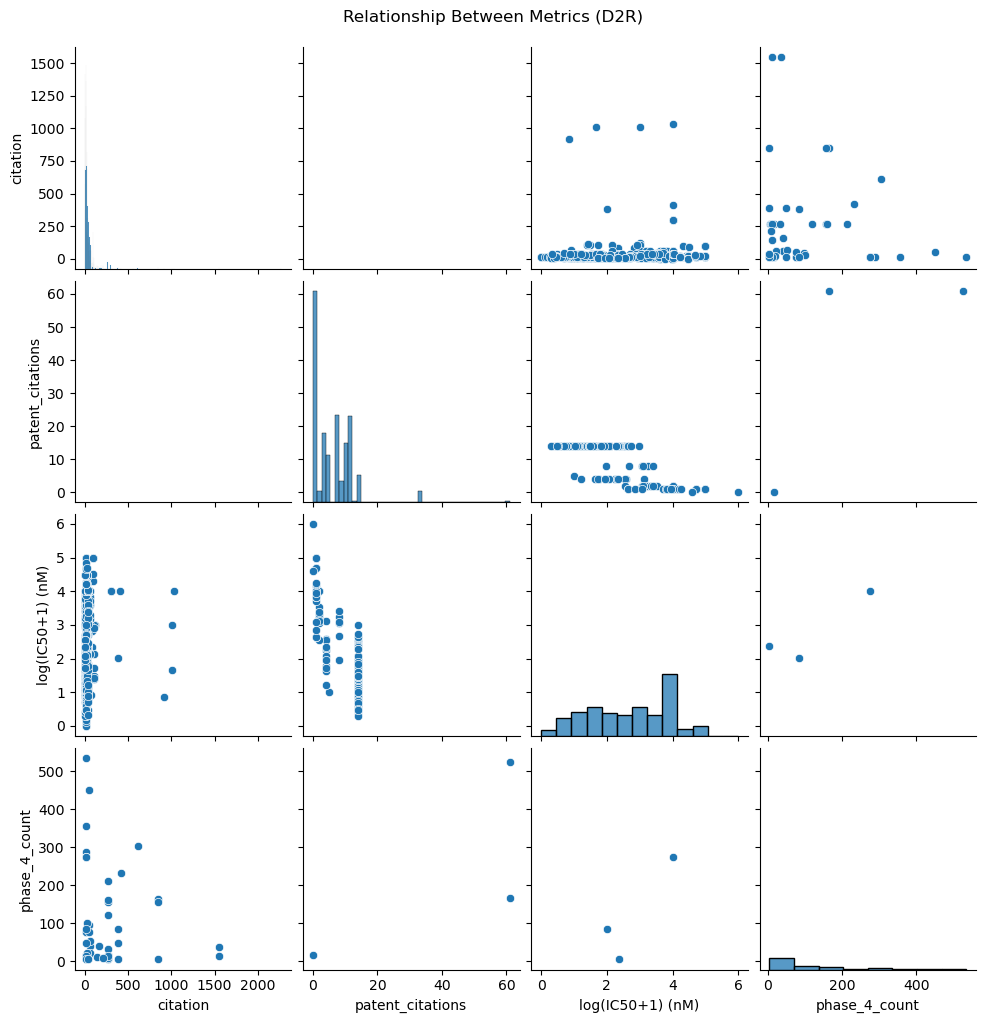

In [8]:
result_ = result[result["UniProt (SwissProt) Primary ID of Target Chain"] == "P14416"]
sns.pairplot(
    result_[["citation", "patent_citations", "log(IC50+1) (nM)", "phase_4_count"]]
)
plt.suptitle("Relationship Between Metrics (D2R)", y=1.02)
plt.show()

Now knowing what research strategy is employed to develop new ligands, we are interested in actually knowing what these molecules are. 
To do so, we perform k-means clustering, choosing 5 clusters based on the elbow criterion.
Thereafter, we find the representative molecule of each cluster as the molecule with the median IC50.

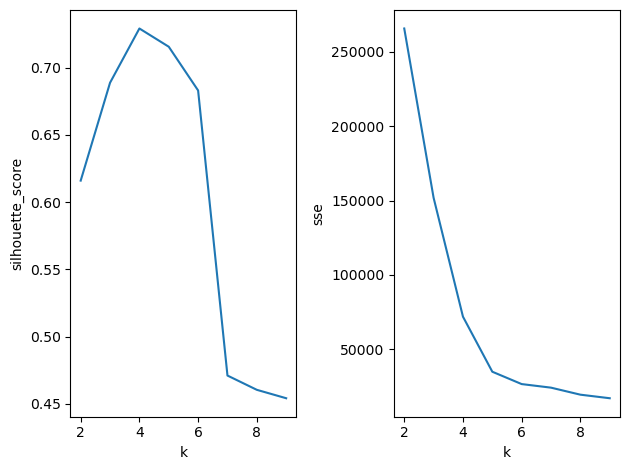

In [9]:
from src.scripts.pc import kmeans_selection

result = result[result["UniProt (SwissProt) Primary ID of Target Chain"] == "P07949"]
kmeans_selection_df = pd.DataFrame(
    kmeans_selection(result[["PC1", "PC2", "PC3"]], range(2, 10))
)
fig, (ax1, ax2) = plt.subplots(1, 2)
sns.lineplot(kmeans_selection_df, x="k", y="silhouette_score", ax=ax1)
sns.lineplot(kmeans_selection_df, x="k", y="sse", ax=ax2)
plt.tight_layout()
plt.show()

In [ ]:
kmeans = KMeans(n_clusters=5, random_state=10).fit(result[["PC1", "PC2", "PC3"]])
result["cluster"] = kmeans.predict(result[["PC1", "PC2", "PC3"]]).astype(str)
fig = px.scatter_3d(
    result.sort_values("cluster"),
    x="PC1",
    y="PC2",
    z="PC3",
    color="cluster",
    template="plotly_dark",
    opacity=0.5,
)
fig.update_traces(marker=dict(size=2))
centroids = kmeans.cluster_centers_
fig.add_trace(
    go.Scatter3d(
        x=centroids[:, 0],
        y=centroids[:, 1],
        z=centroids[:, 2],
        mode="markers",
        marker=dict(
            size=3,
            color="white",
            symbol="x",
        ),
        name="Centroids",
        opacity=0.5,
    )
)
fig.update_layout(
    title={
        "text": "PCA K-Means Clustering on RET Ligands",
        "x": 0.5,
        "xanchor": "center",
        "yanchor": "top",
    },
    scene=dict(
        aspectmode="cube",
    ),
)
# fig.show() # Uncomment this line to view the figure interactively

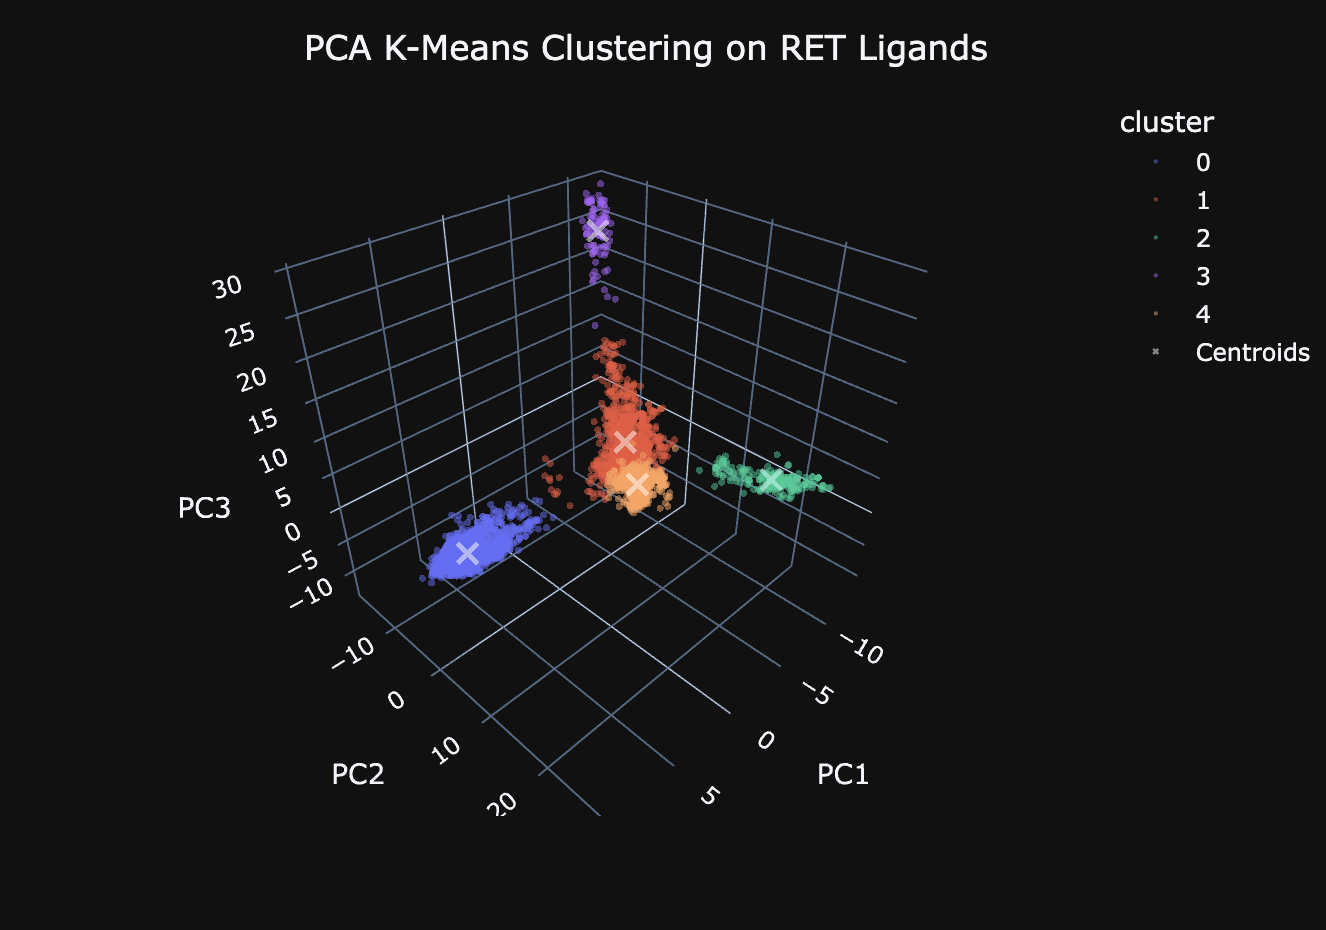

To visualize this figure interactively in 3D, please go to [our website](https://epfl-ada.github.io/ada-2024-project-standarddeviants/).

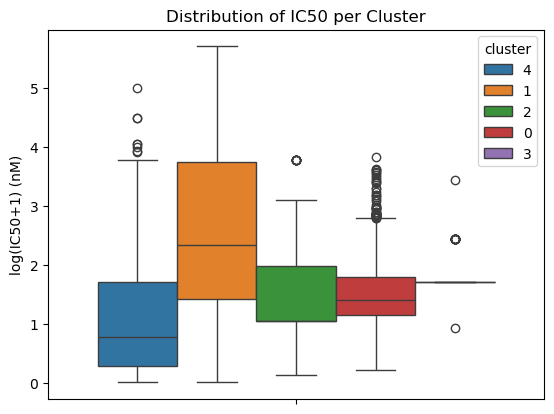

In [11]:
sns.boxplot(result.sort_values("log(IC50+1) (nM)"), hue="cluster", y="log(IC50+1) (nM)")
plt.title("Distribution of IC50 per Cluster")
plt.show()

Here, we indeed identify that each cluster has varying IC50 values, as expected based on the previous plots. These differences in binding kinetics are due to differences in structure. To identify which structural elements are the most decisive in predicting IC50, we resort to two classification models: logistic regression and random forests.

As explained, these classifiers take structural features (number of bonds, number of rotatable bonds, number of saturated rings, partial charges, etc.) as predictors. These are shown below, for the 5 representatives previously discussed. 

In [13]:
from src.scripts.pc import cluster_representatives, get_representative_descriptors

representatives = cluster_representatives(result)
representatives_with_descriptors = get_representative_descriptors(representatives)
representatives_with_descriptors

  0%|          | 0/5 [00:00<?, ?it/s]

Ligand SMILES  IC50 (nM)  \
13559           CC(C)n1cc(-c2cc3ccccc3[nH]2)c2c(N)ncnc12        5.0   
13248  Cc1cc(Nc2cc(C)cc(n2)N2CCC(C)(CC2)C(=O)NCc2ccc(...       10.0   
11752  CC(C)(O)COc1cc(-c2ccc(nc2)N2CC3CC(C2)N3Cc2ccc(...       24.5   
14042  CC(C)COc1cc2nccc(Oc3ccc(NC(=O)NC4CC4)c(Cl)c3)c...       50.0   
10792  CNCc1cncc(c1)-c1cnc2[nH]nc(-c3nc4cc5OC(F)(F)Oc...      218.0   

                                      Institution  DrugBank ID of Ligand  \
13559          Cancer Research Technology Limited                    NaN   
13248             BLUEPRINT MEDICINES CORPORATION                    NaN   
11752                         Array BioPharma Inc                    NaN   
14042  BEIJING SCITECH-MQ PHARMACEUTICALS LIMITED                    NaN   
10792               National Tsing Hua University                    NaN   

      ZINC ID of Ligand UniProt (SwissProt) Primary ID of Target Chain  \
13559               NaN                                         P07949   
13248               NaN                                         P07949   
11752               NaN                                         P07949   
14042               NaN                                         P07949   
10792      ZINC72176704                                         P07949   

                              doi  citation      patent patent_status  ...  \
13559                         NaN       NaN  US10844067        Active  ...   
13248                         NaN       NaN  US10227329        Active  ...   
11752                         NaN       NaN  US10112942        Active  ...   
14042                         NaN       NaN  US11479559        Active  ...   
10792  10.1016/j.bmcl.2011.06.003      12.0         NaN           NaN  ...   

       NumAromaticRings  NumHAcceptors  NumHDonors NumHeteroatoms  \
13559                 4              4           2              5   
13248                 4              8           3             10   
11752                 4             10           1             12   
14042                 3              6           2              9   
10792                 5              7           3             11   

       NumRadicalElectrons  NumRotatableBonds  NumSaturatedCarbocycles  \
13559                    0                  2                        0   
13248                    0                  7                        0   
11752                    0                  9                        0   
14042                    0                  7                        1   
10792                    0                  4                        0   

      NumSaturatedHeterocycles  NumSaturatedRings  NumValenceElectrons  
13559                        0                  0                  110  
13248                        1                  1                  186  
11752                        3                  3                  212  
14042                        0                  1                  178  
10792                        0                  0                  160  

[5 rows x 56 columns]

## Interpretable Machine Learning

Fingerprints makes for good visualisations of molecules but do not answer the question of **which molecular properties have a strong predictive relationship with success.** For this we use rdkit's molecular descriptors as features in random forests classification, and multiclass logistic classification for interpretable insights.

In [1]:
import pandas as pd
import numpy as np

from src.scripts import smiles
from src.utils import utils  # import collinear_cols

%load_ext autoreload

# plotting tools
import seaborn as sns
import matplotlib.pyplot as plt

# learning
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from tqdm import tqdm

tqdm.pandas()

In [2]:
# Importing data
ligand_df = pd.read_csv(
    "data/BindingDB_All.tsv",
    sep="\t",
    usecols=[
        "Ligand SMILES",
        "IC50 (nM)",
        "UniProt (SwissProt) Primary ID of Target Chain",
        "Article DOI",
    ],
)
descriptors = ligand_df.dropna(
    subset=["Ligand SMILES", "UniProt (SwissProt) Primary ID of Target Chain"]
)[ligand_df["UniProt (SwissProt) Primary ID of Target Chain"] == "P07949"][
    "Ligand SMILES"
].progress_apply(
    smiles.get_MolDescriptors
)
descriptors_df = pd.DataFrame(
    descriptors[descriptors.apply(lambda x: isinstance(x, dict))].to_list(),
    index=descriptors[descriptors.apply(lambda x: isinstance(x, dict))].index,
)

/var/folders/6_/6g10b43x17ngwmk4l9msb2mc0000gn/T/ipykernel_7776/930628430.py:2: DtypeWarning: Columns (9,17) have mixed types. Specify dtype option on import or set low_memory=False.
  ligand_df = pd.read_csv(
/var/folders/6_/6g10b43x17ngwmk4l9msb2mc0000gn/T/ipykernel_7776/930628430.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  descriptors = ligand_df.dropna(
 12%|█▏        | 3114/26807 [00:18<02:18, 170.91it/s][08:33:47] Explicit valence for atom # 35 N, 4, is greater than permitted
[08:33:47] Explicit valence for atom # 35 N, 4, is greater than permitted
 47%|████▋     | 12578/26807 [01:15<01:05, 218.41it/s][08:34:44] Can't kekulize mol.  Unkekulized atoms: 3 4 7 8 9
[08:34:44] Can't kekulize mol.  Unkekulized atoms: 3 4 7 8 9
 66%|██████▋   | 17793/26807 [01:45<00:56, 158.63it/s][08:35:14] Explicit valence for atom # 17 N, 4, is greater than permitted
[08:35:14] Explicit valence for atom # 17 N, 4, is greater than permitted
[08:35:14] Explicit 

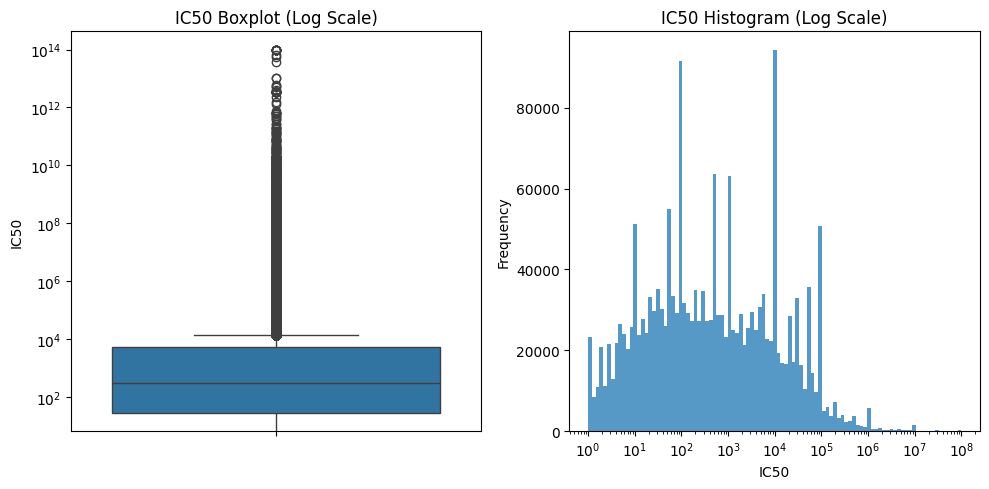

In [3]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

sns.boxplot(data=smiles.get_IC50(ligand_df).dropna(), ax=axes[0])
axes[0].set_yscale("log")
axes[0].set_title("IC50 Boxplot (Log Scale)")
axes[0].set_ylabel("IC50")
axes[0].set_xlabel("")

sns.histplot(
    data=smiles.get_IC50(ligand_df).dropna(), bins=np.logspace(0, 8, 100), ax=axes[1]
)
axes[1].set_xscale("log")
axes[1].set_title("IC50 Histogram (Log Scale)")
axes[1].set_ylabel("Frequency")
axes[1].set_xlabel("IC50")

plt.tight_layout()
plt.show()

The histogram indicates that the distribution of the IC50 is log-normal. We then split the IC50 into 3 classes high, middle and low based on the 0.33 and 0.67 quantiles.

In [31]:
# Define which columns to one-hot encode and which to scale
categorical_columns = [
    col for col in descriptors_df.columns if ("Num" in col or "Count" in col)
]  # Replace with your actual column names
numerical_columns = [
    col for col in descriptors_df.columns if col not in categorical_columns
]

# Create column transformer for preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numerical_columns),
        ("cat", OneHotEncoder(sparse_output=False), categorical_columns),
    ],
    remainder="drop",  # Drop other columns not specified
)

# Apply transformations
X = (
    Pipeline(steps=[("preprocessor", preprocessor)])
    .set_output(transform="pandas")
    .fit_transform(descriptors_df.dropna())
)

# Process target variable
y = smiles.get_IC50(ligand_df.iloc[X.index]).dropna()
y = pd.cut(y, bins=y.quantile([0, 1 / 3, 2 / 3, 1]), labels=np.arange(3)).dropna()

# Align X and y indices
X = X.loc[y.index]

# Drop collinear columns
to_drop = utils.collinear_cols(X, threshold=0.95)
X = X.drop(to_drop, axis=1)


# Dropping columns with low std
threshold = X.std().quantile(0.1)
low_std_cols = X.std().loc[lambda x: x < threshold].index.tolist()
X = X.drop(low_std_cols, axis=1)

/var/folders/6_/6g10b43x17ngwmk4l9msb2mc0000gn/T/ipykernel_7776/2953761600.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(df.columns, rotation=90)


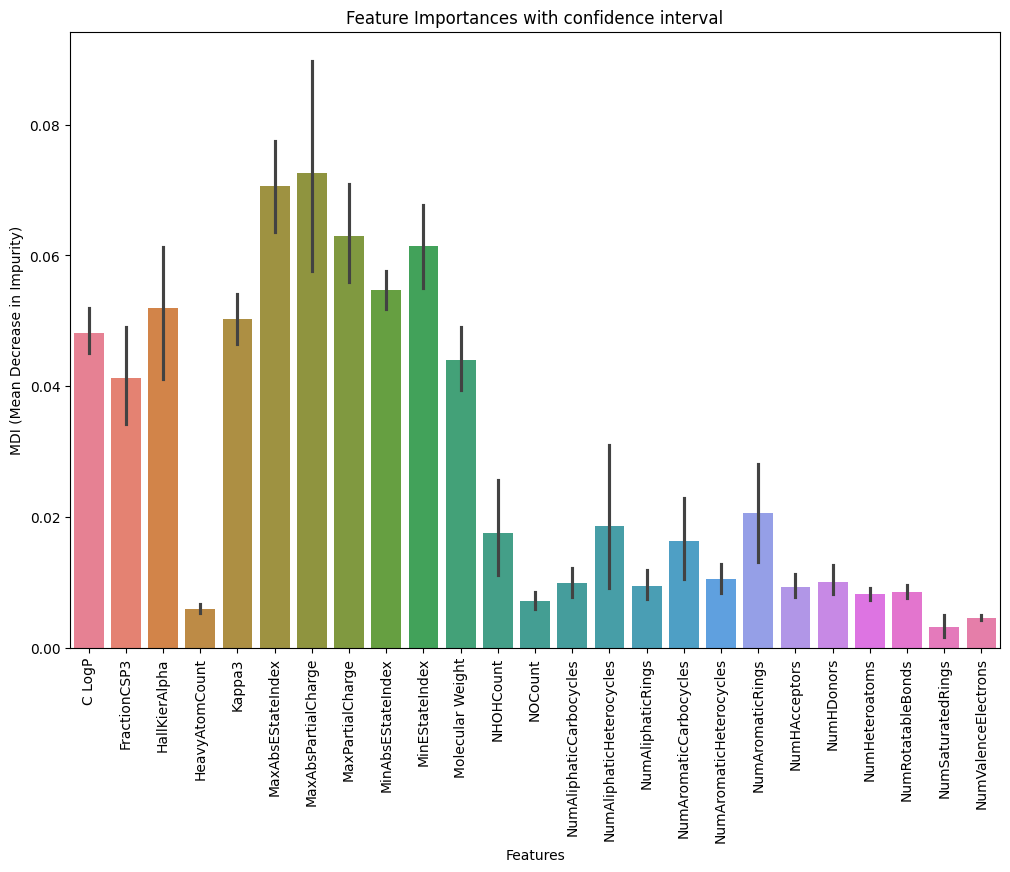

In [5]:
# Train the Random Forest Regressor
rf = RandomForestClassifier(n_estimators=10, random_state=42)
rf.fit(X, y)

mdi_df = pd.DataFrame(
    data=[tree.feature_importances_ for tree in rf.estimators_],
    columns=X.columns,
)

# Mapping to original cols
mdi_df.columns = [col.split("__")[1] for col in mdi_df.columns]
df = mdi_df.T
df["Orginal"] = [col.split("_")[0] for col in df.index]
df = df.groupby("Orginal").max().T

# Visualize the feature importances with Seaborn
plt.figure(figsize=(12, 8))
ax = sns.barplot(
    data=df,
)
ax.set_xticklabels(df.columns, rotation=90)
ax.set_ylabel("MDI (Mean Decrease in Impurity)")
ax.set_xlabel("Features")
ax.set_title("Feature Importances with confidence interval")
plt.show()

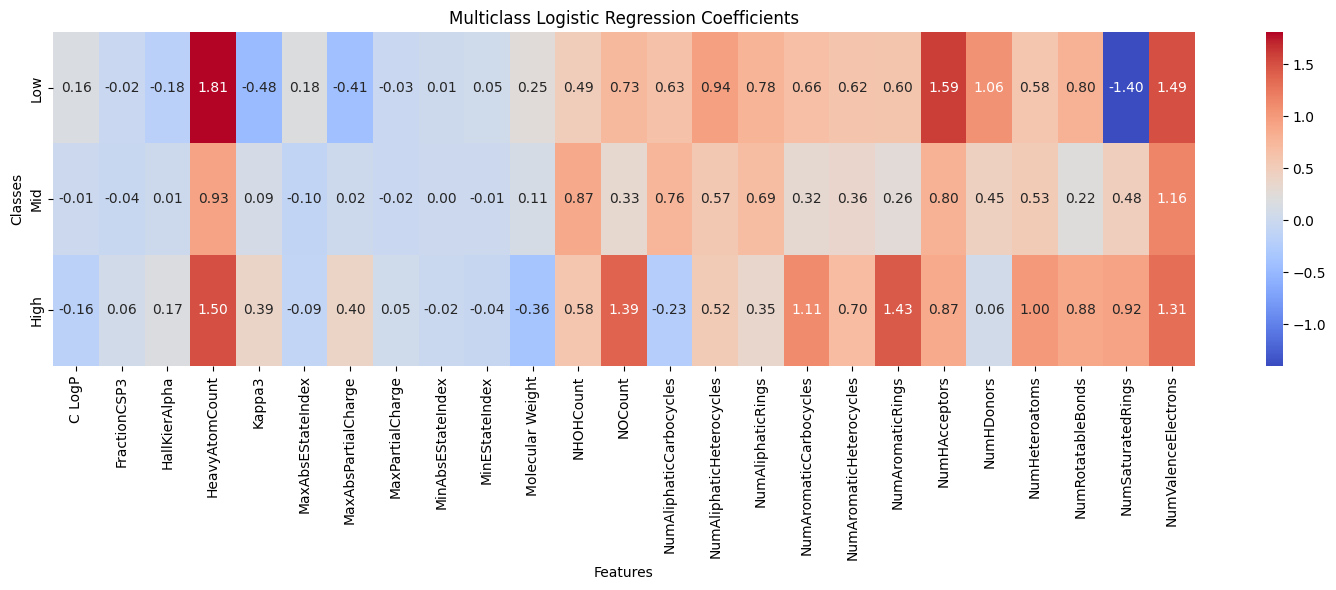

In [6]:
# Train the Random Forest Regressor
lr = LogisticRegression(max_iter=1000, random_state=42)
lr.fit(X, y)
coefs_df = pd.DataFrame(lr.coef_, columns=X.columns)


# Mapping to original cols
coefs_df.columns = [col.split("__")[1] for col in coefs_df.columns]
df = coefs_df.T
df["Orginal"] = [col.split("_")[0] for col in df.index]
df = df.groupby("Orginal").max().T

plt.figure(figsize=(15, 6))
sns.heatmap(
    df,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    # xticklabels=X.columns,
    yticklabels=["Low", "Mid", "High"],
)
plt.title("Multiclass Logistic Regression Coefficients")
plt.xlabel("Features")
plt.ylabel("Classes")
plt.tight_layout()
plt.show()

In general, features such as the molecular weight, the maximal absolute partial charge, the number of aliphatic carbocycles, and count of NO groups are highly significant and influential in deciding IC50. Other molecular descriptors, such as the number of aromatic rings, carbocycles and heterocycles, have no significant predictive power for IC50. More interestingly, we look at how these coefficients change depending on the level of IC50. For example, molecular weight seems to favor low IC50 values, maximum absolute partial charge favors low to medium IC50 values, while the Hall-Kier indicator (a measure of accessibility between bonds) has larger weights when predicting higher IC50s.

Further supporting these results, we see that the most important features in the random forest model include the maximum absolute partial charge of a molecule, the count of HNO groups, the electrotopological state, and the Hall-Kier index, and number of aliphatic carbocycles. We therefore recognise that these results are reproducible across methods, pointing to a biological truth.

All in all, a high drug efficacy is therefore notably influenced, based on both classifications, by higher molecular weights, higher maximum absolute partial charges, and lower number of aliphatic carbocycles.


---

# Conclusion

Throughout this analysis we have travelled from disease to molecules. This finally allows us to map the molecular path to health. In particular, we have shown how distinct structural and chemical features, such as higher molecular weights, higher maximum absolute partial charges, and lower number of aliphatic carbocycles increase the efficacy of drugs. In practice, this is achieved by branching out and exploring the structural space by large screenings of slight modifications to an initial academic publication. This then brings new patents, new features and potentially future clinical trials, although these are lengthy in time.

At a higher level, although historically established targets, such as CDKs, RTKs and growth factor receptors are still highly influential, there exist emerging targets, like neurotransmitter and hormone receptors. Globally, this analysis maps the current state of drug discovery, focusing on health issues of the 21st century, such as cancer, immunodeficiency, inflammation and neurodegeneration.